In [1]:
%load_ext autoreload
%autoreload 1
%aimport modules.dataset_auxiliary, modules.classification_auxiliary, modules.ml_auxiliary, modules.tensor_module

/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import os
import pickle
import modules.dataset_auxiliary as daux
from modules.dataset_auxiliary import *
from modules.classification_auxiliary import *
from modules.ml_auxiliary import *
from modules.tensor_module import *
import copy

# Tensors
import tntorch as tn
import tensorly as tl
from tensorly import random
from tensorly.decomposition import tucker, parafac, partial_tucker
from tensorly.tenalg import mode_dot, multi_mode_dot


# ML
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

import xgboost as xgb
import pystmm


## Load initial ds_dict

In [3]:
# current version
file_path = r'backup/ds_dict.pkl'

# # save:
# with open(file_path, 'wb') as f:
#     pickle.dump(ds_dict, f)

# load:
with open(file_path, 'rb') as f:
    ds_dict = pickle.load(f)

check_ds_dict(ds_dict)
print()

True 	Info: 7468;   Skeleton: 7468;   Total: 7468



In [4]:
ds_dict['G101__trial1__left__call']['info']['label']

{'is_valid_performance': True, 'action_start': 18.0, 'action_end': 61.0}

## Selecting 

In [5]:
gestures = ['start', 'call', 'mute', 'pupil', 'high', 'select', 'unmute', 'close', 'yes', 'no', 'save']
# gestures += ['scroll_up', 'scroll_down', 'swipe_right', 'swipe_left', 'export'] 
# gestures += ['screenshot', 'writing', 'delete']
# gestures += ['moving_down', 'moving_left', 'moving_right', 'moving_up', 'moving_back', 'moving_forward']
# gestures += ['anticlockwise', 'clockwise', 'right_forward', 'left_forward']
# gestures += ['zoom_in_c', 'zoom_out_c', 'zoom_out_l', 'zoom_out_r', 'zoom_in_l',  'zoom_in_r']
# gestures += ['yes_head', 'no_head']

In [132]:
# exp_cofig = "one hand gestures  | [x, y] | fill_na: {'value':0} | train: subs[0:16], test: subs[16:]"
# exp_cofig = "one hand gestures  | [x, y] | fill_na: {'value':0} | train: subs[5:], test: subs[:5]"
# exp_cofig = "one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5]"
# exp_cofig = "one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] 3,4D"

# exp_cofig = "all gestures  | [x, y] | fill_na: {'value':0} | train: subs[5:], test: subs[:5]"
exp_cofig = "all gestures  | [x, y] | fill_na: {'value':0} | train: subs[:], test: subs[:5]"

Selected  2812 samples. 4656(7468) was dropped!
14 samples was unvalied. Ramain 2798(2812)


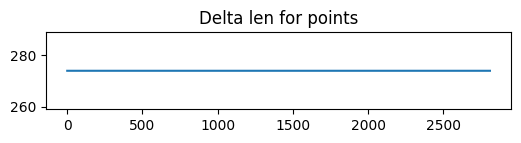

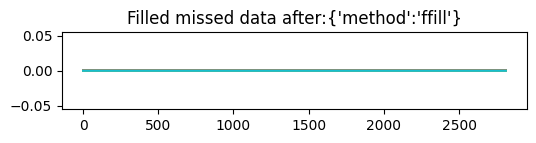

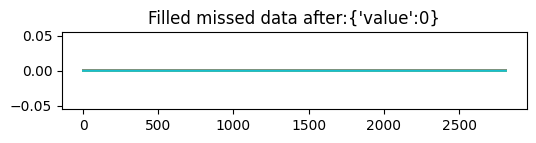

Train
Selected  2812 samples. 0(2812) was dropped!
Test
Selected  660 samples. 2152(2812) was dropped!


In [131]:
# preparing

subs = get_all_subs_from_ds_dict(ds_dict)
subs = subs[:]
# gestures = ['start', 'call', 'mute', 'pupil', 'high', 'select', 'unmute', 'close', 'yes', 'no', 'save']


data_dict_selected = select_g_ids(ds_dict, subs=subs, gestures=gestures)
data_dict_valid =  select_valid_samplels(data_dict_selected)

# points
data_dict_points = select_points(data_dict_selected, coords=['x', 'y'], hand_points=[])
# data_dict_points = select_points(data_dict_selected, coords=['x', 'y', 'z'], hand_points='def')
plt.show()

# nan
# data_dict_filled = update_skeleton(data_dict_points, update_df_fill_na, {'value':0})
data_dict_filled_ = update_skeleton(data_dict_points, update_df_fill_na, {'method':'ffill'})
plt.title(f"Filled missed data after:{{'method':'ffill'}}")
plt.show()

data_dict_filled = update_skeleton(data_dict_filled_, update_df_fill_na, {'value':0})
# data_dict_filled = update_skeleton(data_dict_points, update_df_fill_na, {'method':'ffill'})
plt.title(f"Filled missed data after:{{'value':0}}")
plt.show()


data_dict_adjusted = update_skeleton(data_dict_filled, update_df_solve_time, show=False)


#train
print('Train')
data_dict = select_g_ids(data_dict_adjusted, subs=subs[:])
data_dict, label_dict = form_gesture_labels(data_dict)
samples_list,  labels_list = form_samples_labels_lists(data_dict)
data_tensor = np.concatenate(samples_list, axis=0)

#test 
print('Test')
data_dict_test = select_g_ids(data_dict_adjusted, subs=subs[:5])
data_dict_test, label_dict_test = form_gesture_labels(data_dict_test)
samples_list_test,  labels_list_test = form_samples_labels_lists(data_dict_test)
data_tensor_test = np.concatenate(samples_list_test, axis=0)



## Tensor preprocessing

### CPD

In [249]:
# CPD - Bad!!
t = data_tensor
tt = data_tensor_test
rank = 8
factors_CPD = parafac(t, rank=rank)


In [336]:
t_rec_CPD = tl.cp_to_tensor(factors_CPD)
print(f"CPD: Rank: {rank: }, distance: {tl.norm(t - t_rec_CPD)} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_CPD)}")

ValueError: too many values to unpack (expected 2)

In [308]:

factors = factors_CPD
# core = gen_diag_core_tensor(rank,len(factors.factors), factors.weights)
# tensor = mode_dot(core_t, factors.factors[0], mode=0)

tensor_CPD = multi_mode_dot(t, [matrix.T for matrix in factors.factors[1:]], modes=[1, 2])
tensor_CPD_test = multi_mode_dot(tt, [matrix.T for matrix in factors.factors[1:]], modes=[1, 2])

### PCA

In [103]:
matrix_PCA, matrix_PCA_test = get_PCA_tensors(data_tensor, data_tensor_test, rank=-1,  verbose=2)

PCA tranformation with rank: 2152. tensor shape: (2152, 120, 134)
PCA: Rank: 2152, rel_error:  0.00736 ; norm origin: 3721.62545533791 ; norm recovered: 3721.524656272879


#### code

In [94]:
# from sklearn.decomposition import PCA
# X = t_uf0

# pca = PCA(n_components=600, svd_solver='full')
# pca.fit(X)

# matrix_PCA = pca.transform(t_uf0)
# matrix_PCA_test =  pca.transform(tt_uf0)


PCA(n_components=600, svd_solver='full')

In [ ]:
# norm_t = tl.norm(t)
# t_rec = pca.inverse_transform(matrix_PCA)
# print(f"PCA: N Components: {rank }, rel_error: {tl.norm(t_uf0 - t_rec)/tl.norm(t): .5f} ; norm origin: {tl.norm(t_uf0)} ; norm recovered: {tl.norm(t_rec)}")
         

In [106]:
# def get_PCA_tensors(data_tensor, data_tensor_test, rank=-1,  verbose=2):
#     t = data_tensor
#     tt = data_tensor_test

#     t_uf0 = tl.unfold(t, mode=0)
#     tt_uf0 = tl.unfold(tt, mode=0)
    
#     if rank is None or rank == -1:
#         rank = np.min(t_uf0.shape)
        
#     pca = PCA(n_components=rank, svd_solver='full')
#     pca.fit(X)
        
#     if verbose > 1:
#         print(f"PCA tranformation with rank: {rank}. tensor shape: {data_tensor.shape}")

#     matrix_PCA = pca.transform(t_uf0)
    
#     if verbose > 0:
#         norm_t = tl.norm(t)
#         t_rec = pca.inverse_transform(matrix_PCA)
#         print(f"PCA: Rank: {rank }, rel_error: {tl.norm(t_uf0 - t_rec)/tl.norm(t): .5f} ; norm origin: {tl.norm(t_uf0)} ; norm recovered: {tl.norm(t_rec)}")
           
            
#     matrix_PCA = matrix_PCA
#     matrix_PCA_test =  pca.transform(tt_uf0)
#     return matrix_PCA, matrix_PCA_test

### SVD

In [104]:
matrix_SVD, matrix_SVD_test = get_SVD_tensors(data_tensor, data_tensor_test, rank=-1,  verbose=2)

SVD decomposition with rank: 2152. tensor shape: (2152, 120, 134)
SVD: Rank: 2152, rel_error:  0.00000 ; norm origin: 3721.62545533791 ; norm recovered: 3721.6254553379113


#### code

In [83]:
# t = data_tensor
# tt = data_tensor_test

# t_uf0 = tl.unfold(t, mode=0)
# tt_uf0 = tl.unfold(tt, mode=0)

# u_0, s_0, v_0 = tl.partial_svd(t_uf0, )
# norm_t = tl.norm(t)

# rank = 600
# # rank = 5688



In [84]:
# rank = 600

In [85]:
# t_rec_SVD = recover_svd((u_0, s_0, v_0), rank=rank)
# print(f"SVD: Rank: {rank }, rel_error: {tl.norm(t_uf0 - t_rec_SVD)/tl.norm(t): .5f} ; norm origin: {tl.norm(t_uf0)} ; norm recovered: {tl.norm(t_rec_SVD)}")

SVD: Rank: 600, rel_error:  0.00304 ; norm origin: 699.5597166036002 ; norm recovered: 699.468366558339


In [98]:
# matrix_SVD = np.matmul(t_uf0, v_0[:rank, :].T)
# matrix_SVD_test = np.matmul(tt_uf0, v_0[:rank, :].T)

In [93]:
# def get_SVD_tensors(data_tensor, data_tensor_test, rank=-1,  verbose=2):
#     t = data_tensor
#     tt = data_tensor_test

#     t_uf0 = tl.unfold(t, mode=0)
#     tt_uf0 = tl.unfold(tt, mode=0)
    
#     u_0, s_0, v_0 = tl.partial_svd(t_uf0, )
    
#     if rank is None or rank == -1:
#         rank = len(s_0)
        
#     if verbose > 1:
#         print(f"Decomposition with rank: {rank}. tensor shape: {data_tensor.shape}")

#     if verbose > 0:
#         norm_t = tl.norm(t)
#         t_rec_SVD = recover_svd((u_0, s_0, v_0), rank=rank)
#         print(f"SVD: Rank: {rank }, rel_error: {tl.norm(t_uf0 - t_rec_SVD)/tl.norm(t): .5f} ; norm origin: {tl.norm(t_uf0)} ; norm recovered: {tl.norm(t_rec_SVD)}")
            
#         matrix_SVD = np.matmul(t_uf0, v_0[:rank, :].T)
#         matrix_SVD_test = np.matmul(tt_uf0, v_0[:rank, :].T)
#     return matrix_SVD, matrix_SVD_test

#### Selecting rank

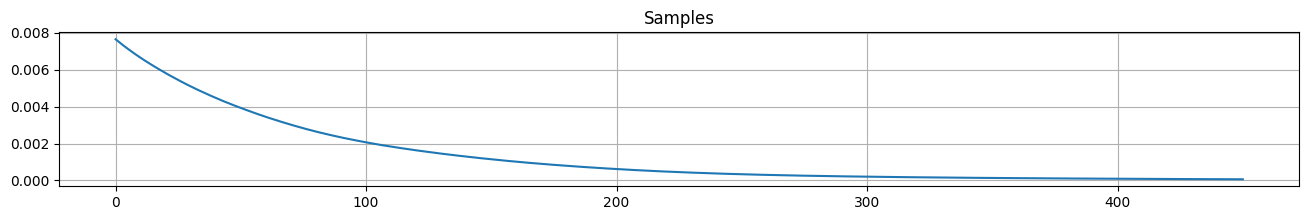

In [28]:
# show_decomposition_error(s_0, norm_t,'Samples',show=False, start=50, end=500)
# # plt.gcf().set_size_inches((16, 2))

### Tucker

In [ ]:
# tensor_tucker, tensor_tucker_test = get_tucker_tensors(data_tensor, data_tensor_test)

In [134]:
data_tensor_ = data_tensor.reshape(data_tensor.shape[:2] + (-1, 2))
data_tensor_test_ = data_tensor_test.reshape(data_tensor_test.shape[:2] + (-1, 2))

In [135]:
tensor_tucker_tn, tensor_tucker_test_tn = get_tucker_tensors_tn(data_tensor, data_tensor_test)

Tucker decomposition with rank: (2812, 120, 50). tensor shape: (2812, 120, 50)
Tucker: Rank: (2812, 120, 50), rel_error:  0.00000 ; norm origin: 2356.7823972376 ; norm recovered: 2356.785888671875


In [136]:
tensor_tucker_tn_, tensor_tucker_test_tn_ = get_tucker_tensors_tn(data_tensor_, data_tensor_test_)

Tucker decomposition with rank: (2812, 120, 25, 2). tensor shape: (2812, 120, 25, 2)
Tucker: Rank: (2812, 120, 25, 2), rel_error:  0.00000 ; norm origin: 2356.7823972376 ; norm recovered: 2356.784423828125


In [ ]:
# tensor_tucker, tensor_tucker_test = get_tucker_tensors_tn_centered(data_tensor, data_tensor_test)

In [127]:
list(data_dict.keys())[0]

'G106__trial1__left__call'

#### test several libs

In [33]:
# tensor_tucker_2_list, tensor_tucker_test_2_list = [], []
# for i in range(10):
#     tensor_tucker_2, tensor_tucker_test_2 = get_tucker_tensors(data_tensor, data_tensor_test)
#     tensor_tucker_2_list += [tensor_tucker_2]
#     tensor_tucker_test_2_list += [tensor_tucker_test_2]
print()

# for i in range(len(tensor_tucker_2_list)):
#     print(np.abs((tensor_tucker_2_list[i] - tensor_tucker_2)).sum()/tensor_tucker_2.size)

Tucker decomposition with rank: (120, 134). tensor shape: (2152, 120, 134)
Tucker: Rank: (120, 134), rel_error:  0.00000 ; norm origin: 3721.6254553379067 ; norm recovered: 3721.625455337903
Tucker decomposition with rank: (120, 134). tensor shape: (2152, 120, 134)
Tucker: Rank: (120, 134), rel_error:  0.00000 ; norm origin: 3721.6254553379067 ; norm recovered: 3721.625455337903
Tucker decomposition with rank: (120, 134). tensor shape: (2152, 120, 134)
Tucker: Rank: (120, 134), rel_error:  0.00000 ; norm origin: 3721.6254553379067 ; norm recovered: 3721.625455337903
Tucker decomposition with rank: (120, 134). tensor shape: (2152, 120, 134)
Tucker: Rank: (120, 134), rel_error:  0.00000 ; norm origin: 3721.6254553379067 ; norm recovered: 3721.625455337903
Tucker decomposition with rank: (120, 134). tensor shape: (2152, 120, 134)
Tucker: Rank: (120, 134), rel_error:  0.00000 ; norm origin: 3721.6254553379067 ; norm recovered: 3721.625455337903
Tucker decomposition with rank: (120, 134). t

In [61]:
# # tntorch 
# # get_tucker_tensors_v2(data_tensor, data_tensor_test)
# data = torch.Tensor(data_tensor)
# t2 = tn.Tensor(data, ranks_tucker=[10, 20, 30])

# tn.relative_error(data, t2)

# t2.Us[0].T @ t2.Us[0]
# t2.tucker_core().shape

# t2

#### code

In [9]:
# Tucker with HOSVD
t = data_tensor
tt = data_tensor_test
rank = [120, 134]
core_tucker, factors_tucker = partial_tucker(t, [1, 2], rank=rank, n_iter_max=1000)

# rank = [8, 60, 20]
# core_tucker, factors_tucker = tucker(t, rank=rank)


KeyboardInterrupt: 

In [11]:
# t_rec_tucker = tl.tucker_to_tensor((core_tucker, [None] + factors_tucker), skip_factor=0)
# print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")

Tucker: Rank: [120, 134], rel_error:  0.00000 ; norm origin: 5982.350322460424 ; norm recovered: 5982.350322460414


In [140]:
# # t_rec_tucker = tl.tucker_to_tensor((core_tucker, factors_tucker))
# t_rec_tucker = tl.tucker_to_tensor((core_tucker, factors_tucker))
# print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")

In [12]:
# factors = factors_tucker
# factors = [None] + factors

# tensor_tucker = multi_mode_dot(t, [matrix.T for matrix in factors[1:]], modes=[1, 2])
# tensor_tucker_test = multi_mode_dot(tt, [matrix.T for matrix in factors[1:]], modes=[1, 2])

# # core = core_tucker
# # tensor_tucker = mode_dot(core, factors[0], mode=0)

In [8]:
# def get_tucker_tensors(data_tensor, data_tensor_test, rank=None, n_iter_max=1000, verbose=1):
#     t = data_tensor
#     tt = data_tensor_test
    
#     if rank is None:
#         rank = data_tensor.shape[1:]
        
#     modes = [i for i in range(len(data_tensor.shape))]
#     modes = modes[1:]
#     core_tucker, factors_tucker = partial_tucker(t, modes, rank=rank, n_iter_max=n_iter_max)
    
#     if verbose > 0:
#         t_rec_tucker = tl.tucker_to_tensor((core_tucker, [None] + factors_tucker), skip_factor=0)
#         print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")
            
#     factors = factors_tucker
#     factors = [None] + factors
#     tensor_tucker = multi_mode_dot(t, [matrix.T for matrix in factors[1:]], modes=modes)
#     tensor_tucker_test = multi_mode_dot(tt, [matrix.T for matrix in factors[1:]], modes=modes)
        
#     return tensor_tucker, tensor_tucker_test
        

#### Selecting ranks

In [130]:
t_uf0 = tl.unfold(t, mode=0)
t_uf1 = tl.unfold(t, mode=1)
t_uf2 = tl.unfold(t, mode=2)

In [131]:
# u_0, s_0, v_0 = tl.partial_svd(t_uf0, )
u_1, s_1, v_1 = tl.partial_svd(t_uf1, 120)
u_2, s_2, v_2 = tl.partial_svd(t_uf2, 134)

norm_t = tl.norm(t)

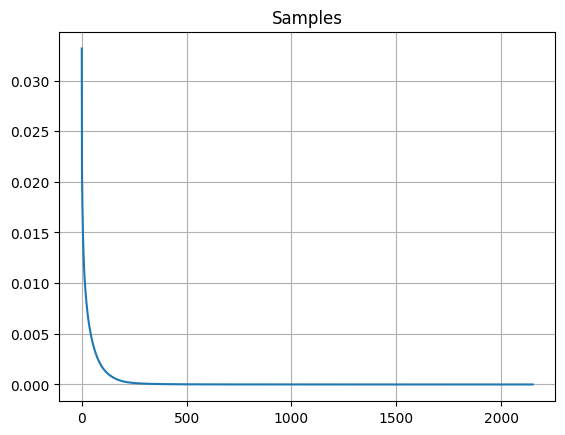

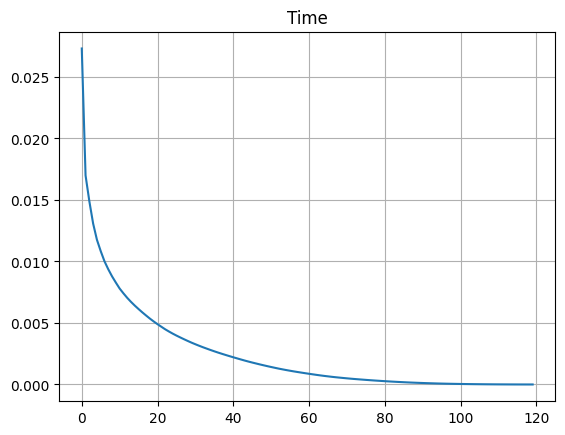

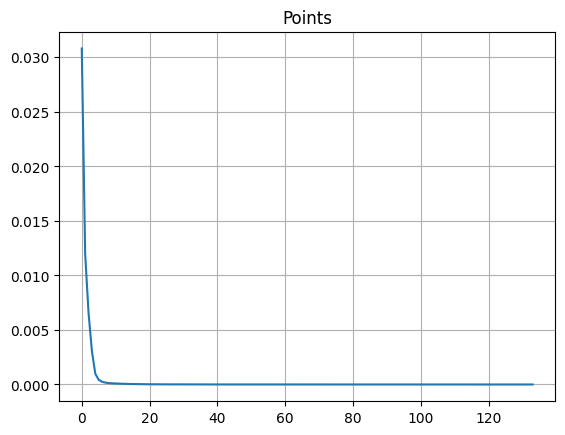

In [157]:
show_decomposition_error(s_0, norm_t,'Samples',)
show_decomposition_error(s_1, norm_t,'Time',)
show_decomposition_error(s_2, norm_t,'Points',)


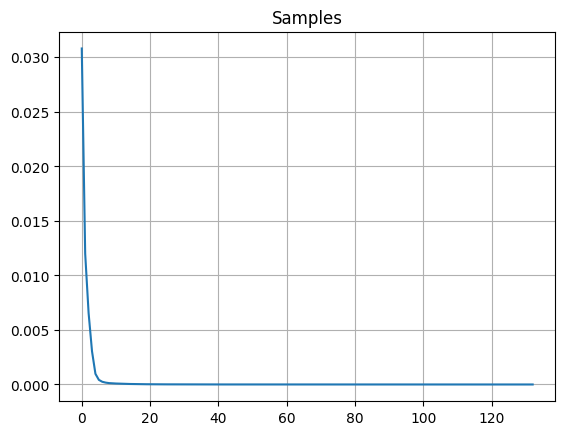

In [134]:
show_decomposition_error(s_2, norm_t,'Samples', d_step=1)

### ML Cross validation 

In [ ]:
def do_cross_validation_per_subs(data_dict_adjusted, model_pair, decompose=None, decompose_rank=-1,  n_trials=10, subs=-1, pref='',  step=5,):
    if subs == -1:
        subs = get_all_subs_from_ds_dict(data_dict_adjusted)
        
    acc_list = []
    for i, cv_block in enumerate(split_cross_validation(data_dict_adjusted, subs, step=step)):
        data_tensor, data_tensor_test, labels_list, labels_list_test = cv_block
        
        
        print(f"Decomposition {decompose} with rank {decompose_rank}:", end='   ')
        if decompose is None:
            decompose = 'none'
            
        decompose = decompose.lower()
            
        if decompose in ['none', '-']:
            tensor = data_tensor
            tensor_test = data_tensor_test
        elif decompose in ['tucker']:
                tensor, tensor_test = get_tucker_tensors(data_tensor, data_tensor_test, rank=decompose_rank, verbose=2)
        elif decompose in ['svd']:
            tensor, tensor_test = get_SVD_tensors(data_tensor, data_tensor_test, rank=decompose_rank, verbose=2)
        # print(" was done!")
            
        decompose_str = '' if decompose in ['none', '-'] else decompose + '+' 
        acc_trial_list = []
        print(f'Start testing model: {decompose_str + model_pair[1]}')
        for j in range(n_trials):
            print('j =', j, ': ', end='')
            acc = test_model_pair(model_pair, tensor, tensor_test, labels_list, labels_list_test, pref=pref, verbose=0)
            print(acc)
            acc_trial_list += [acc]
        acc_trial_array = np.array(acc_trial_list)
        acc_mean = acc_trial_array.mean()
        acc_std = acc_trial_array.std(ddof=1)
        
        acc_list += [acc]
        print(f"Acc[{i}] = {100*acc_mean:2.2f}({100*acc_std:2.2f})%")
        print()
    print()
    acc_array = np.array(acc_list)
    print(f"Cross validation with {i+1} blocks was ended.")
    print(f"Mean acc={100*acc_array.mean():2.2f}%")
    
    return acc_list
    
    
    
    

In [15]:
model_pair = (RandomForestClassifier(n_estimators=1, max_depth=2, n_jobs=-1), 'RandForest')
ass_array = do_cross_validation_per_subs(data_dict_adjusted, model_pair, 'Tucker', pref='', decompose_rank=[8,8], step=7,)


For test subjects: ['G101', 'G102', 'G103', 'G104', 'G105', 'G106', 'G107']
Selected  4986 samples. 2482(7468) was dropped!
Selected  2482 samples. 4986(7468) was dropped!
Decomposition Tucker with rank [8, 8]:   Decomposition with rank: [8, 8]. tensor shape: (4986, 120, 134)
Tucker: Rank: [8, 8], rel_error:  0.11315 ; norm origin: 5613.683332579163 ; norm recovered: 5577.633769428874
Start testing model: tucker+RandForest
j = 0 : 0.08259468170829976
j = 1 : 0.1031426269137792
j = 2 : 0.09669621273166801
j = 3 : 0.06365834004834811
j = 4 : 0.088638195004029
j = 5 : 0.09830781627719581
j = 6 : 0.0854149879129734
j = 7 : 0.05922643029814666
j = 8 : 0.08259468170829976
j = 9 : 0.0684931506849315
Acc[0] = 8.29(1.50)%


For test subjects: ['G108', 'G109', 'G110', 'G111', 'G112', 'G113', 'G114']
Selected  4960 samples. 2508(7468) was dropped!
Selected  2508 samples. 4960(7468) was dropped!
Decomposition tucker with rank [8, 8]:   Decomposition with rank: [8, 8]. tensor shape: (4960, 120, 13

In [111]:
cv_list = [cv for cv in split_cross_validation(data_dict_adjusted, subs, step=7)]


For test subjects: ['G101', 'G102', 'G103', 'G104', 'G105', 'G106', 'G107']

For test subjects: ['G108', 'G109', 'G110', 'G111', 'G112', 'G113', 'G114']

For test subjects: ['G115', 'G116', 'G117', 'G118', 'G119', 'G120', 'G121']


In [ ]:


def split_cross_validation(data_dict_adjusted, subs, step=5):
    
    end = len(subs) - step
    if len(subs) % step == 0:
        end +=1
            
    cv_list = []

    for i, start in enumerate([ii for ii in range(0, end, step)]):
        
        test_subs = [sub for sub in subs[start:start+step]]
        train_subs = [sub for sub in subs if sub not in test_subs]
        print(f"\nFor test subjects: {test_subs}")
        
        # train
        data_dict = select_g_ids(data_dict_adjusted, subs=train_subs)
        data_dict, label_dict = form_gesture_labels(data_dict)
        samples_list,  labels_list = form_samples_labels_lists(data_dict)
        data_tensor = np.concatenate(samples_list, axis=0)

        #test 
        data_dict_test = select_g_ids(data_dict_adjusted, subs=test_subs)
        data_dict_test, label_dict_test = form_gesture_labels(data_dict_test)
        samples_list_test,  labels_list_test = form_samples_labels_lists(data_dict_test)
        data_tensor_test = np.concatenate(samples_list_test, axis=0)
        
        
        yield [data_tensor, data_tensor_test, labels_list, labels_list_test]

        
        
    #     cv_list += [[data_tensor, data_tensor_test, labels_list, labels_list_test]]
    
    # return cv_list



# def corss_validation(data_dict_adjusted, subs, step=5, origin_models_pair=[], tensor_models_pair=[]):
#     #train
    
#     n_cross = (len(subs) - step) // step
#     origin_acc_tensor = np.zeros((len(origin_models_pair), n_cross))
#     tensor_acc_tensor = np.zeros((len(tensor_models_pair), n_cross))

#     for i, start in enumerate([ii for ii in range(0, len(subs) - step, step)]):
#         print(f"For stest subjects: {test_subs}")
#         test_subs = [sub for sub in subs[start, start+step]]
#         train_subs = [sub for sub in subs if sub not in test_subs]
        
#         # train
#         data_dict = select_g_ids(data_dict_adjusted, subs=train_subs)
#         data_dict, label_dict = form_gesture_labels(data_dict)
#         samples_list,  labels_list = form_samples_labels_lists(data_dict)
#         tensor = np.concatenate(samples_list, axis=0)

#         #test 
#         data_dict_test = select_g_ids(data_dict_adjusted, subs=test_subs)
#         data_dict_test, label_dict_test = form_gesture_labels(data_dict_test)
#         samples_list_test,  labels_list_test = form_samples_labels_lists(data_dict_test)
#         tensor_test = np.concatenate(samples_list_test, axis=0)
        
#         print('Test and train was splited')
        
        
#         # tucker
#         t = tensor
#         tt = tensor_test
#         rank = [120, 134]
#         core_tucker, factors_tucker = partial_tucker(t, [1, 2], rank=rank, n_iter_max=1000)
#         t_rec_tucker = tl.tucker_to_tensor((core_tucker, [None] + factors_tucker), skip_factor=0)
#         print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")
        
        
#         factors = factors_tucker
#         factors = [None] + factors

#         tensor_tucker = multi_mode_dot(t, [matrix.T for matrix in factors[1:]], modes=[1, 2])
#         tensor_tucker_test = multi_mode_dot(tt, [matrix.T for matrix in factors[1:]], modes=[1, 2])
#         print('Tensors was decomposed')
        
#         #origin models:
        
#         print('For original data')
#         for j, model_pair in enumerate(origin_models_pair):
#             model, model_name = model_pair
#             print(f"   for model: {model_name}, acc =", end = ' ' )
            
#             model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
            
#             label_test = model.predict(X_test)
#             acc_test = accuracy_score(X_test, label_test)
#             print(acc_test)
#             origin_acc_tensor[j, i] = acc_test 
            
#         print('For tranformed data')
#         for j, model_pair in enumerate(origin_models_pair):
#             model, model_name = model_pair
#             print(f"   for model: tensor +{model_name }, acc =", end = ' ' )
            
#             tensor = tensor_tucker
#             tensor_test = tensor_tucker_test
            
#             X_train, y_train = make_X_y(tensor, labels_list)
#             X_test, y_test = make_X_y(tensor_test, labels_list_test)
            
#             if model_name in ['STMM', 'STM']:
#                 X_train = tensor
#                 X_test = tensor_test
#             else:
#                 X_train = StandardScaler().fit_transform(X_train)
#                 X_test = StandardScaler().fit_transform(X_test)

#             model.fit(X_train, y_train)
            
#             label_test = model.predict(X_test)
#             acc_test = accuracy_score(X_test, label_test)
#             print(acc_test)
#             tensor_acc_tensor[j, i] = acc_test
            
#         print()
#         print()
        
#     return origin_acc_tensor, tensor_acc_tensor
            
        

            
            
            
        
        
        

## Tensor components research

### Components plots

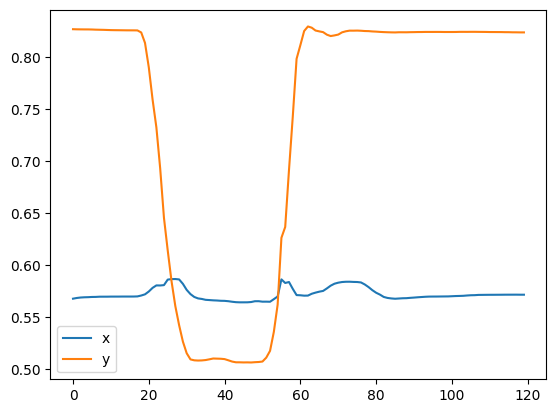

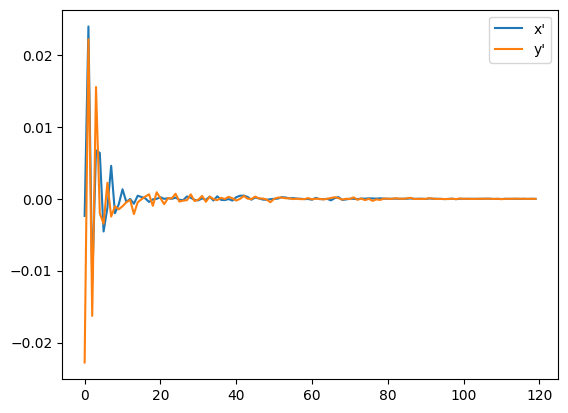

In [163]:
plt.plot(data_tensor_[0,:,15,:])
plt.legend(['x', 'y', 'z'])
# plt.title(f'4D, After tucker, along metric dim, all peaple, pose + hands, {start_point}:')
plt.show()

plt.plot(tensor_tucker_tn_[0,:,15,:])
# plt.title(f'4D, After tucker, along metric dim, all peaple, pose + hands, {start_point}:')
plt.legend(["x'", "y'", "z'"])
plt.show()

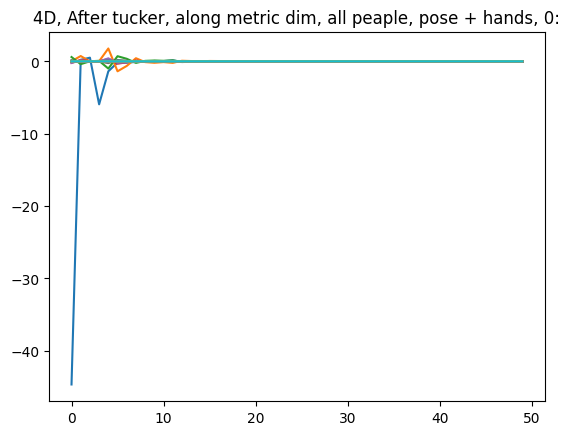

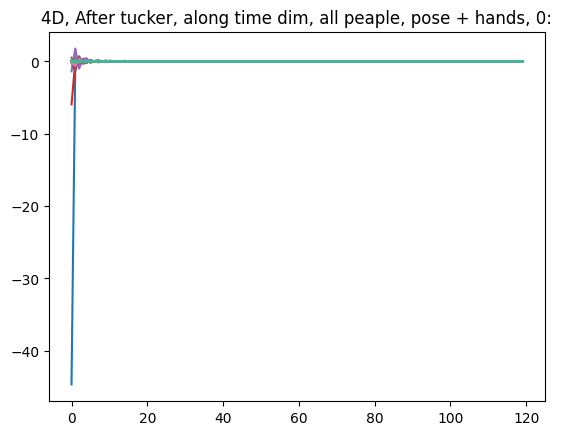

In [143]:
# 3D
# start_point = 1
# plt.plot(tensor_tucker_tn[0].T[:, start_point:])
# plt.title(f'After tucker, along metric dim, all peaple, pose + hands, {start_point}:')
# plt.show()

# plt.plot(tensor_tucker_tn[0][:, start_point:])
# plt.title(f'After tucker, along time dim, all peaple, pose + hands, {start_point}:')
# plt.show()

# 4D
s1, s2 = tensor_tucker_tn.shape[:2]

start_point = 0
plt.plot(tensor_tucker_tn_.reshape([s1, s2, -1])[0].T[:, start_point:])
plt.title(f'4D, After tucker, along metric dim, all peaple, pose + hands, {start_point}:')
plt.show()

plt.plot(tensor_tucker_tn_.reshape([s1, s2, -1])[0][:, start_point:])
plt.title(f'4D, After tucker, along time dim, all peaple, pose + hands, {start_point}:')
plt.show()


### Peaple indexes + component plot

In [144]:
# getting people indexes
s_list = []
for key in data_dict.keys():
    g_num = key[2:4]
    s_list += [int(g_num)]
    
s_array = np.array(s_list)
s_array = np.diff(s_array)
# plt.plot(s_array)
idx = np.where(s_array ==1)
    

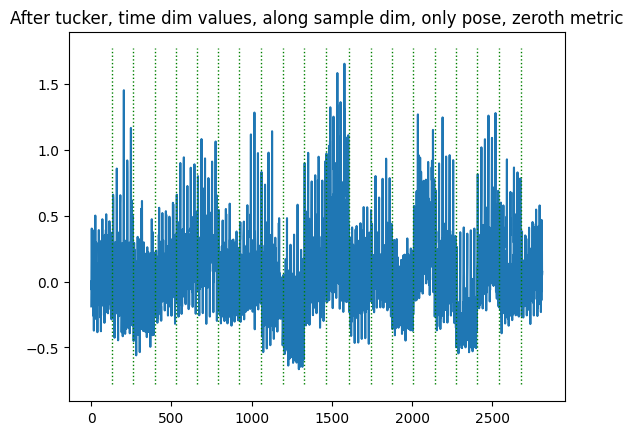

In [162]:
s1, s2 = tensor_tucker_tn.shape[:2]
# plt.plot(tensor_tucker_tn[:,0,0][:,0,12])
plt.plot(tensor_tucker_tn_.reshape([s1, s2, -1])[:,0,6])
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x=idx, ymin=ymin, ymax=ymax, colors='green', ls=':', lw=1,)
plt.title('After tucker, time dim values, along sample dim, only pose, zeroth metric')
print()

### People feature data

In [160]:
# getting 21 point data
s1, s2 = tensor_tucker_tn.shape[:2]
# data = tensor_tucker_tn[:,0,0]
data = tensor_tucker_tn_.reshape([s1, s2 , -1])[:,0,5]
subs_data = []
idxs = [0] + list(idx[0]) + [len(data_dict.keys())]
for i in range(len(idxs) -1):
    subs_data += [np.mean(data[idxs[i]:idxs[i+1]])]
    

In [152]:
# saving 21 point data
# a = tensor_tucker_tn[:,0,0]
a = subs_data
with open('subs_data_mean_4D_to_3D__all_0_0_xy_pose.pkl', 'wb') as f:
    pickle.dump(a, f)

    

### Correlations between components

In [95]:
# findng correlations betseen components 
corr.iloc[10:25, 10:25]

10     11     12     13     14     15     16     17     18     19  \
10   True  False  False  False  False  False  False  False  False  False   
11  False   True  False  False   True  False  False  False  False  False   
12  False  False   True  False  False  False  False  False  False  False   
13  False  False  False   True   True  False  False  False  False  False   
14  False   True  False   True   True  False  False  False  False  False   
15  False  False  False  False  False   True  False  False  False  False   
16  False  False  False  False  False  False   True  False  False  False   
17  False  False  False  False  False  False  False   True  False  False   
18  False  False  False  False  False  False  False  False   True  False   
19  False  False  False  False  False  False  False  False  False   True   
20  False  False  False  False  False  False  False  False  False  False   
21  False  False  False  False  False  False  False  False  False  False   
22  False  False  False  False  False  False  False  False  False  False   
23  False  False  False  False  False  False  False  False  False  False   
24  False  False  False  False  False  False  False  False  False  False   

       20     21     22     23     24  
10  False  False  False  False  False  
11  False  False  False  False  False  
12  False  False  False  False  False  
13  False  False  False  False  False  
14  False  False  False  False  False  
15  False  False  False  False  False  
16  False  False  False  False  False  
17  False  False  False  False  False  
18  False  False  False  False  False  
19  False  False  False  False  False  
20   True  False  False  False  False  
21  False   True  False  False  False  
22  False  False   True  False  False  
23  False  False  False   True  False  
24  False  False  False  False   True

<AxesSubplot:>

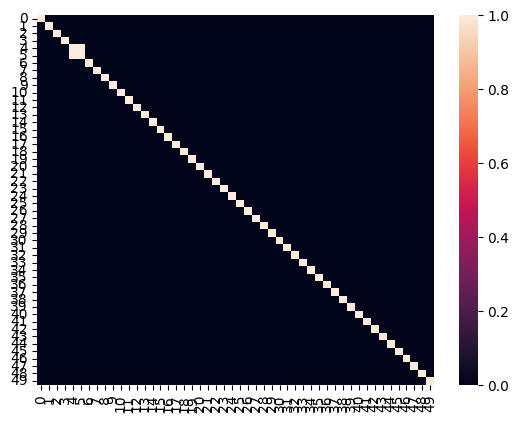

In [159]:
s1, s2 = tensor_tucker_tn.shape[:2]
df = pd.DataFrame(tensor_tucker_tn_.reshape([s1, s2, -1])[:,0,:])
# data = tensor_tucker_tn[:,0,0]
corr = df.corr().abs() > 0.9

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)



# ML part 

### code

In [40]:
# def check_model(model, model_name, X_train, X_test, y_train, y_test, exp_cofig):
#     label_train = model.predict(X_train)
#     label_test = model.predict(X_test)
#     compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
#     plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
#     print()
    
# def train_model(model_pair, tensor, tensor_test, labels_list, labels_list_test, do_scaler=True):
#     model, model_name = model_pair
#     X_train, y_train = make_X_y(tensor, labels_list)
#     X_test, y_test = make_X_y(tensor_test, labels_list_test)
    
    
#     if model_name in ['STM', 'STMM']:
#         new_dims = tensor.shape
#         new_dims_test = tensor_test.shape
#         if len(new_dims) < 3:
#             new_dims = list(new_dims) + [1]
#             new_dims_test = list(new_dims_test) + [1]
#         X_train = X_train.reshape(new_dims)
#         X_test = X_test.reshape(new_dims_test)
#         print('Tensor ML model is used!')
#     else:
#         if do_scaler:
#             scaler = StandardScaler().fit(X_train) 
#             X_train = scaler.transform(X_train)
#             X_test = scaler.transform(X_test)

#     model.fit(X_train, y_train)
#     return model, model_name, X_train, X_test, y_train, y_test


def test_model_pair(model_pair, tensor, tensor_test, labels_list, labels_list_test, pref='', verbose=1):
    model, model_name = model_pair
    if verbose:
        print(f'Model {pref + model_name} is fitting...')
    
    model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
    if verbose:
        print(f"   for model: {pref + model_name}, acc =", end = ' ' )
    label_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, label_test)
    if verbose:
        print(f"{acc_test: .4f}")
    return acc_test
    


def test_model_pair_list(model_pair_list, tensor, tensor_test, labels_list, labels_list_test, pref=''):
    acc_list = []
    for j, model_pair in enumerate(model_pair_list):
        acc_test = test_model_pair(model_pair, tensor, tensor_test, labels_list, labels_list_test, pref=pref)
        # model, model_name = model_pair
        # print(f"   for model: {pref + model_name}, acc =", end = ' ' )
        
        # model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
        
        # label_test = model.predict(X_test)
        # acc_test = accuracy_score(y_test, label_test)
        # print(f"{acc_test: .4f}")
        
        acc_list += [acc_test]
    return acc_list


    
    
    

In [86]:
models_pair_list = [(LogisticRegression(max_iter=200), 'LogReg'), (KNeighborsClassifier(n_neighbors=8), 'KNN')]
test_model_pair_list(models_pair_list, tensor_tucker, tensor_tucker_test, labels_list, labels_list_test, pref='Tucker+')

   for model: Tucker+LogReg, acc =  0.8635
   for model: Tucker+KNN, acc =  0.0427


[0.8634831460674157, 0.04269662921348315]

## Original

In [64]:
tensor = data_tensor
tensor_test = data_tensor_test


# tensor = data_tensor_
# tensor_test = data_tensor_test_


pref = ''

#### LogReg

In [65]:
model = LogisticRegression(max_iter=200)
model_name = pref + 'LogReg'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

NameError: name 'do_scaler' is not defined

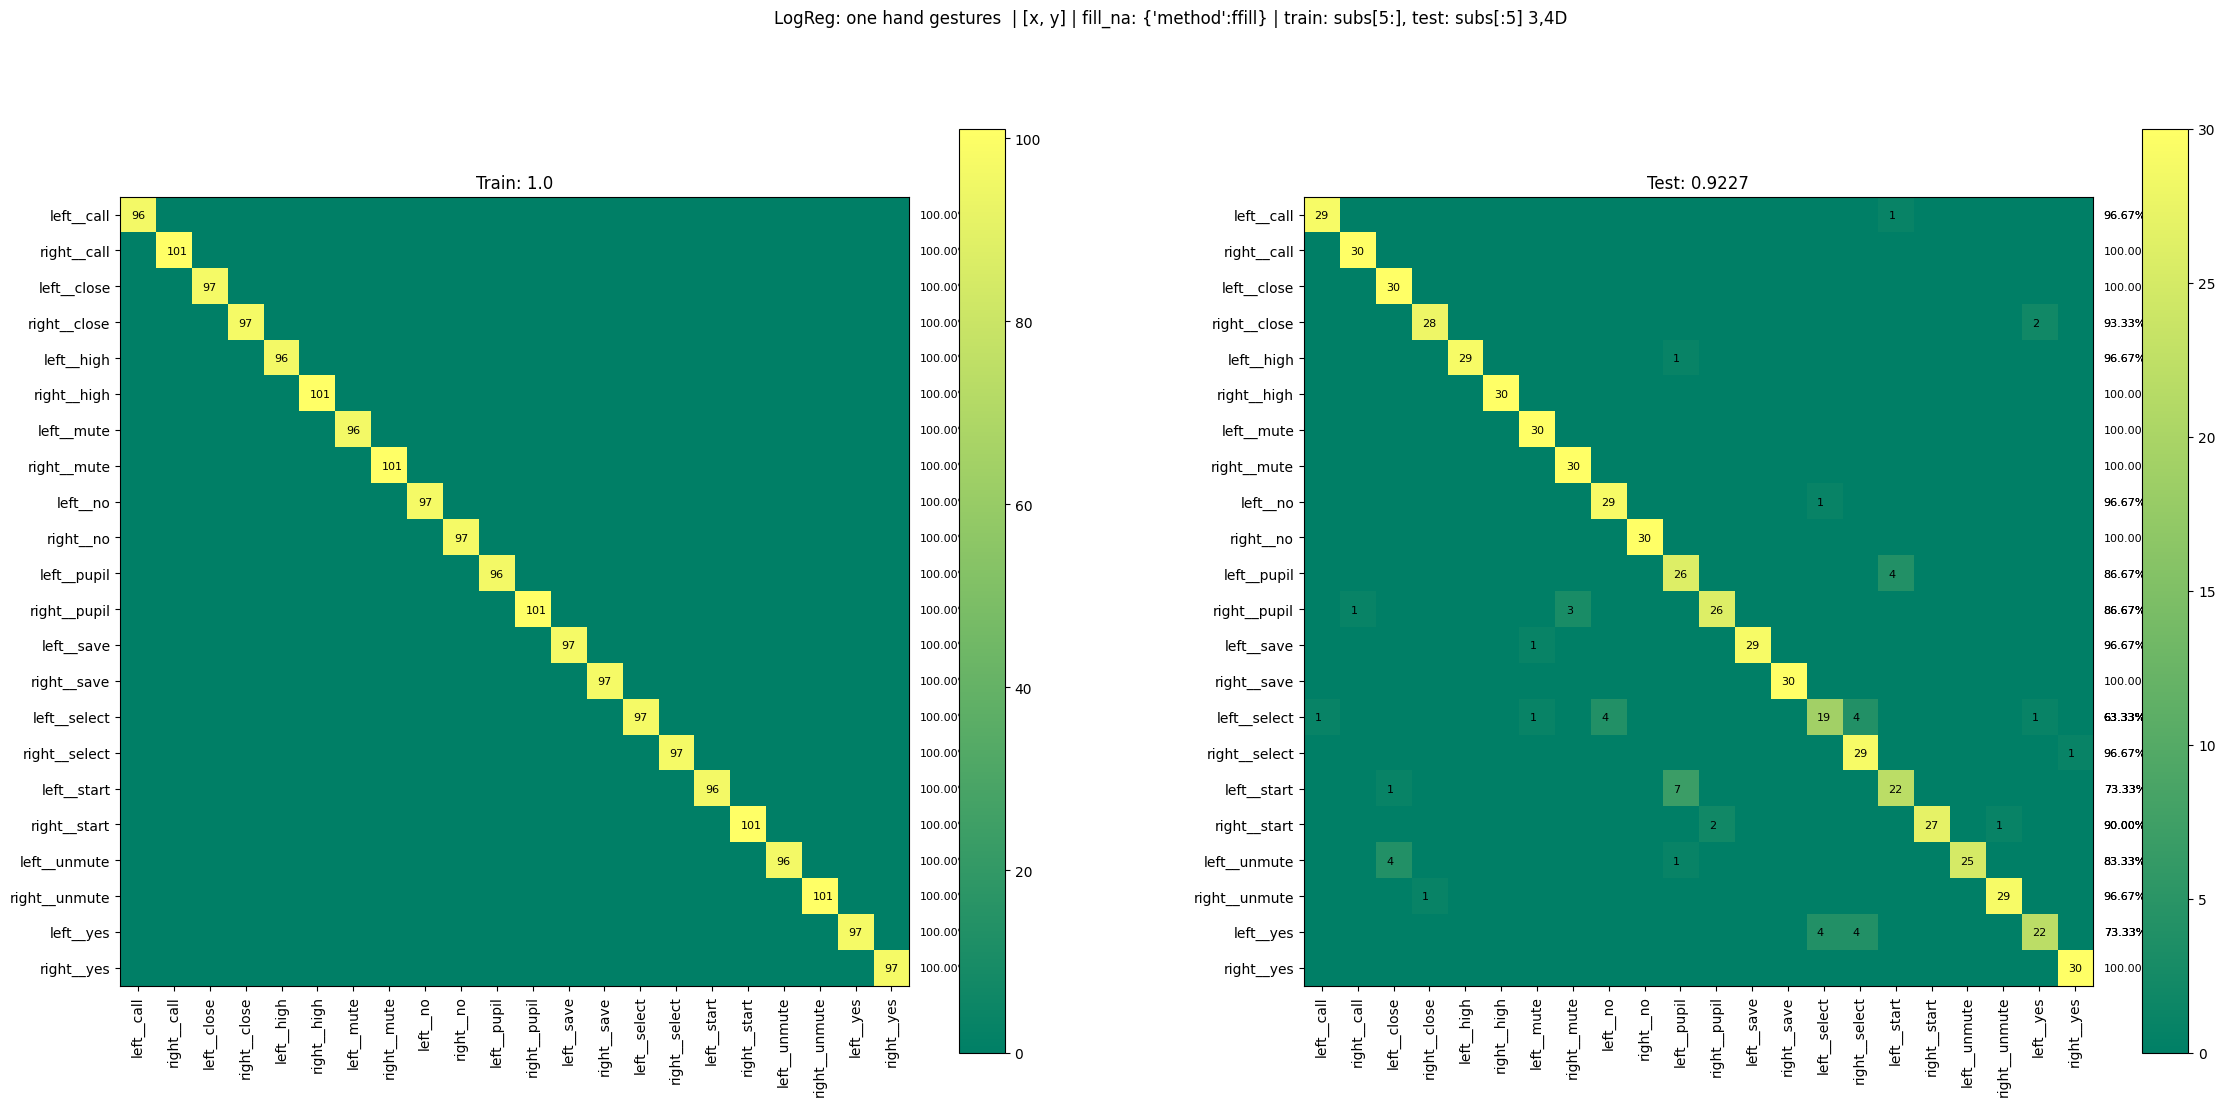

In [ ]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

In [ ]:
test_accuracy((model, model_name), tensor, tensor_test, labels_list, labels_list_test, True, n_trials=1)

For model: LogReg


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

Model fitting was skipped!


array([0.92272727])

##### Backup code

In [225]:
# model = LogisticRegression(max_iter=200)
# model_name = 'LogReg'
# X_train, y_train = make_X_y(tensor, labels_list)
# X_test, y_test = make_X_y(tensor_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

# model.fit(X_train, y_train)

In [70]:
# label = model.predict(X_test)
# acc = accuracy_score(y_test, label )
# print(acc)
# plot_confusion_matrix(y_test, label, label_dict)
# plt.title('Confusion Matrix: Test data')

#### RandomForest

In [66]:
model = RandomForestClassifier(n_estimators=200)
model_name = pref + 'RF'

model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test,
                                                                   labels_list, labels_list_test, do_scaler=False)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

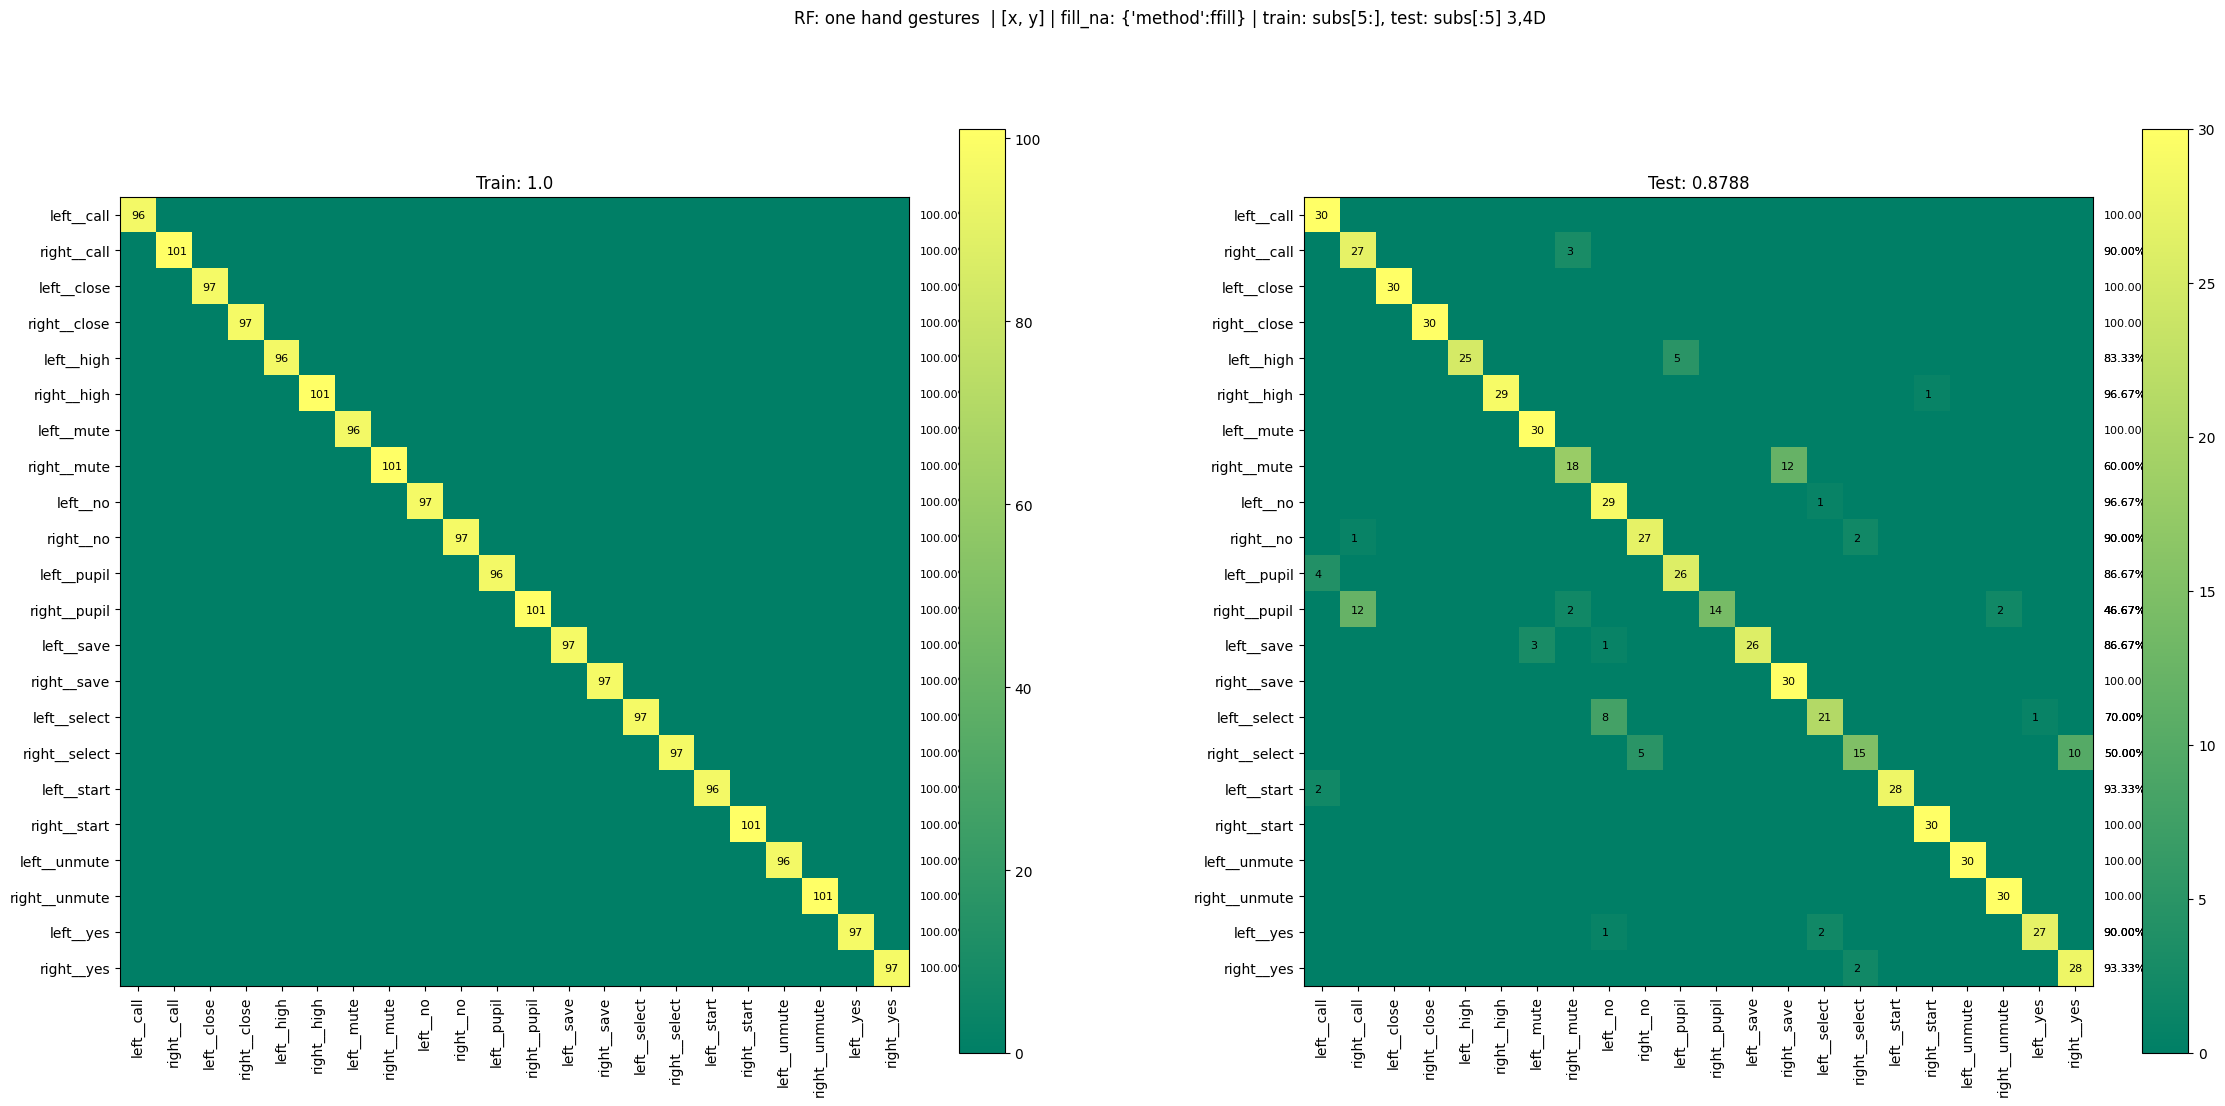

In [67]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

In [68]:
test_accuracy((model, model_name), tensor, tensor_test, labels_list, labels_list_test, False, n_trials=5)

For model: RF


100%|██████████| 5/5 [02:52<00:00, 34.42s/it]

Acc of RF: 87.85(0.48) %


array([0.87878788, 0.87121212, 0.87878788, 0.88636364, 0.87727273])

### other

#### XGBoost 

In [41]:
model = xgb.XGBClassifier(n_estimators=200)
model_name = pref + 'XGB'

model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test,
                                                                   labels_list, labels_list_test, do_scaler=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

2
2



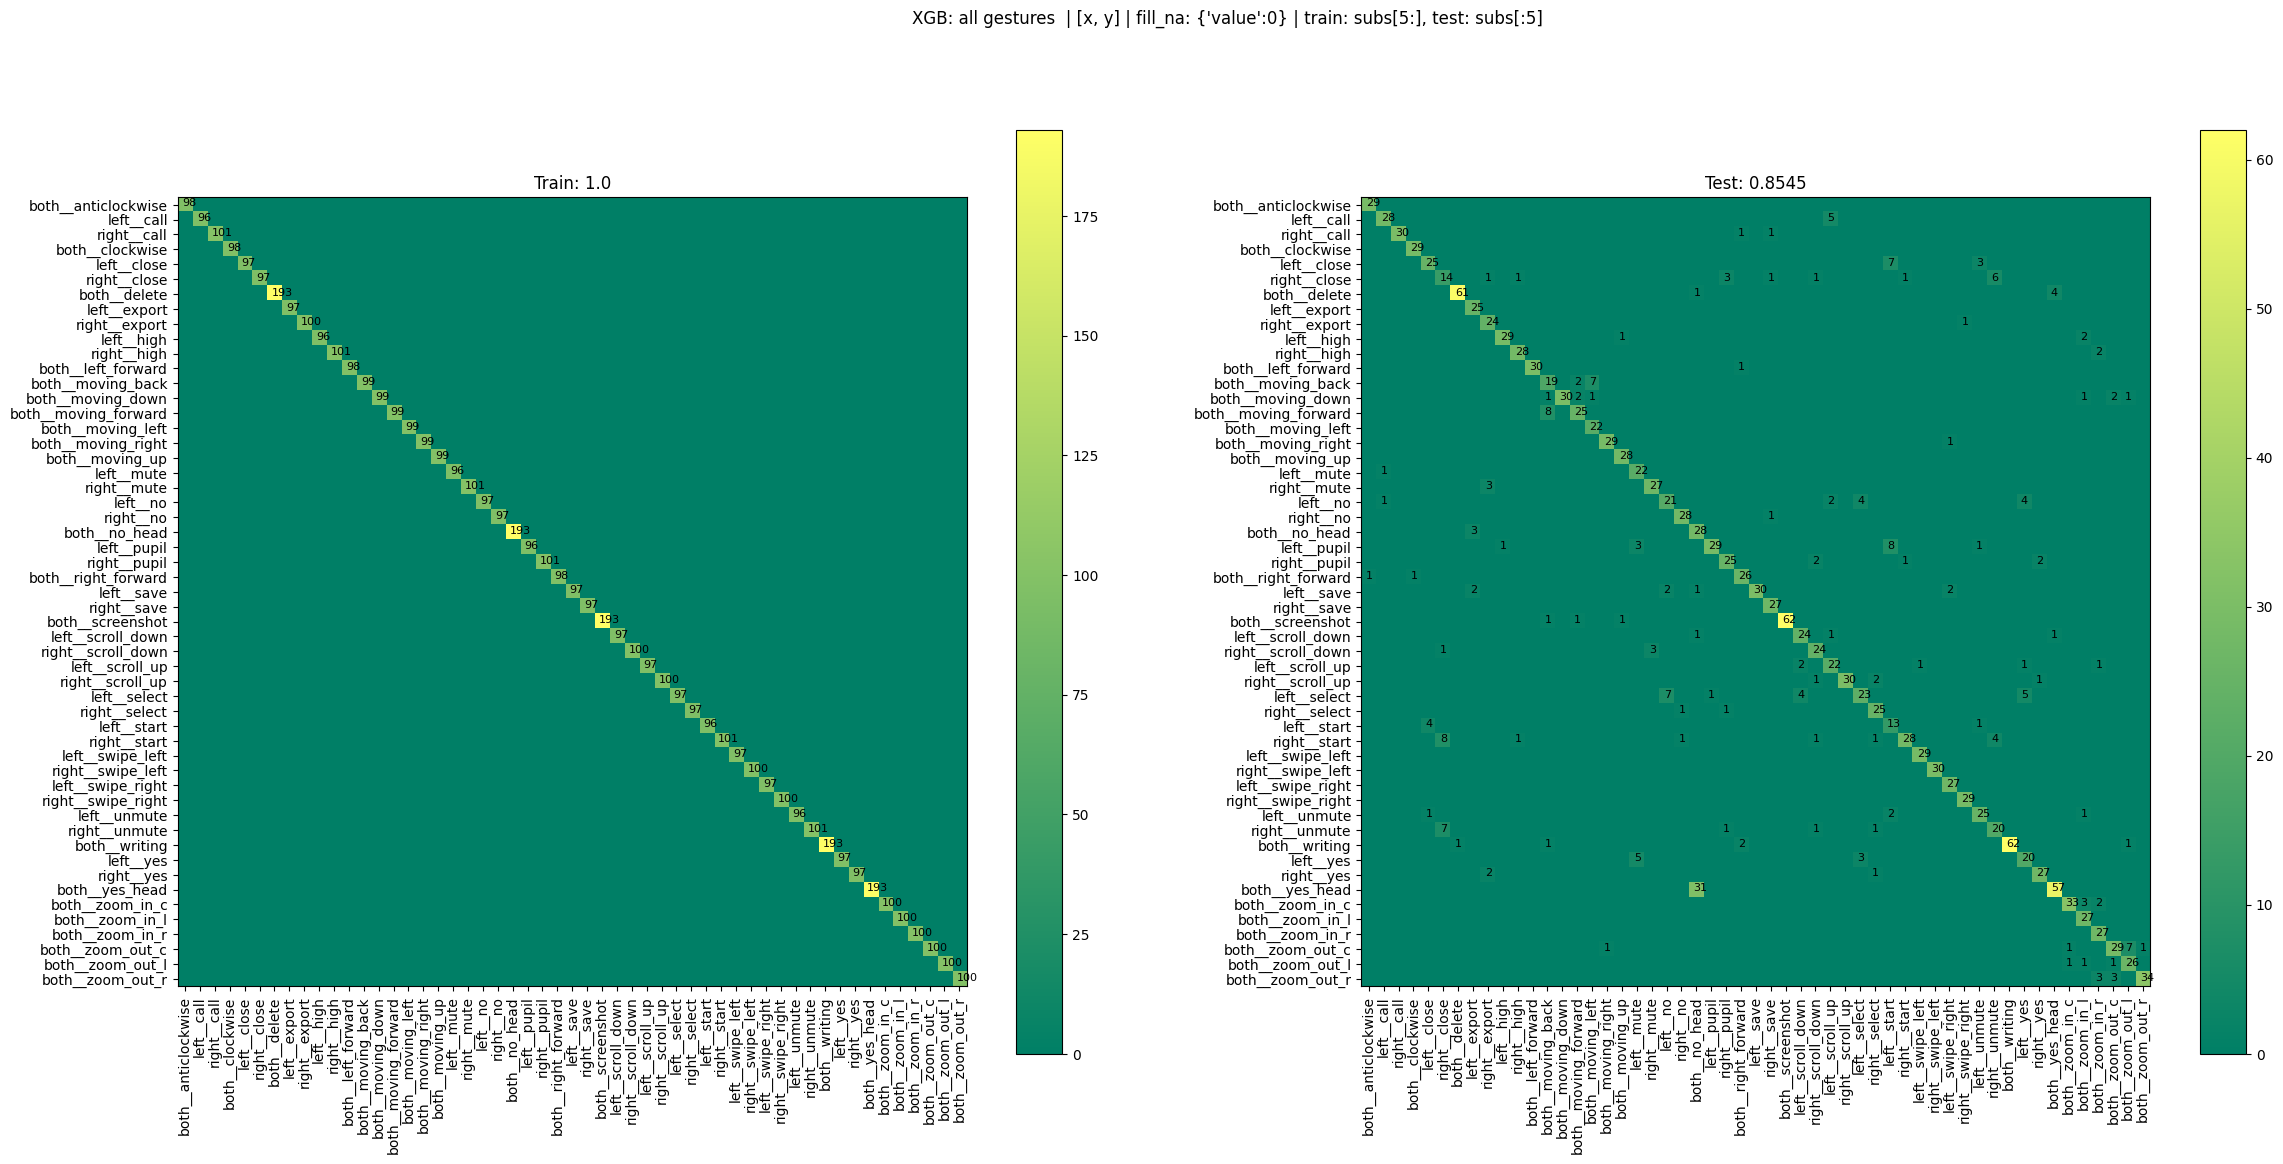

In [42]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

#### SVM

In [45]:
model = SVC(kernel='linear')
model_name = pref + 'SVC'

model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test,
                                                                   labels_list, labels_list_test, do_scaler=False)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

SVC(kernel='linear')

2
2



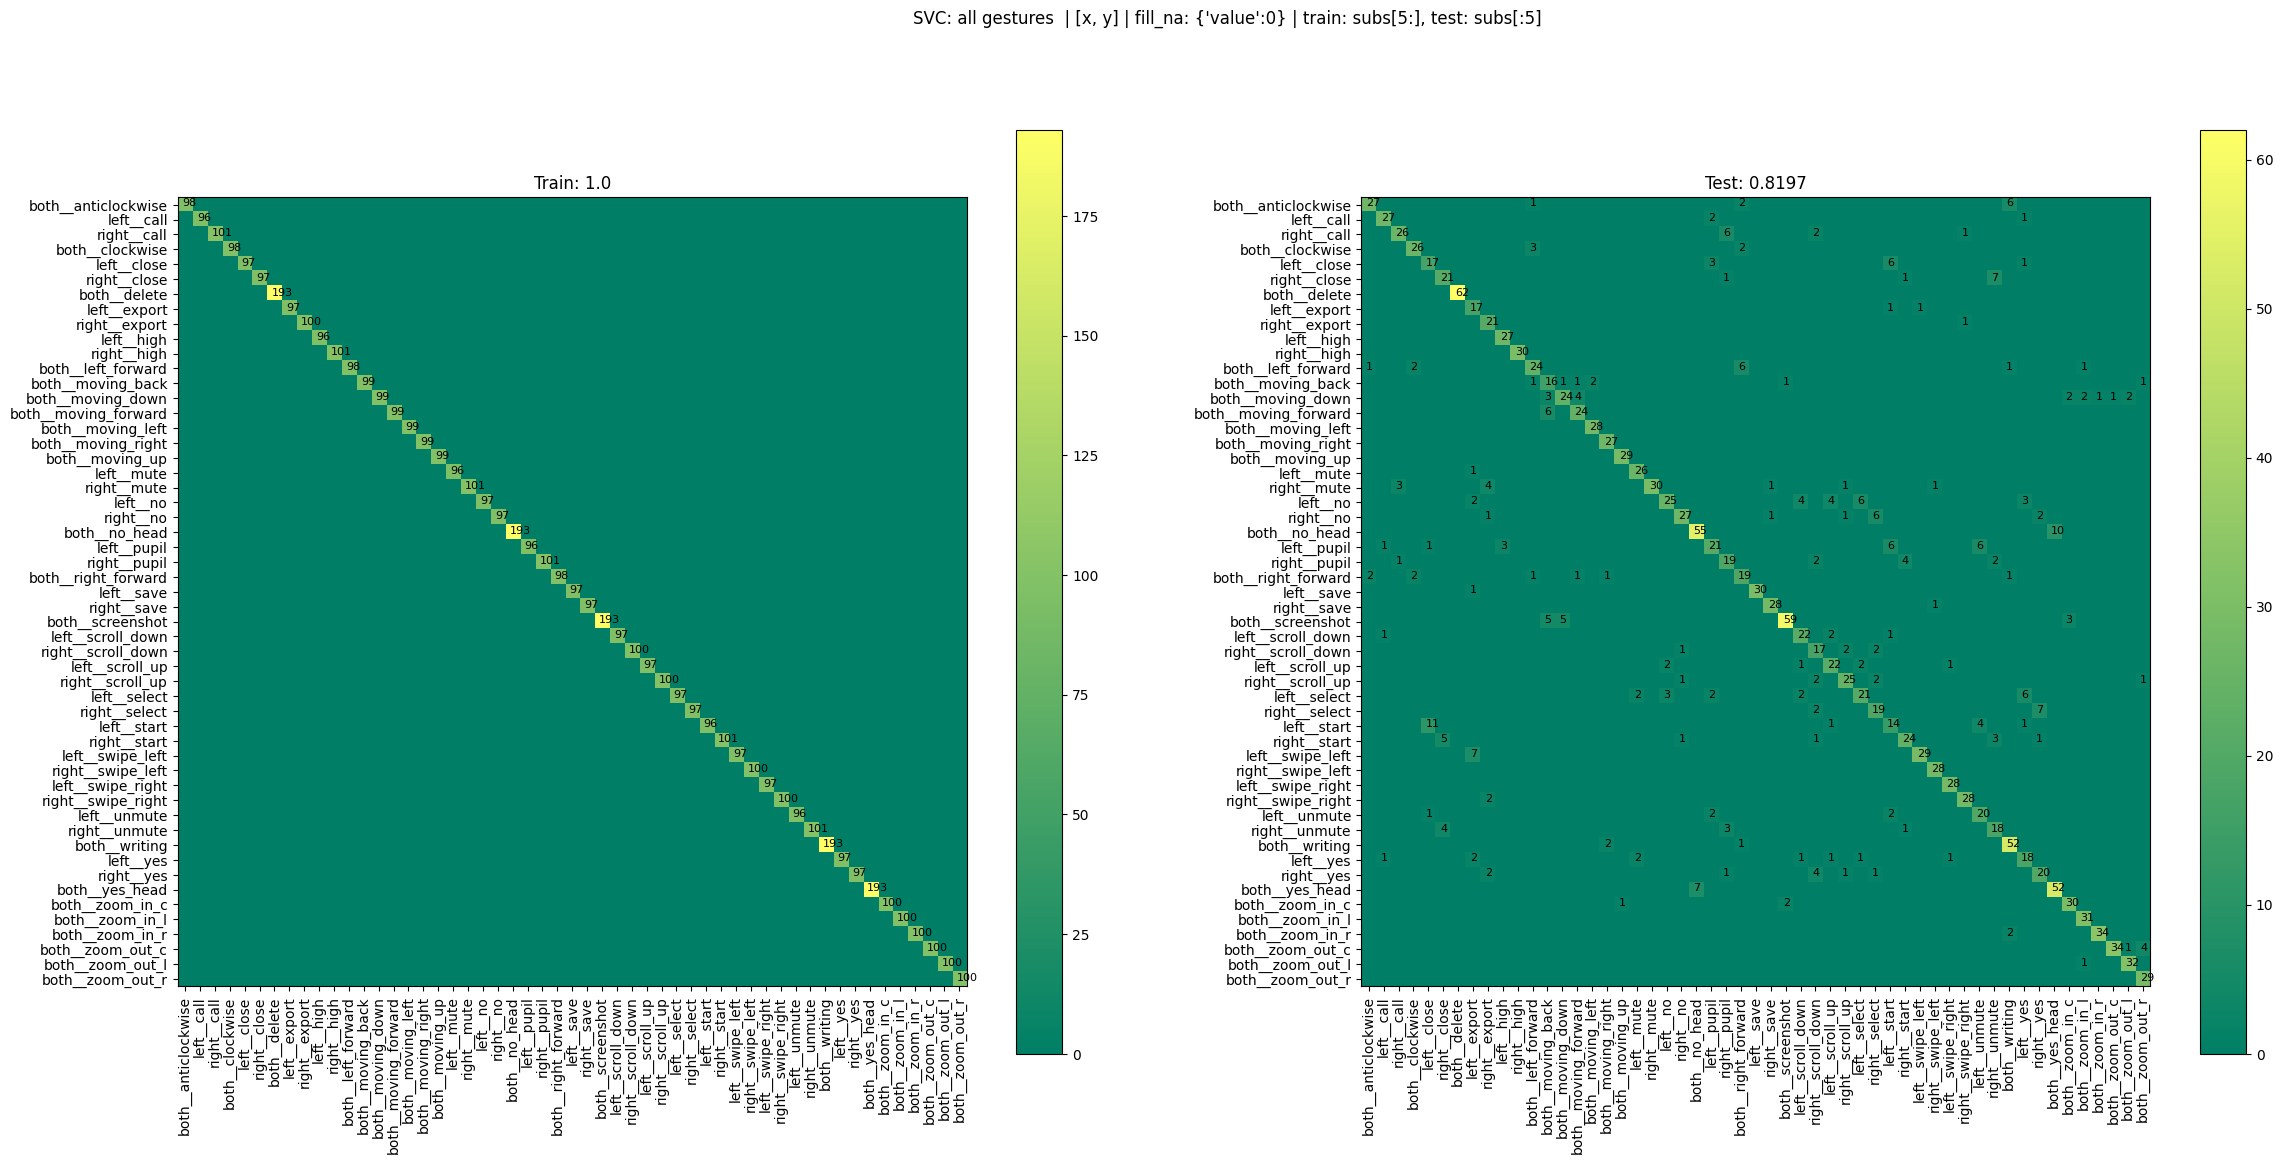

In [46]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

#### STM

In [58]:
model = pystmm.classifier.STMM(maxIter=2, tolSTM=1e-2, tol=1e-2)
model_name = pref + 'STM'

model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test,
                                                                   labels_list, labels_list_test, do_scaler=False)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

maxIter  2
ovr 1.0 1.0 2 0.01 l2 True 0.01 squared_hinge 100000
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


STMM(maxIter=2, tol=0.01, tolSTM=0.01)

2
2



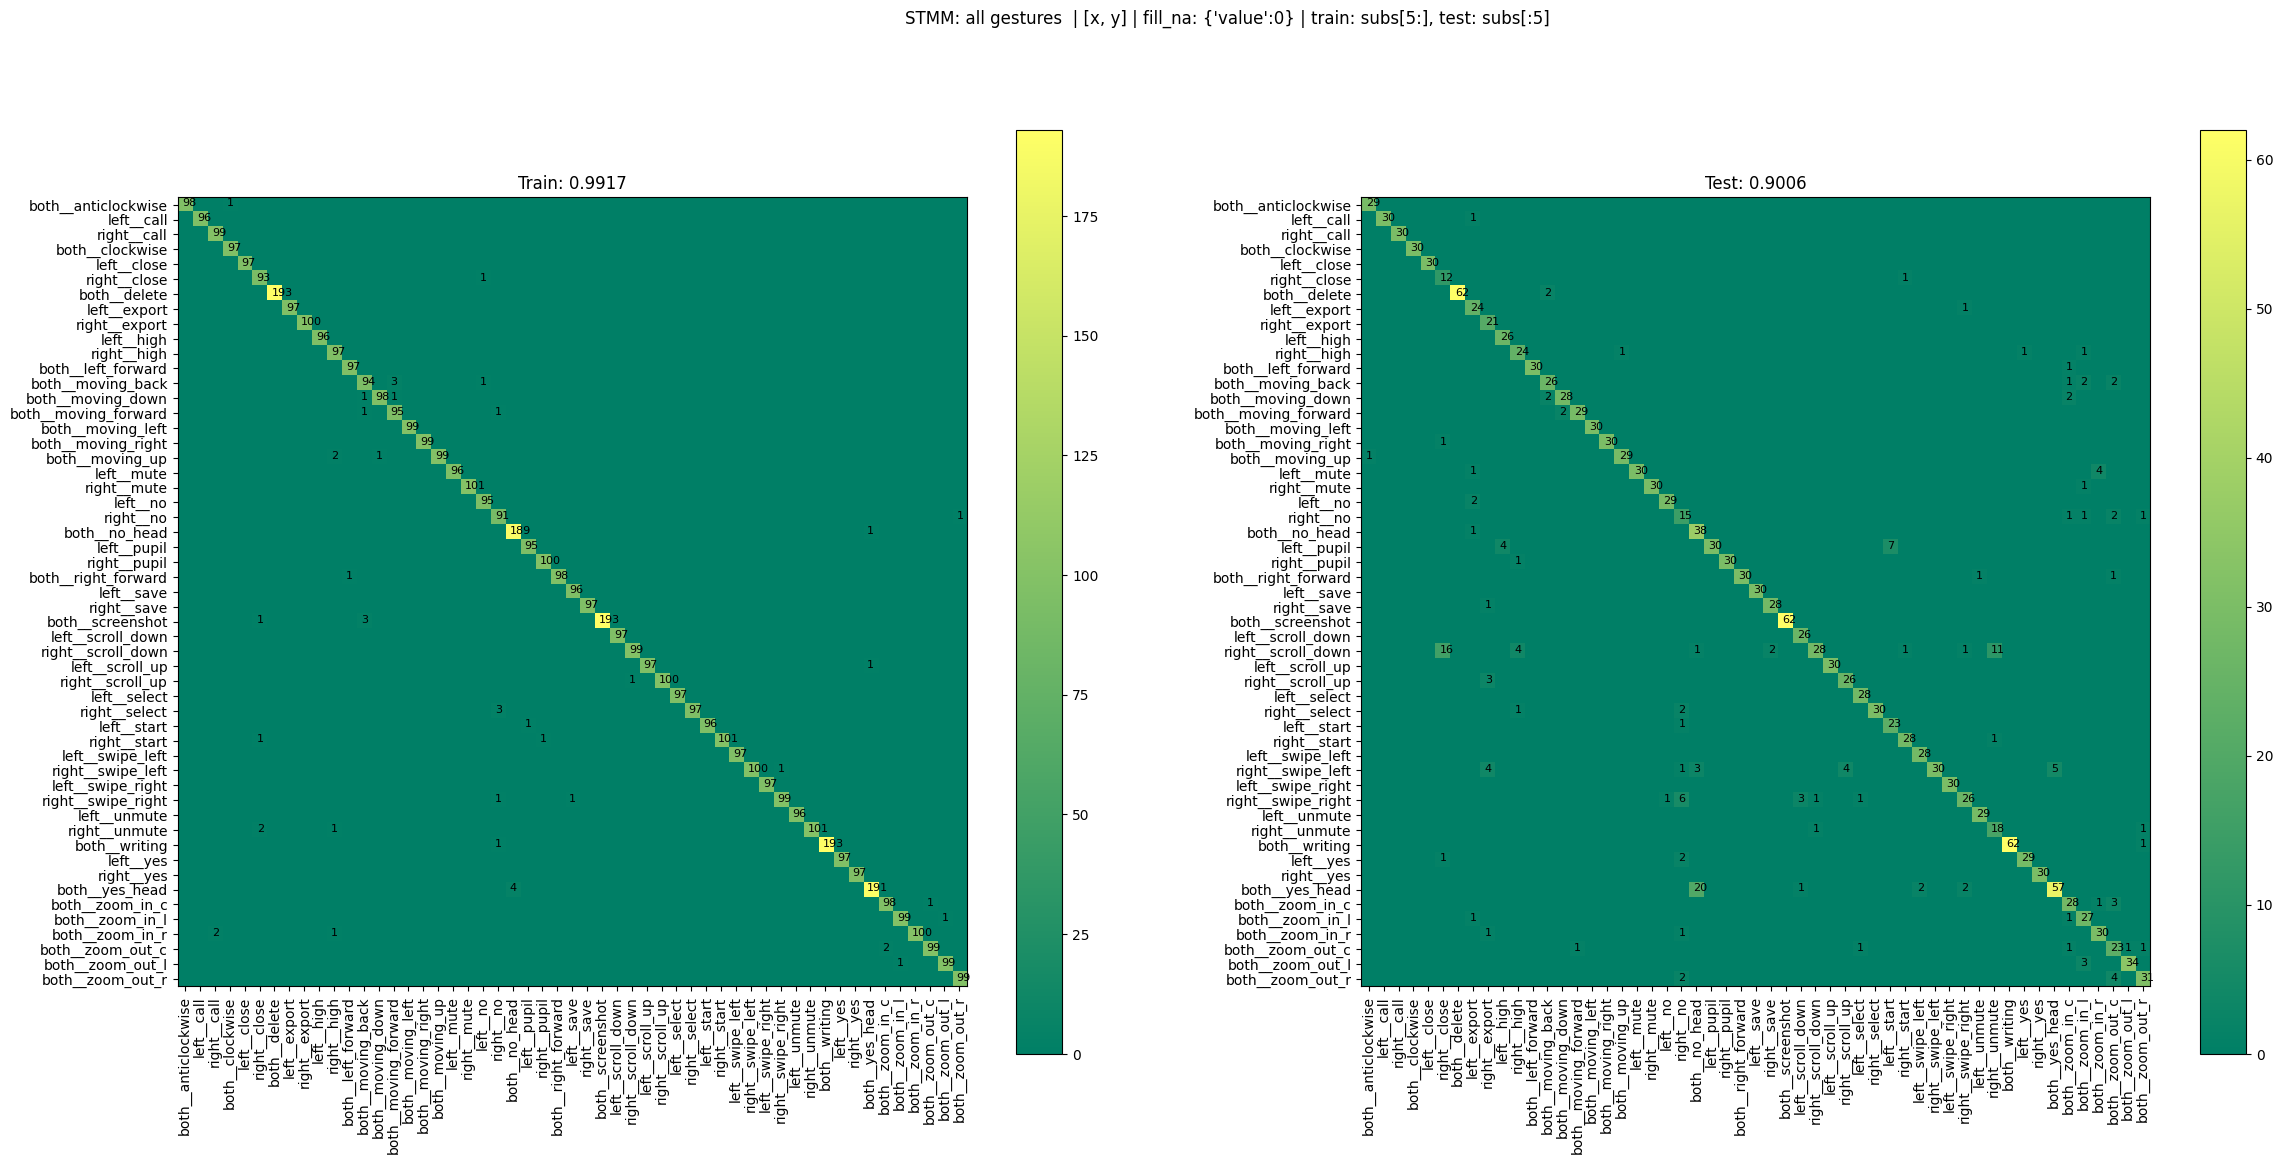

In [59]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

#### KNN

In [73]:
model = KNeighborsClassifier(n_neighbors=8)
model_name = pref + 'KNN'

model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test,
                                                                   labels_list, labels_list_test, do_scaler=False)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

KNeighborsClassifier(n_neighbors=8)

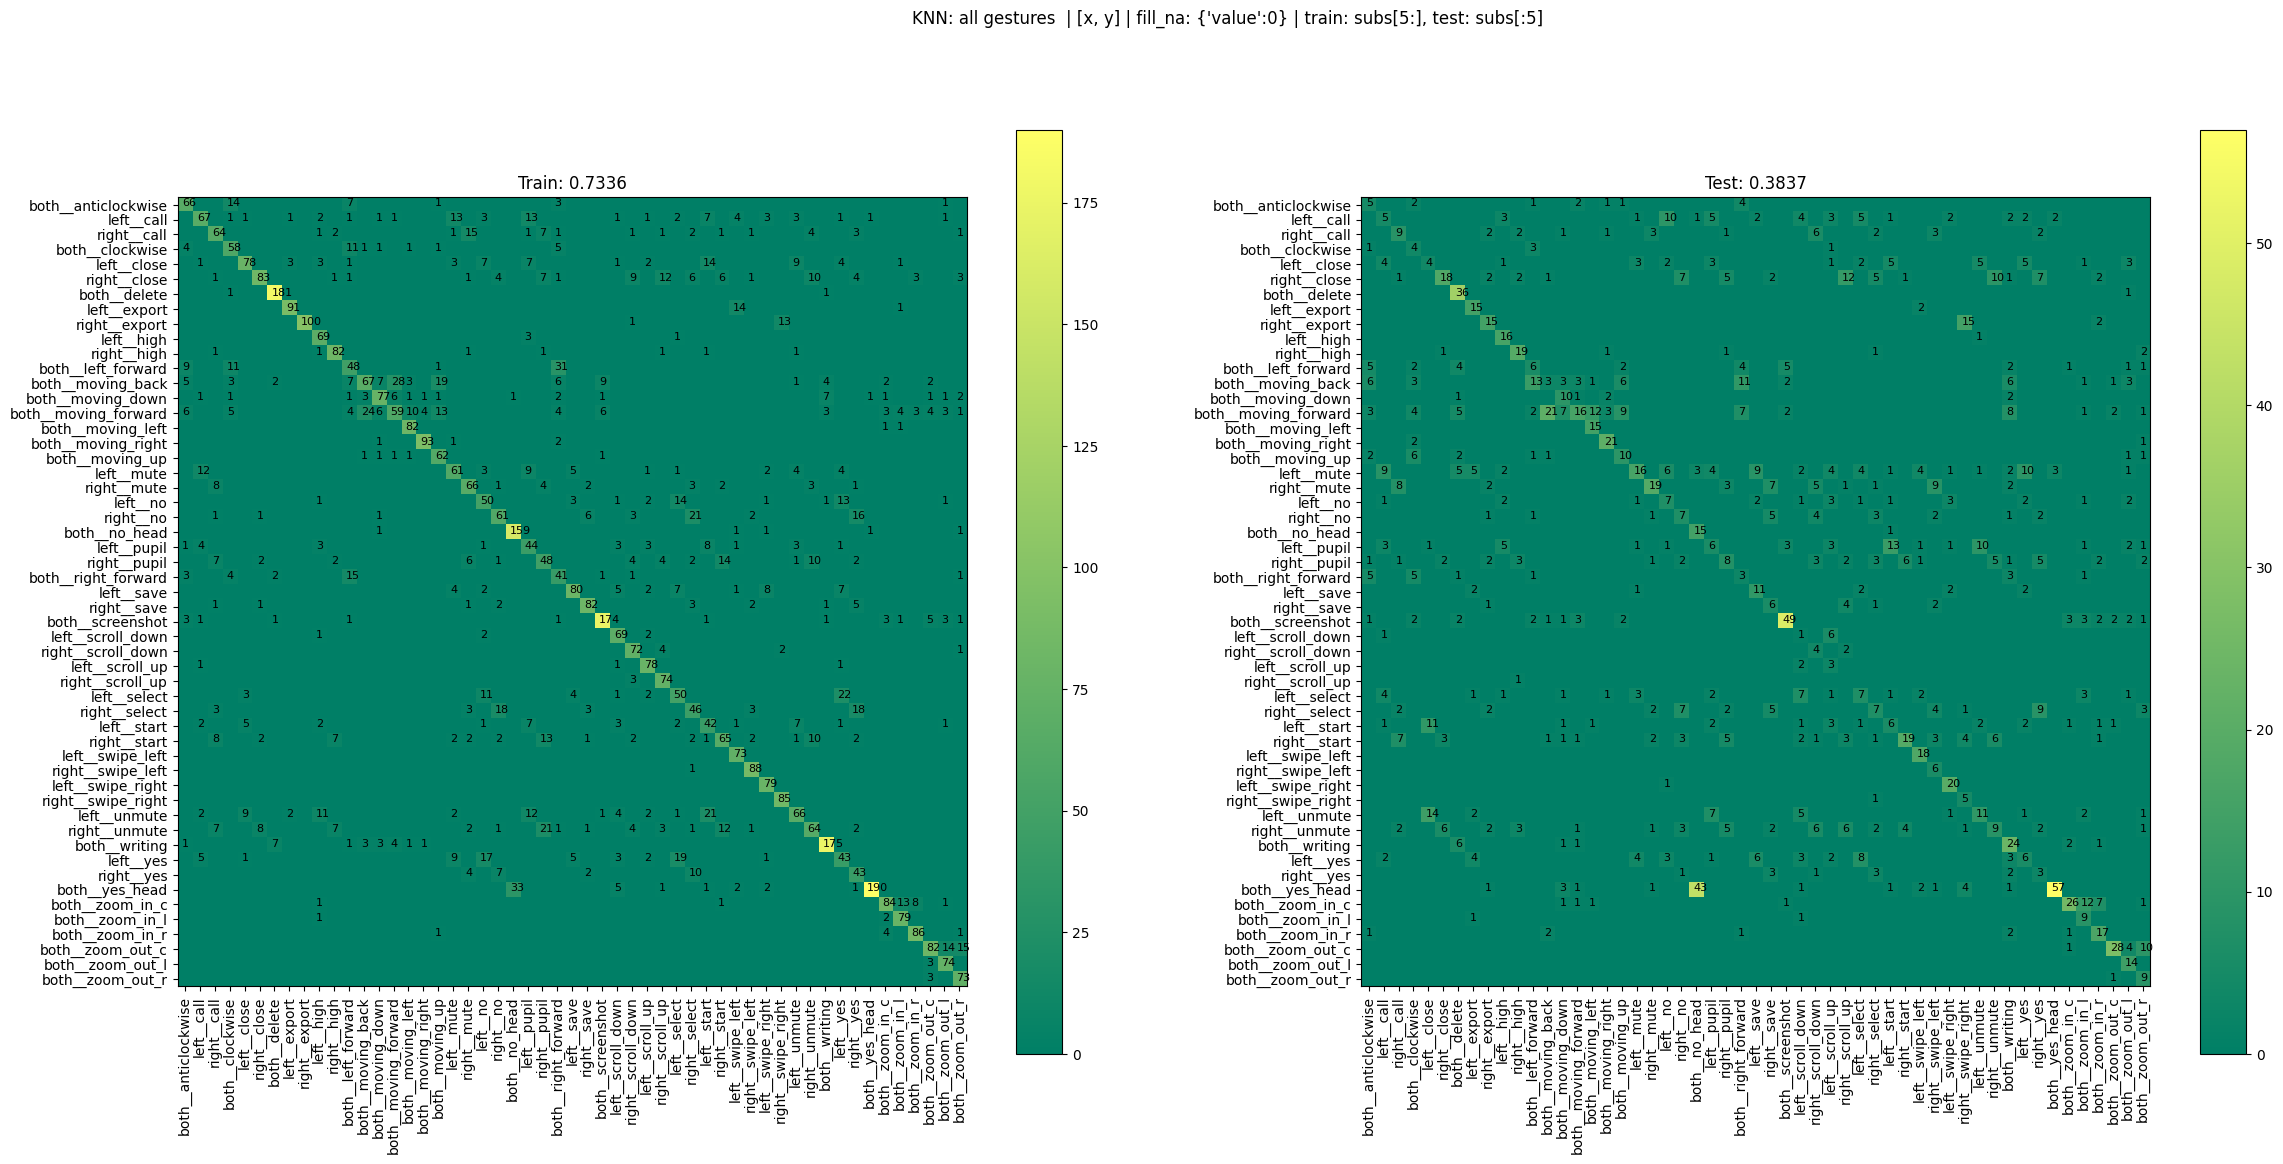

In [74]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

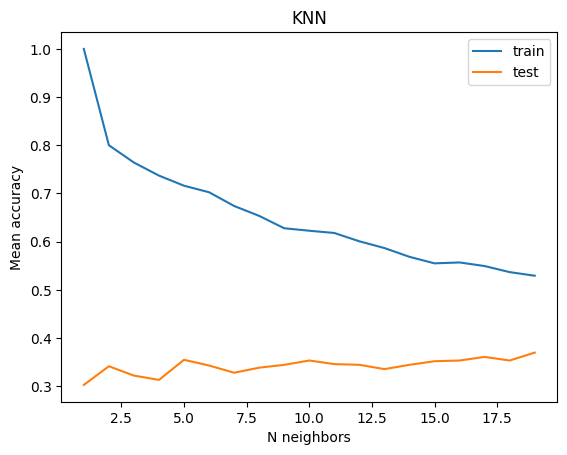

In [306]:
check_KNN(X_train, y_train, X_test, y_test, model_name)

## After SVD or PCA

In [116]:
# tensor = matrix_SVD
# tensor_test = matrix_SVD_test
# pref = 'SVD+'

tensor = matrix_PCA
tensor_test = matrix_PCA_test
pref = 'PCA+'



#### LogReg

In [112]:
model = LogisticRegression(max_iter=1000, C=1, solver='lbfgs', class_weight='balanced')
model_name = 'LogReg'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

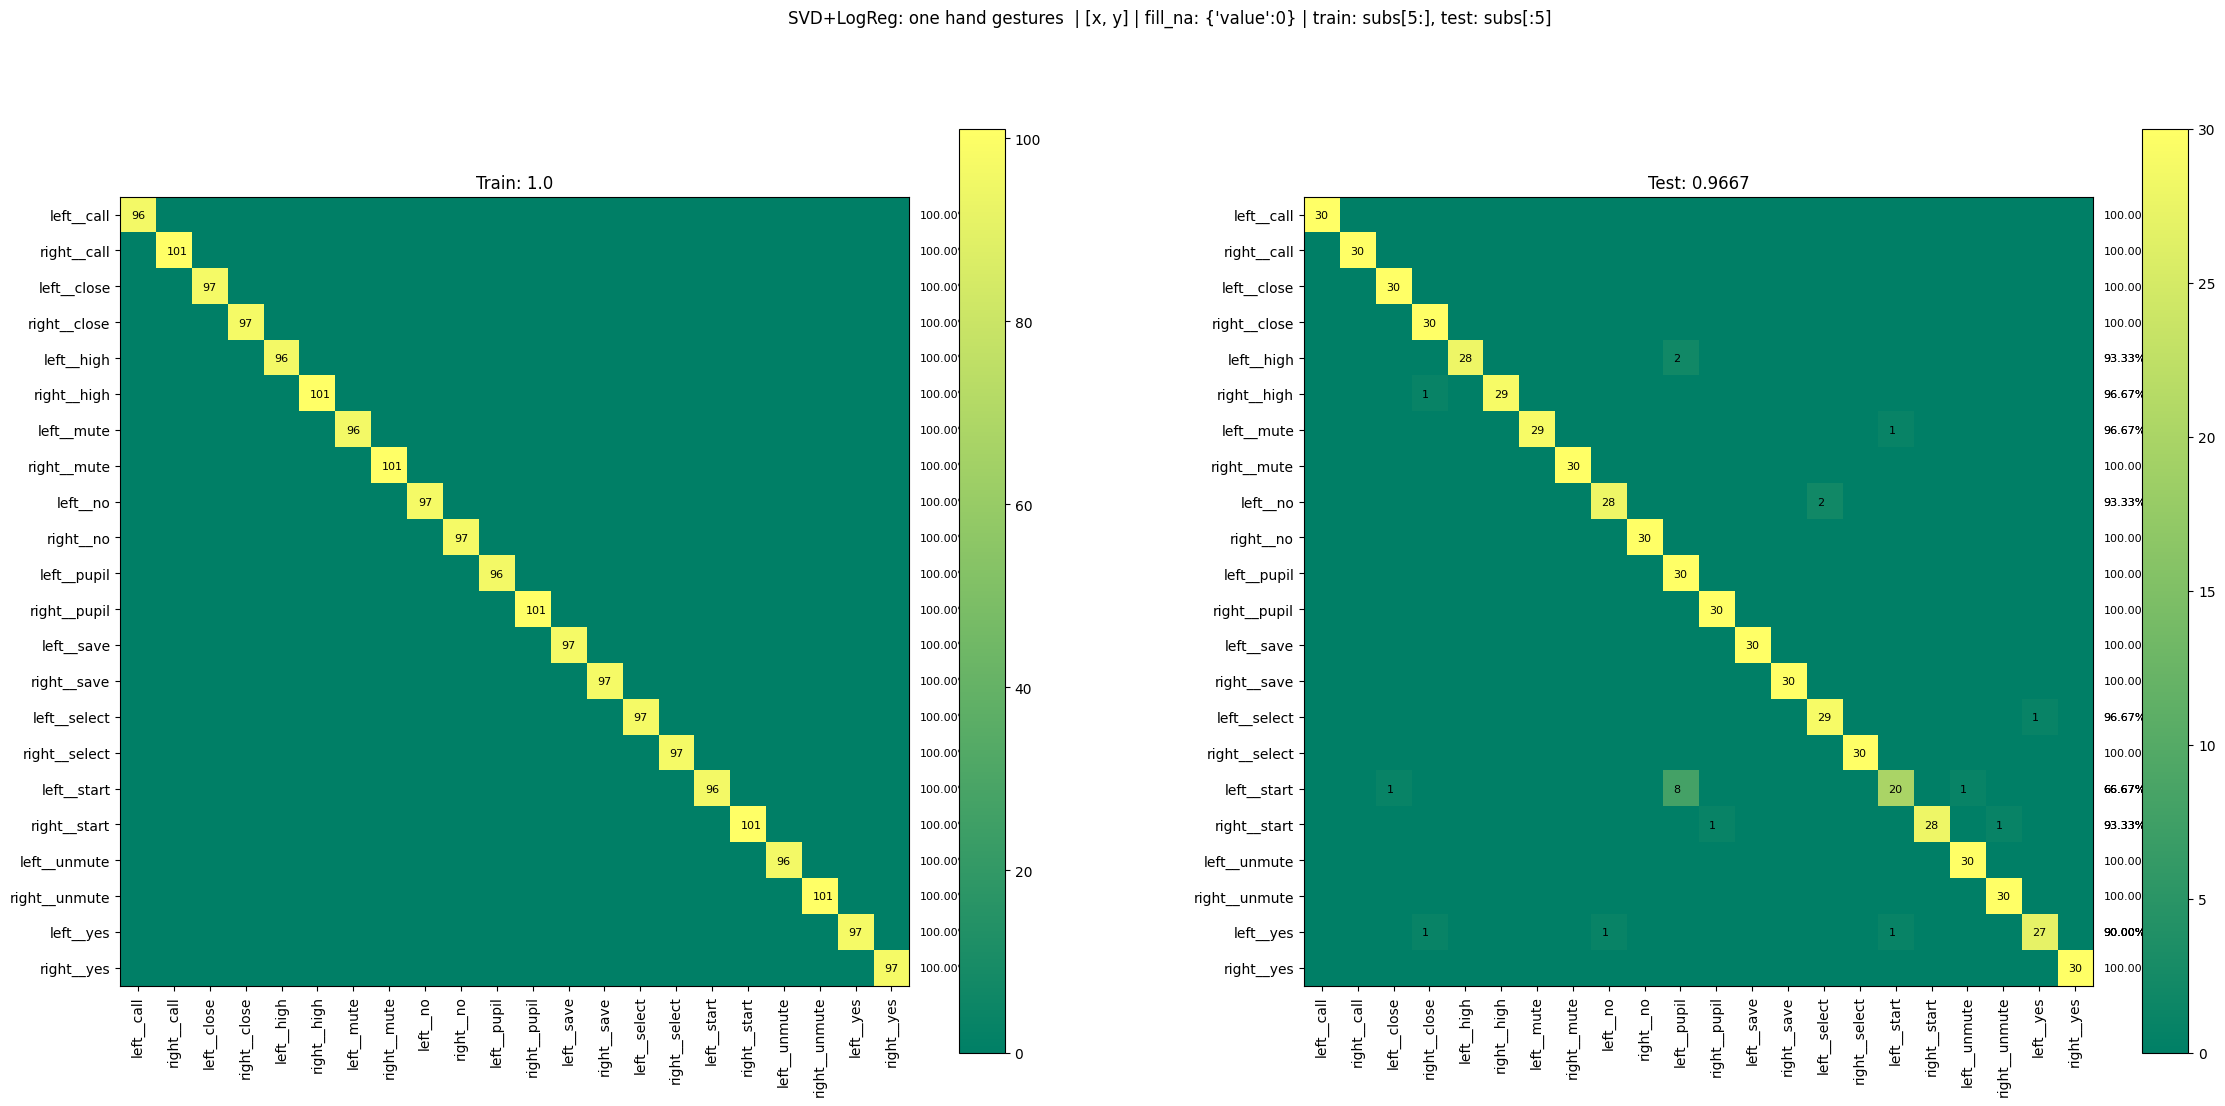

In [113]:
check_model(model, pref + model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

#### Random Forest

In [117]:
model = RandomForestClassifier(n_estimators=200)
model_name = 'RF'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

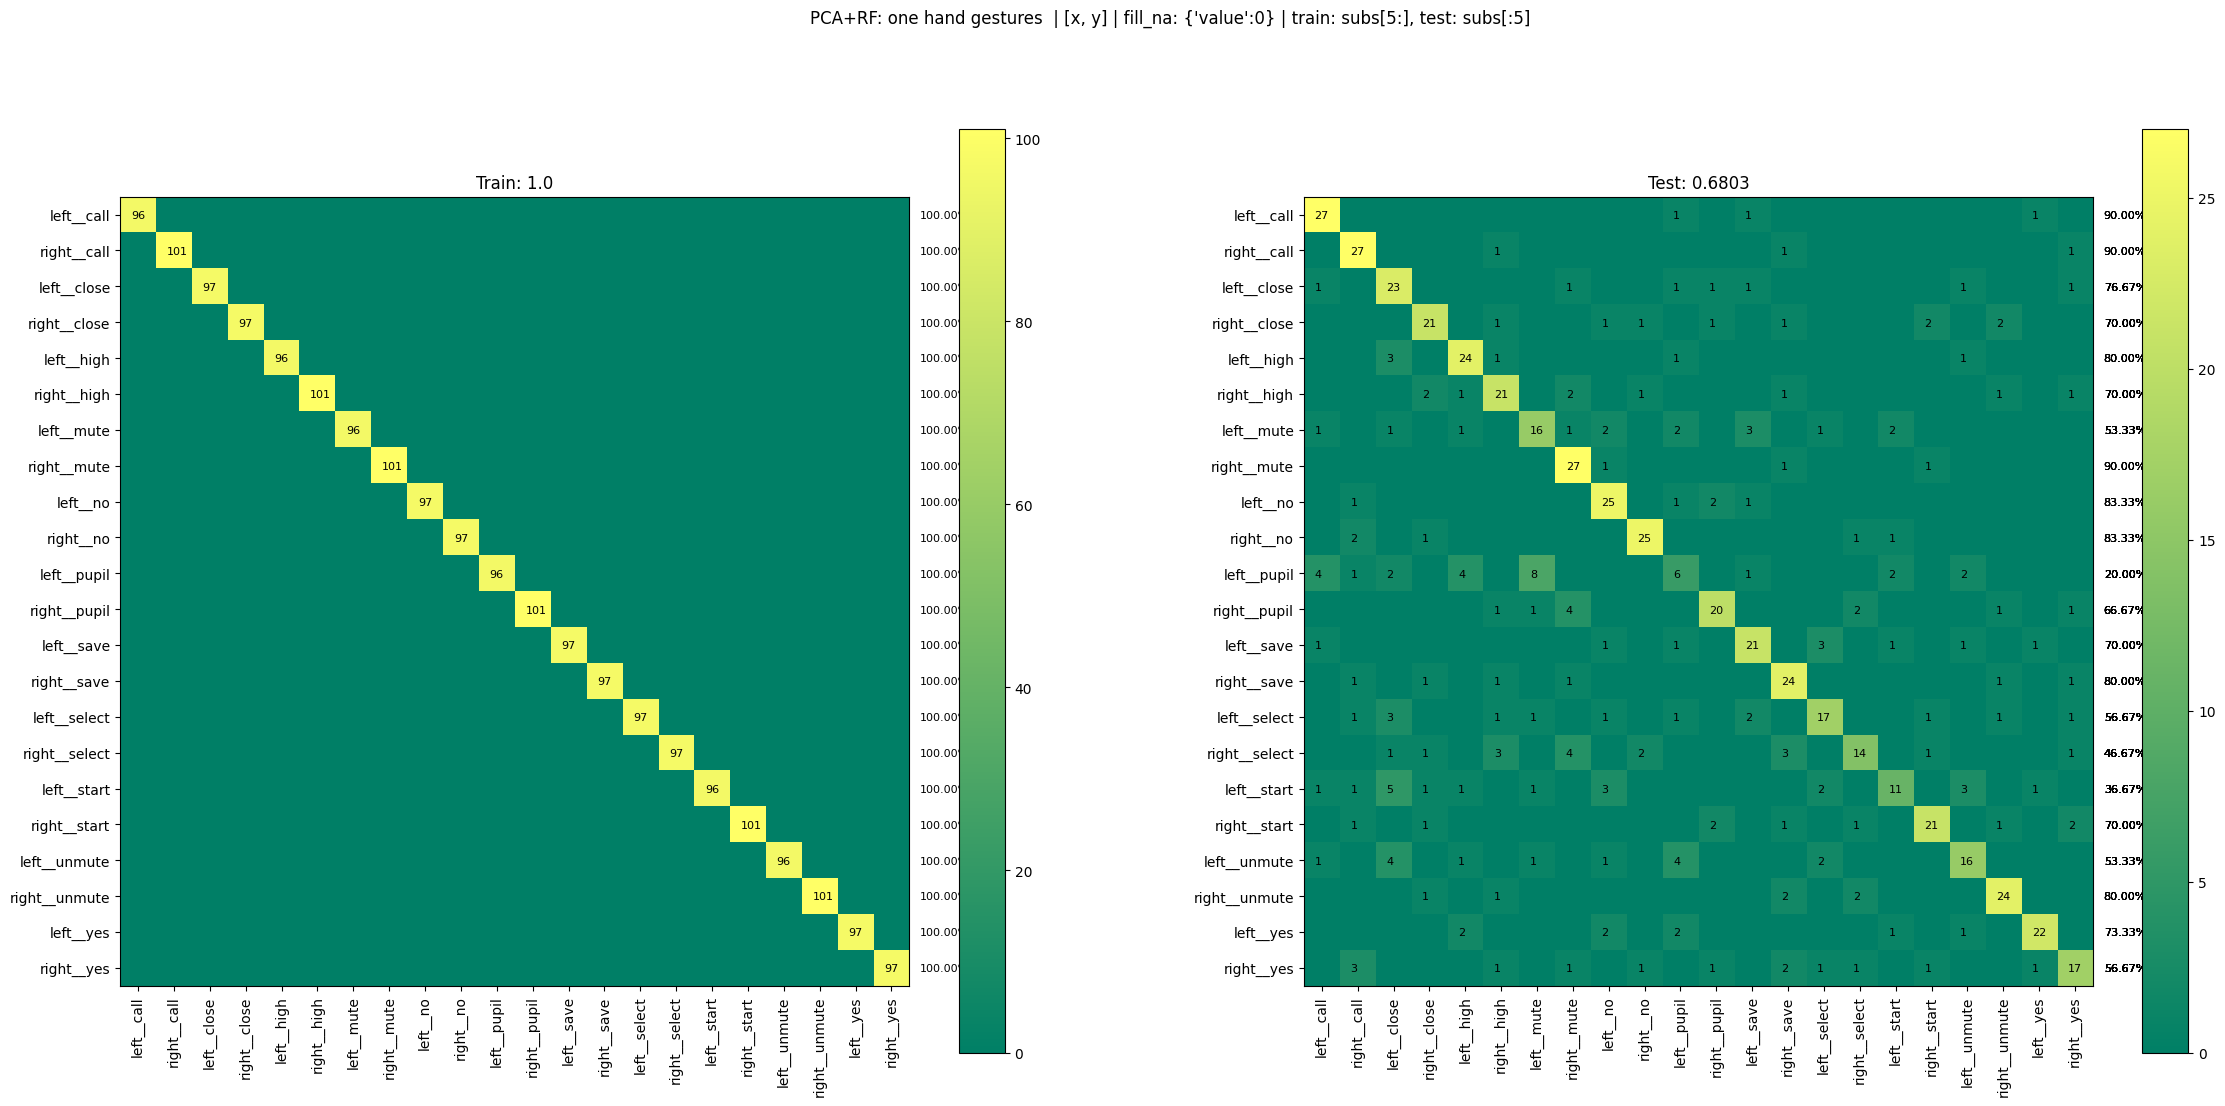

In [118]:
check_model(model, pref + model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

### other

#### XGBoost

In [60]:
model = xgb.XGBClassifier(n_estimators=300)
model_name = 'XGB'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

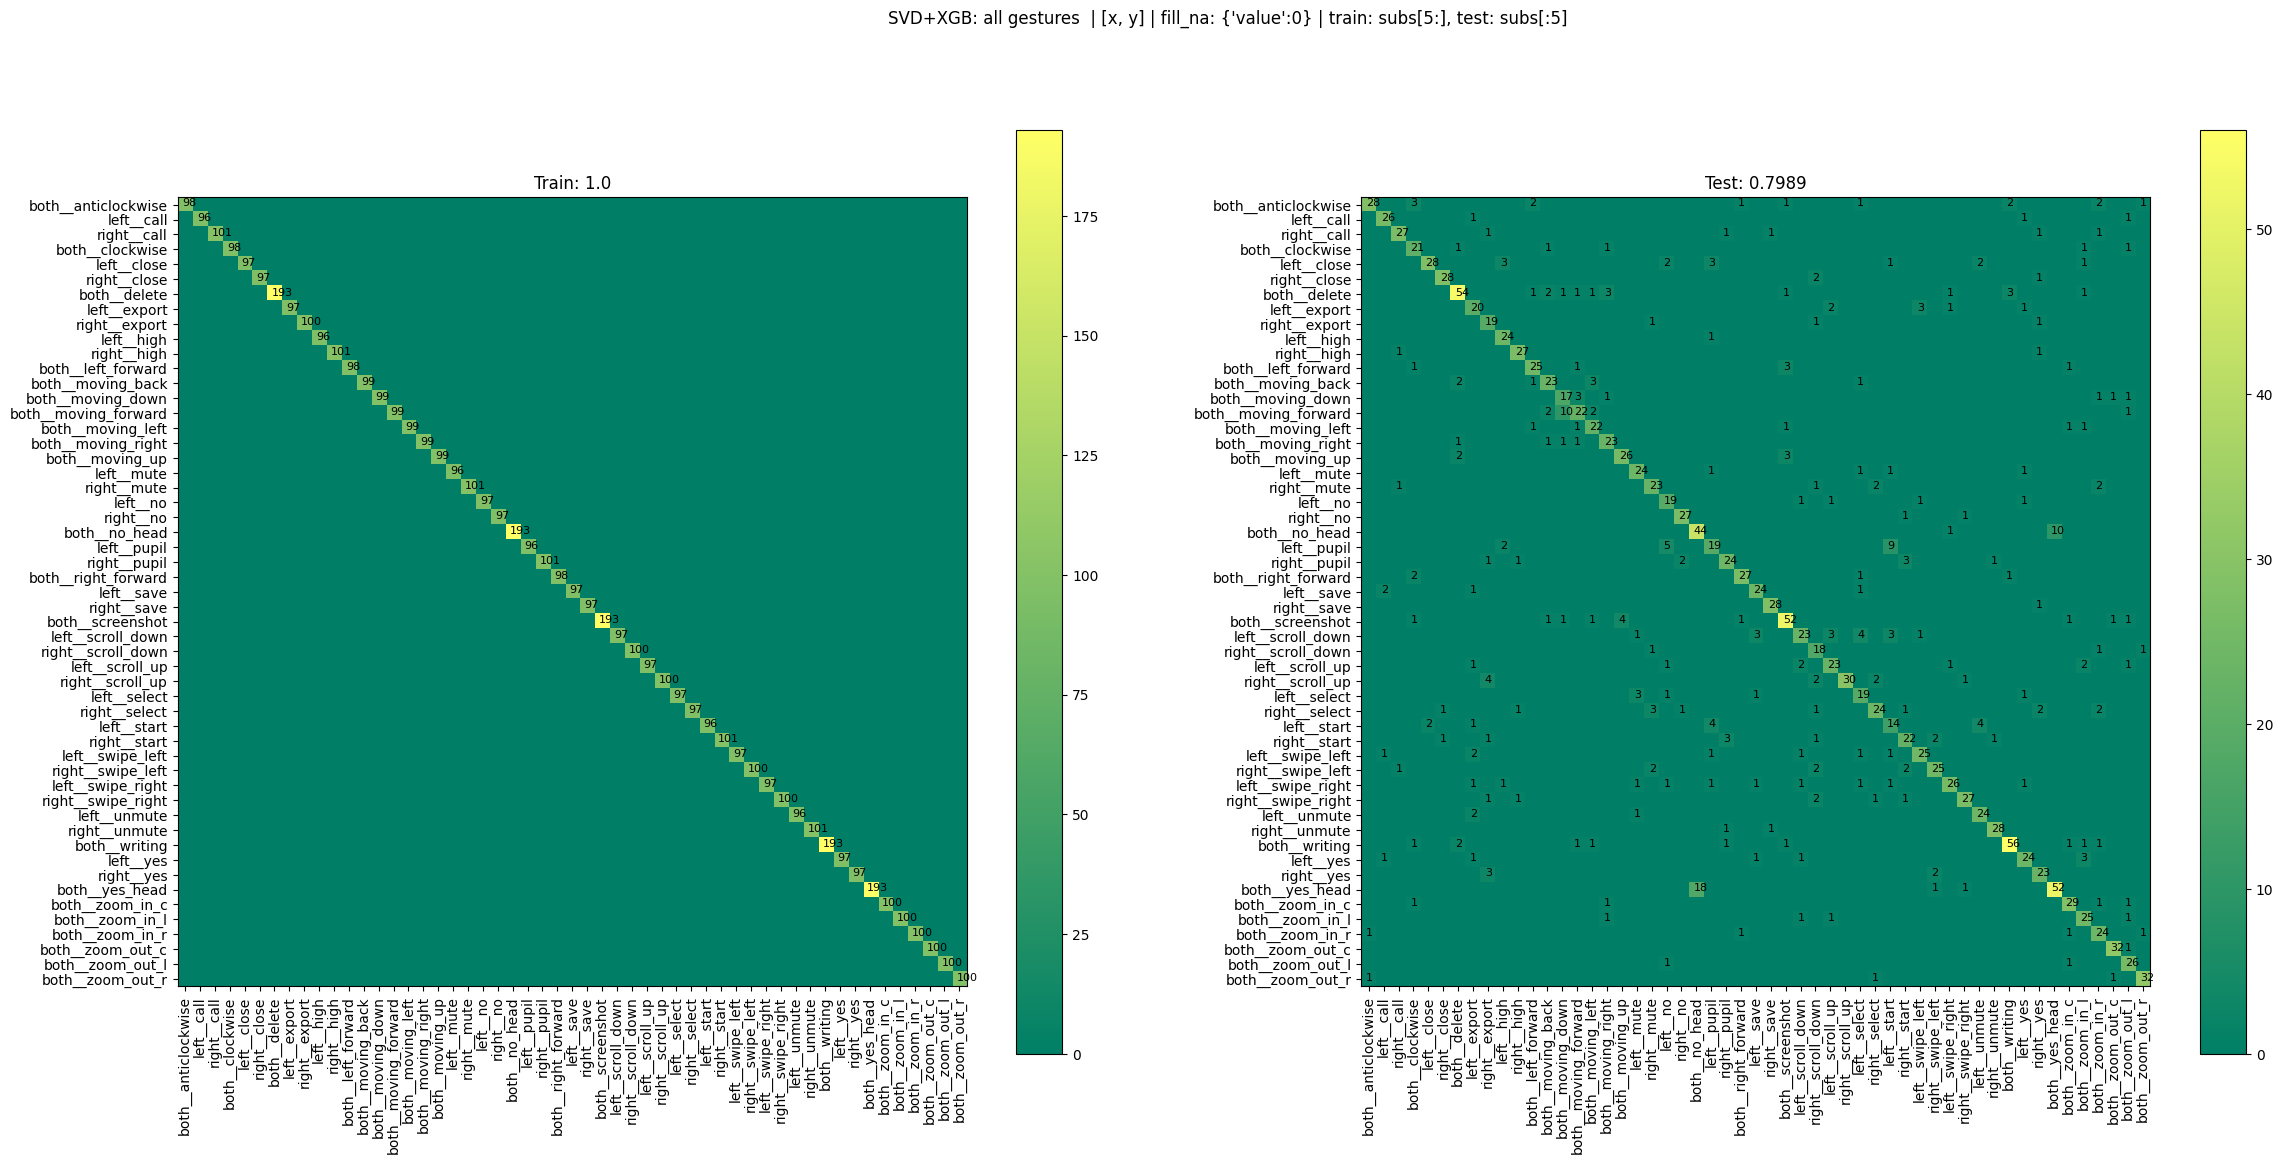

In [61]:
check_model(model, pref + model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

#### SVM

In [62]:
model = SVC(kernel='linear')
model_name = 'SVC'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

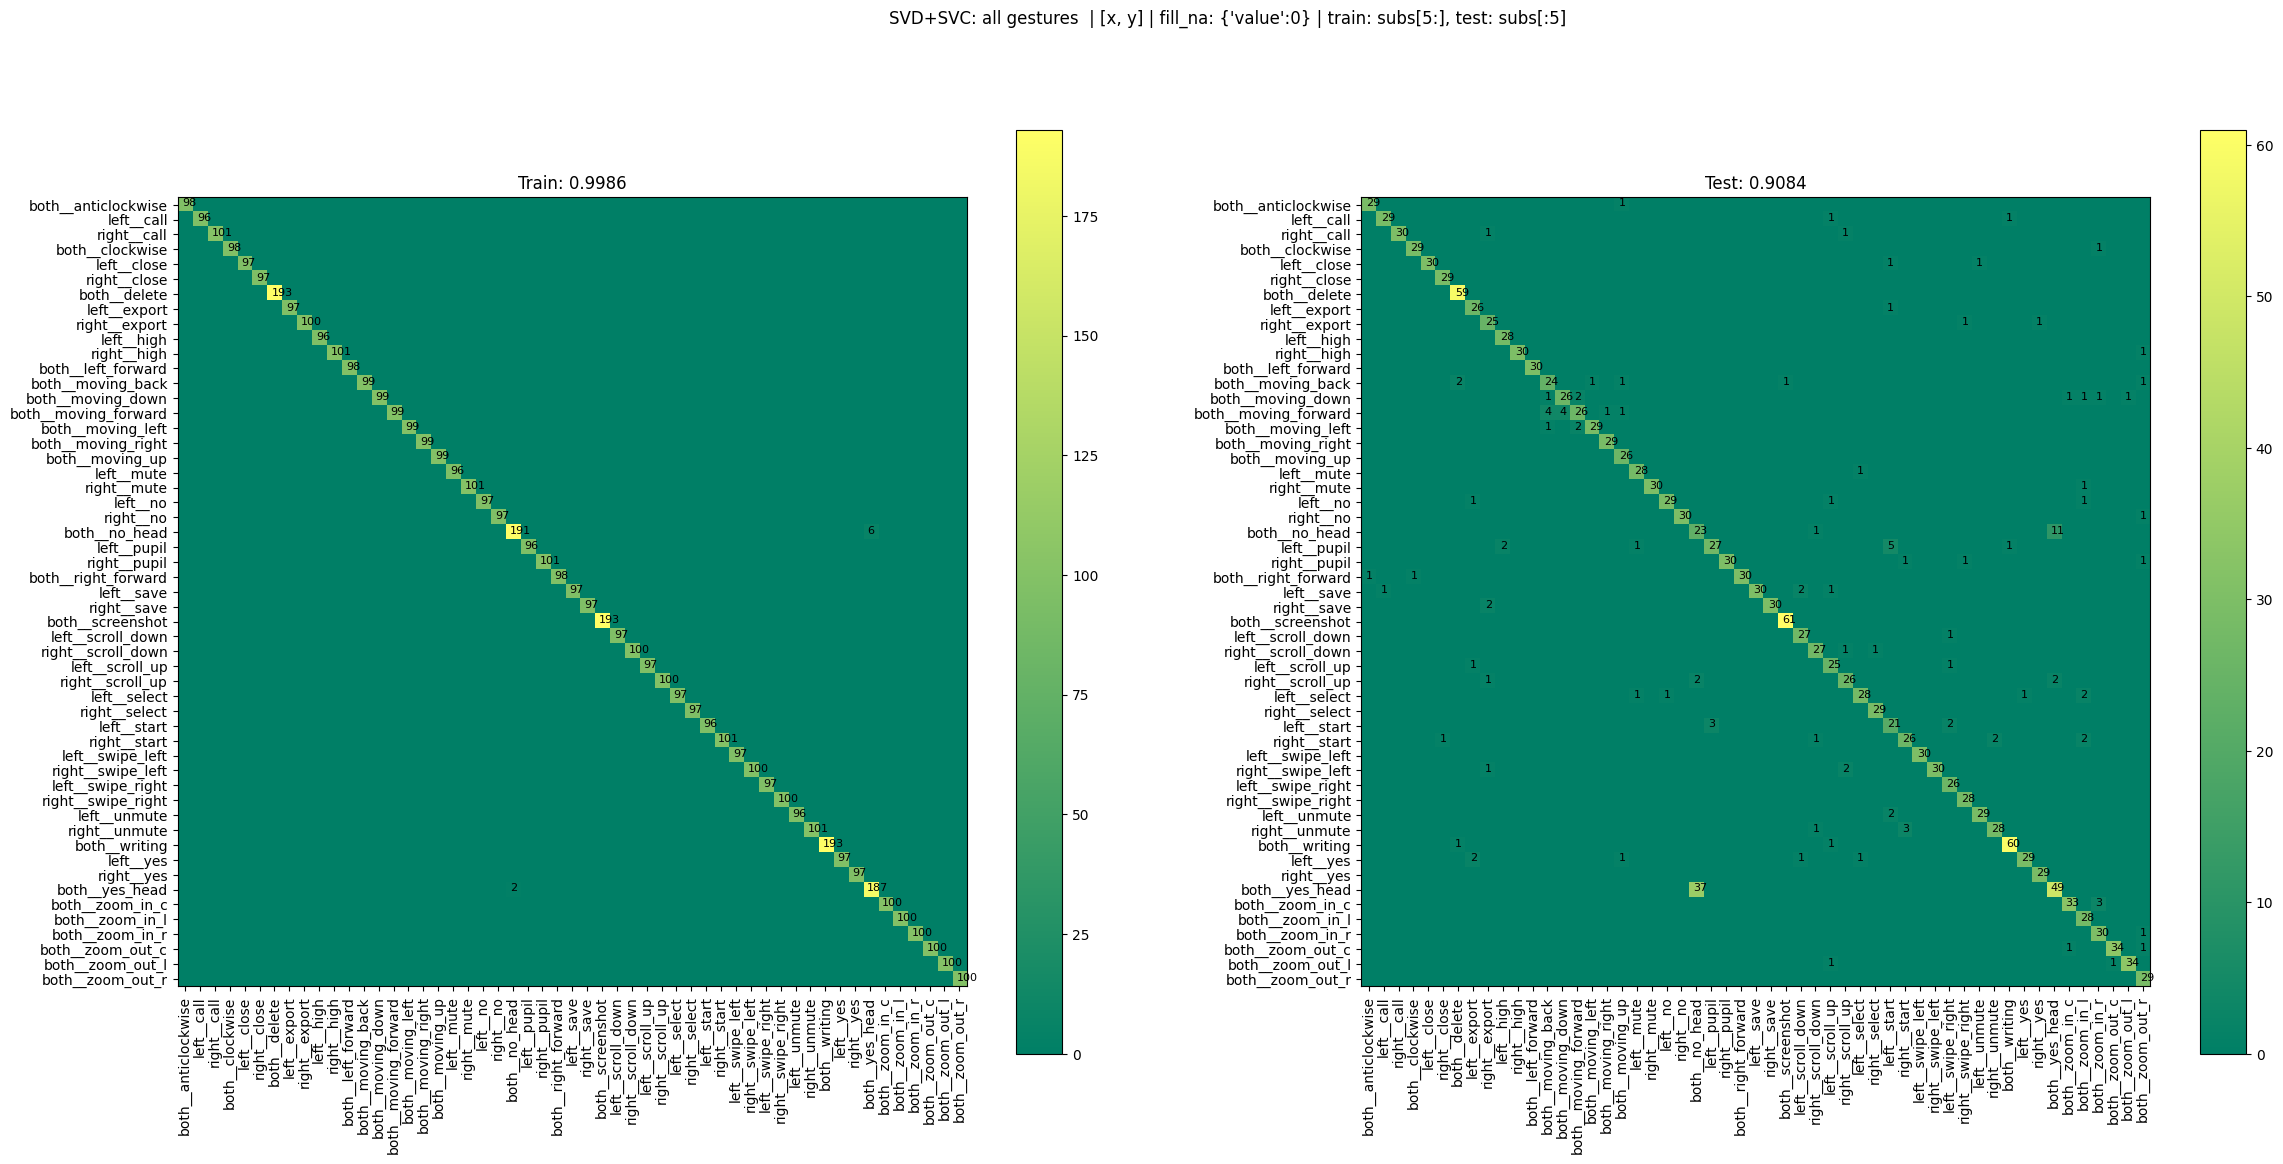

In [63]:
check_model(model, pref + model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

#### STM

In [ ]:
model = pystmm.classifier.STMM(maxIter=2, tolSTM=1e-2, tol=1e-2)
model_name = 'STM'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

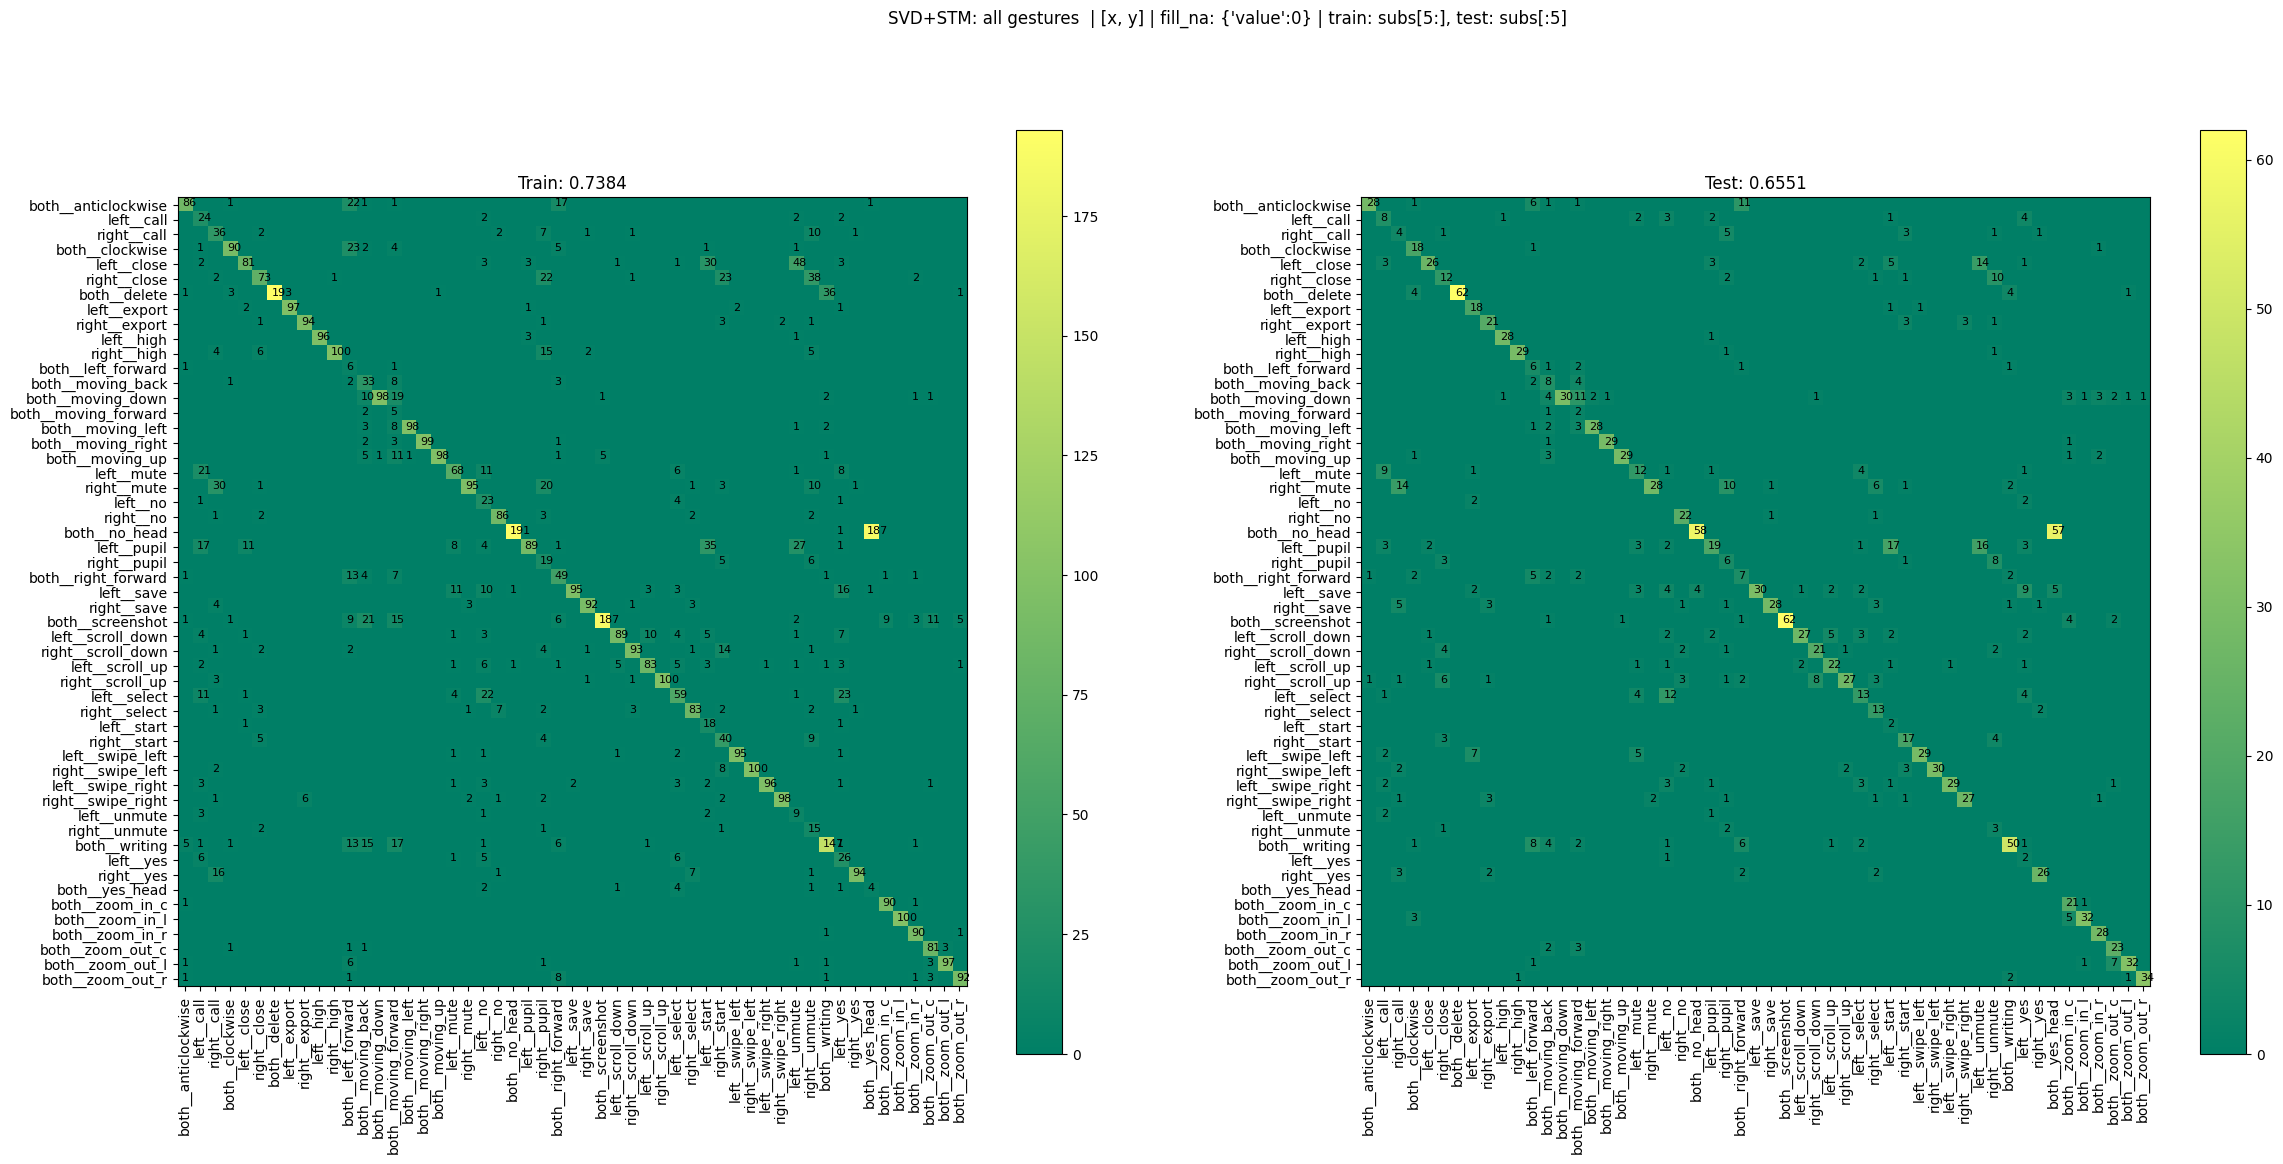

In [230]:
check_model(model, pref + model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

#### KNN

In [162]:
model = KNeighborsClassifier(n_neighbors=8)
model_name = 'KNN'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=False)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

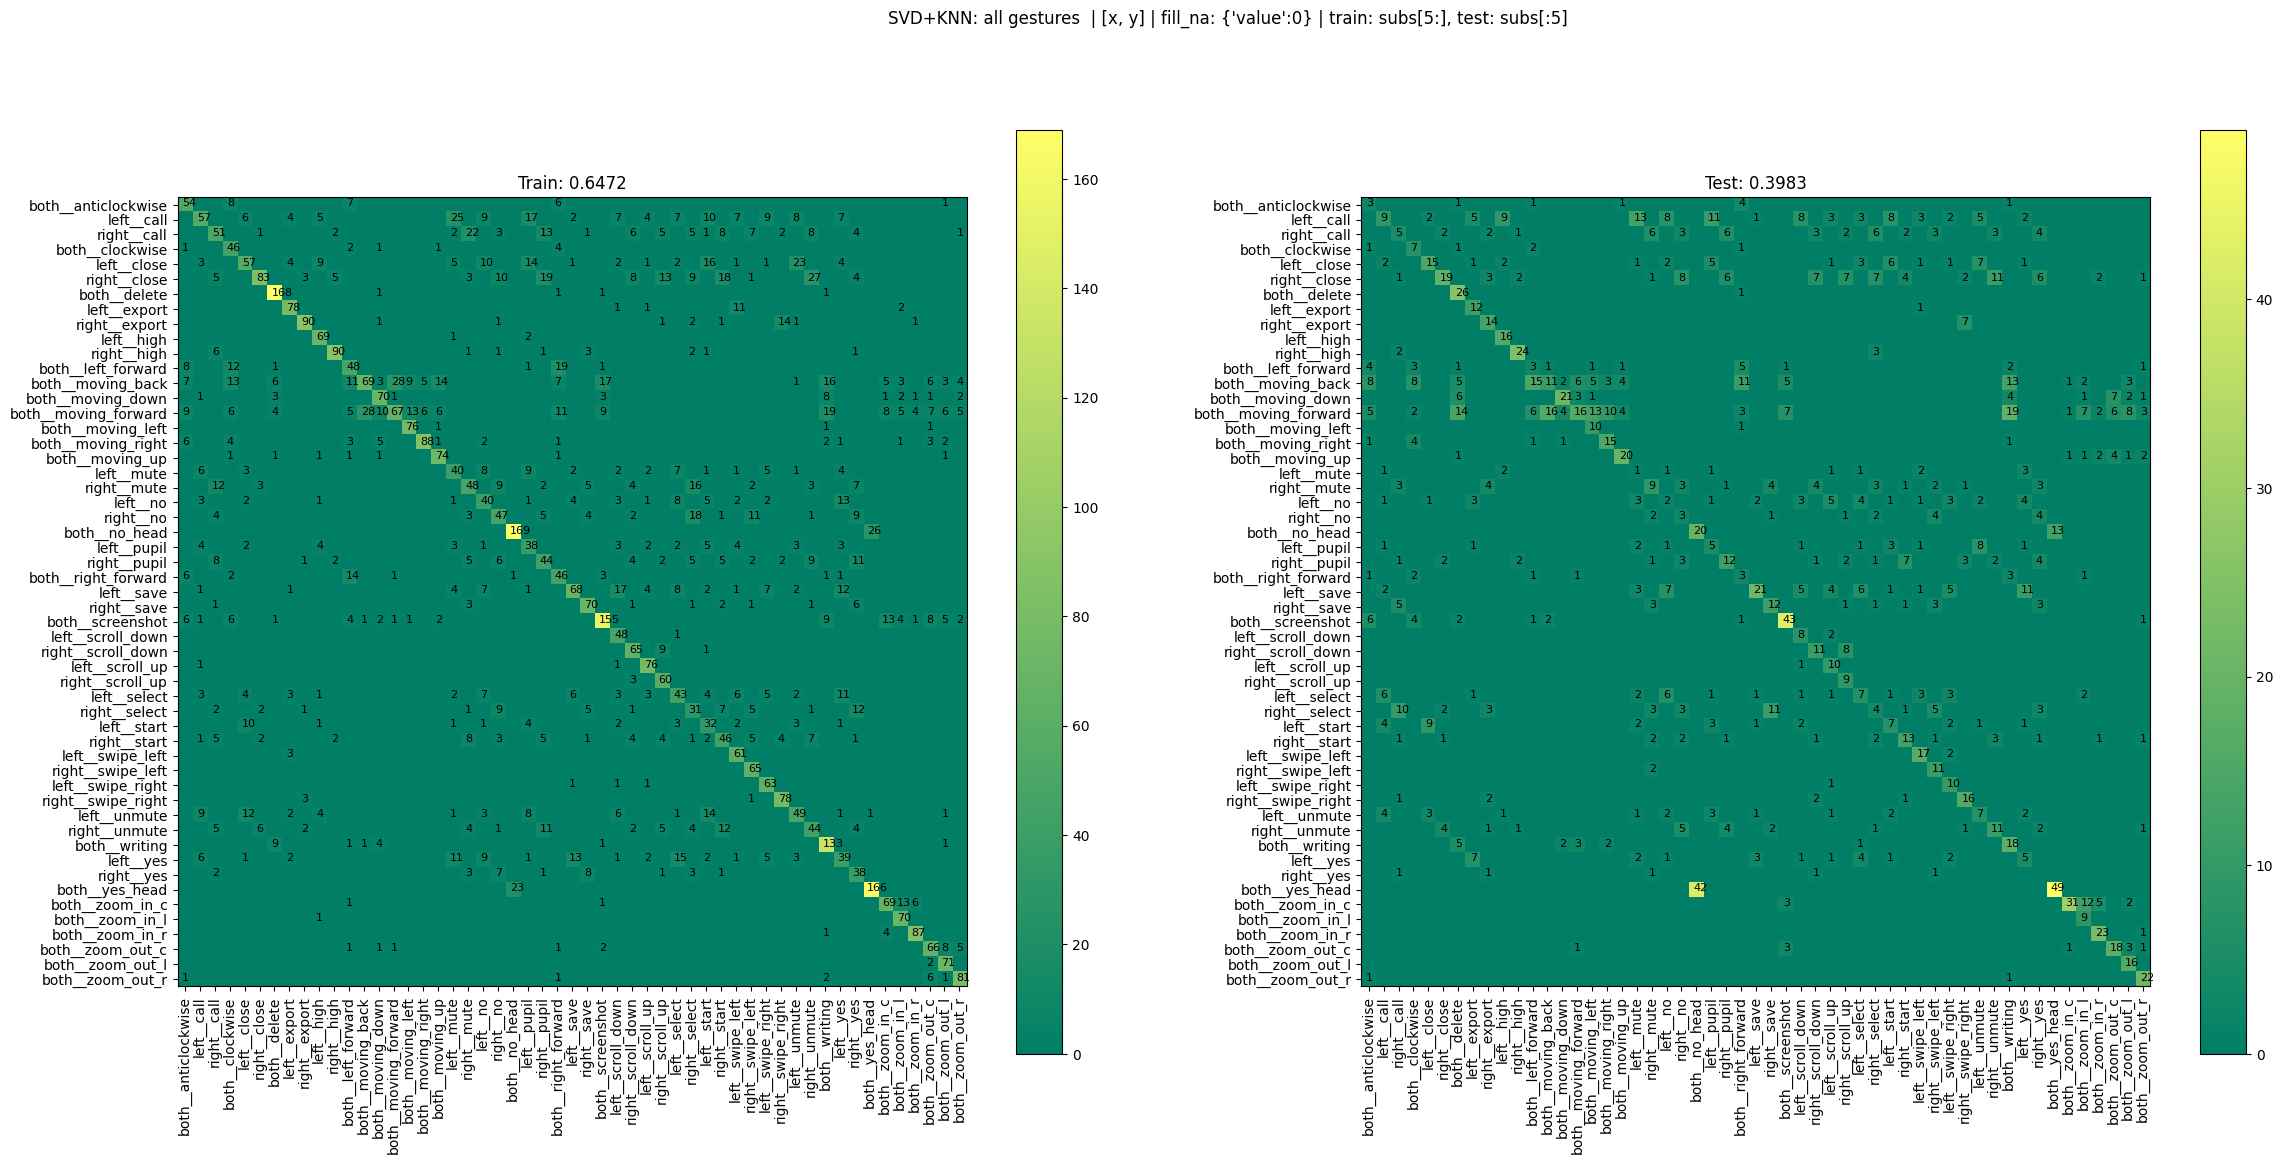

In [163]:
check_model(model, pref + model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

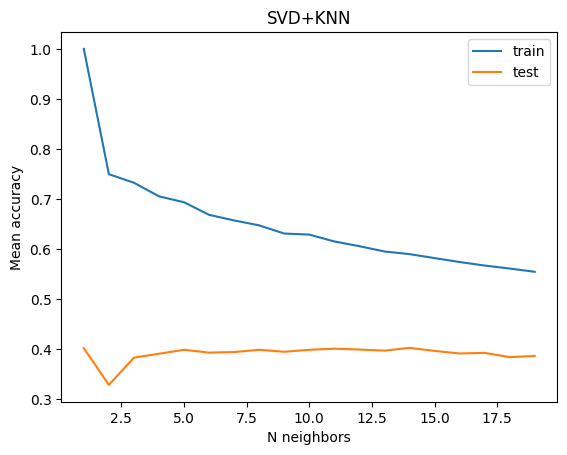

In [164]:
check_KNN(X_train, y_train, X_test, y_test, model_name)

## After CPD

In [ ]:
tensor = tensor_CPD
tensor_test = tensor_CPD_test
pref = 'CPD+'

#### LogReg

In [271]:
model = LogisticRegression(max_iter=1000)
model_name = 'CPD + LogReg'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

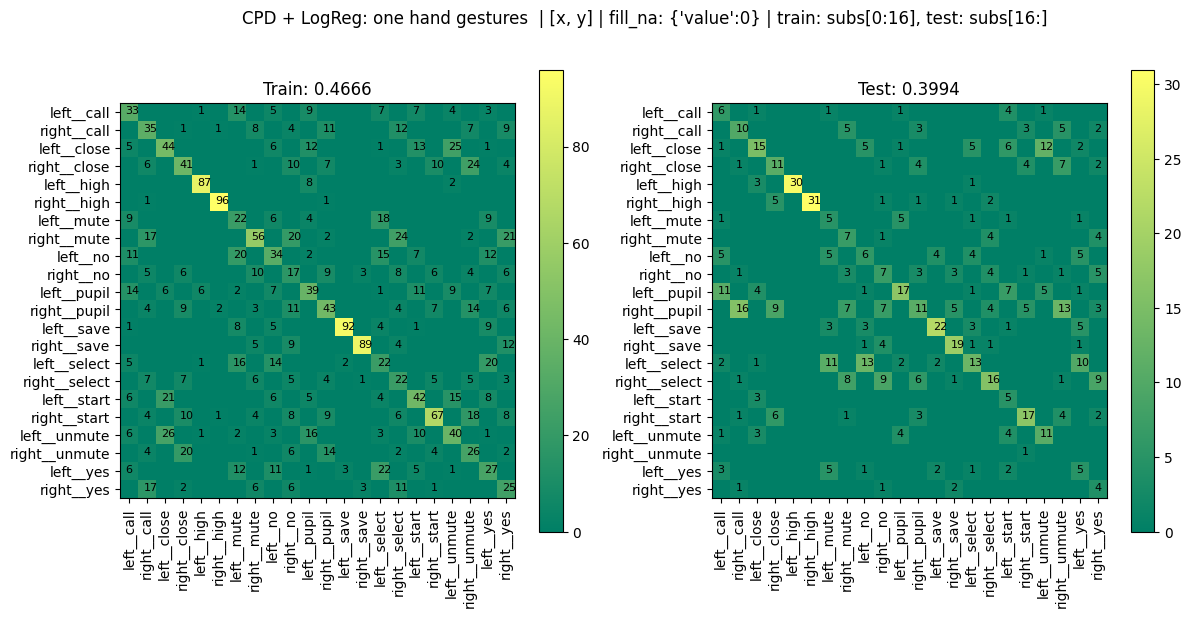

In [272]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### KNN

In [302]:
model = KNeighborsClassifier(n_neighbors=14)
model_name = 'CPD + KNN'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=14)

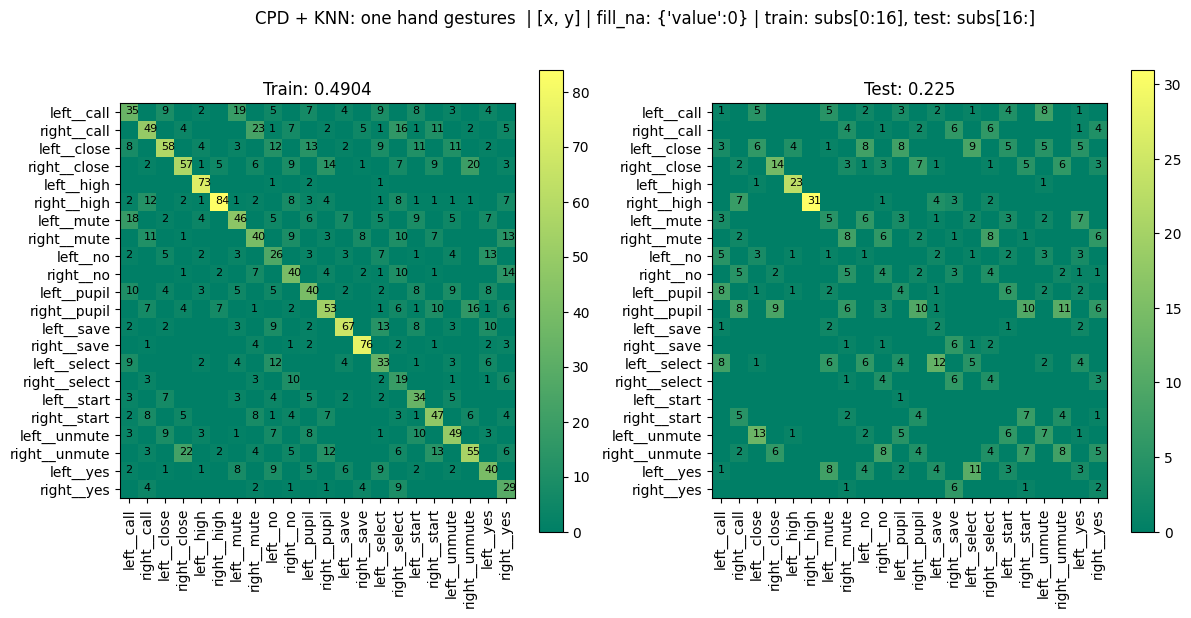

In [303]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

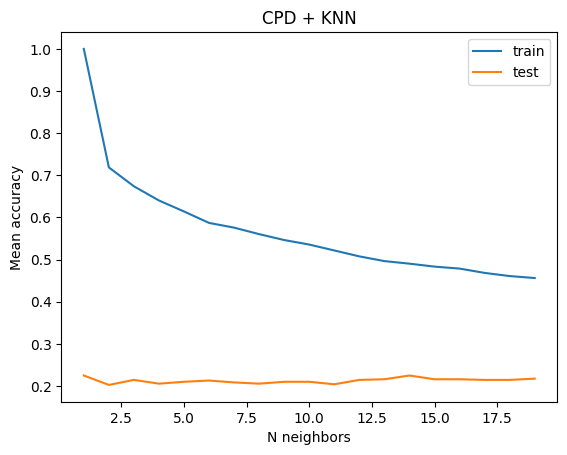

In [296]:
check_KNN(X_train, y_train, X_test, y_test, model_name)  

## After Tucker

In [76]:
# tensor = tensor_tucker_tn
# tensor_test = tensor_tucker_test_tn
tensor = tensor_tucker_tn_
tensor_test = tensor_tucker_test_tn_
pref = 'Tucker_tn+'

# tensor = tensor_tucker
# tensor_test = tensor_tucker_test
# pref = 'Tucker+'

#### LogReg

In [77]:
model = LogisticRegression(max_iter=200)
model_name = pref + 'LogReg'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list,
                                                                   labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

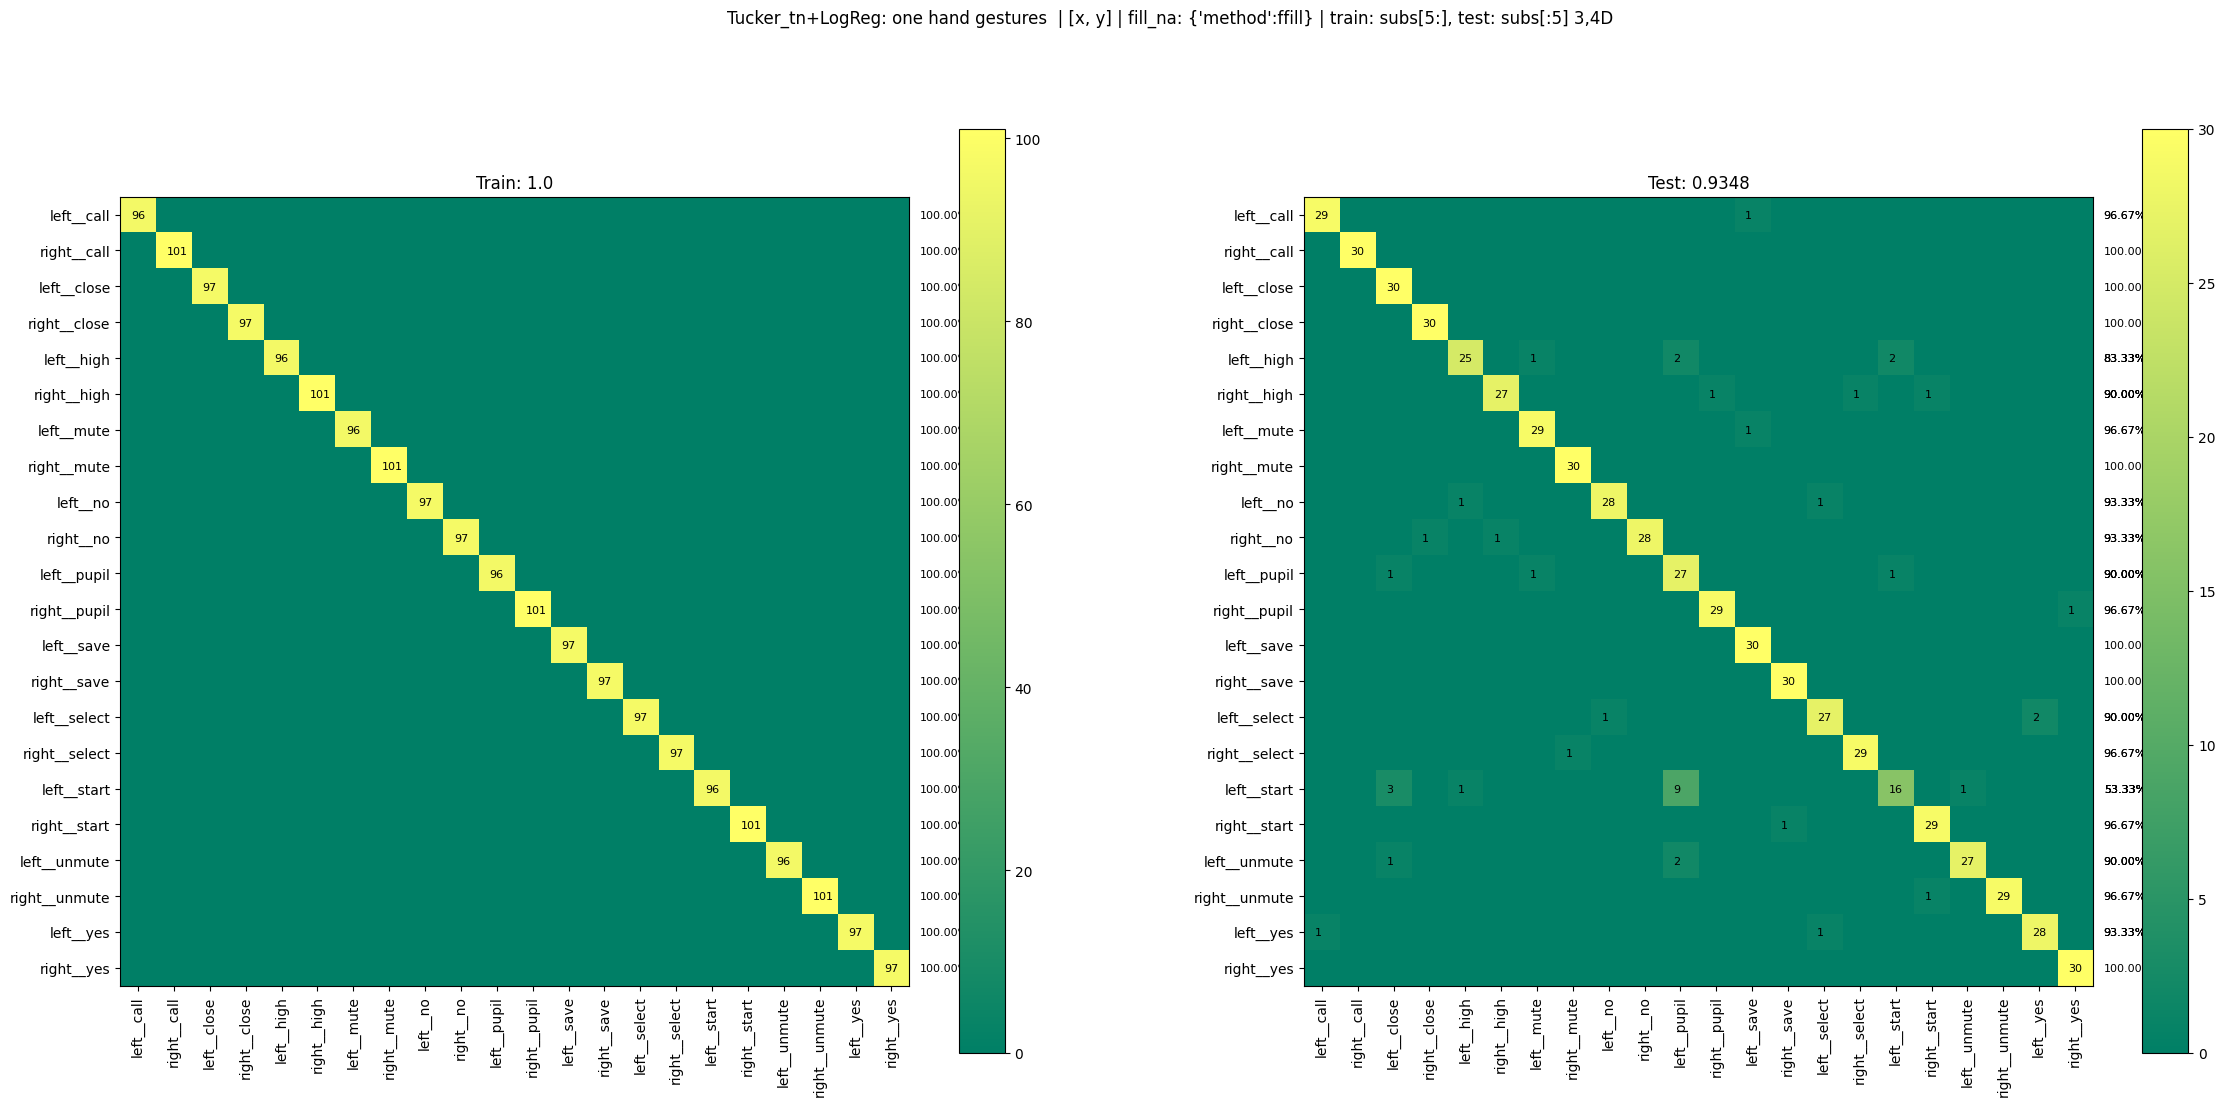

In [78]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

In [79]:
test_accuracy((model, model_name), tensor, tensor_test, labels_list, labels_list_test, True, n_trials=1)

For model: Tucker_tn+LogReg


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

Acc of Tucker_tn+LogReg: 93.48(0.00) %


array([0.93484848])

#### Random Forest

In [80]:
model = RandomForestClassifier(n_estimators=200)
model_name = pref + 'RF'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=False)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)


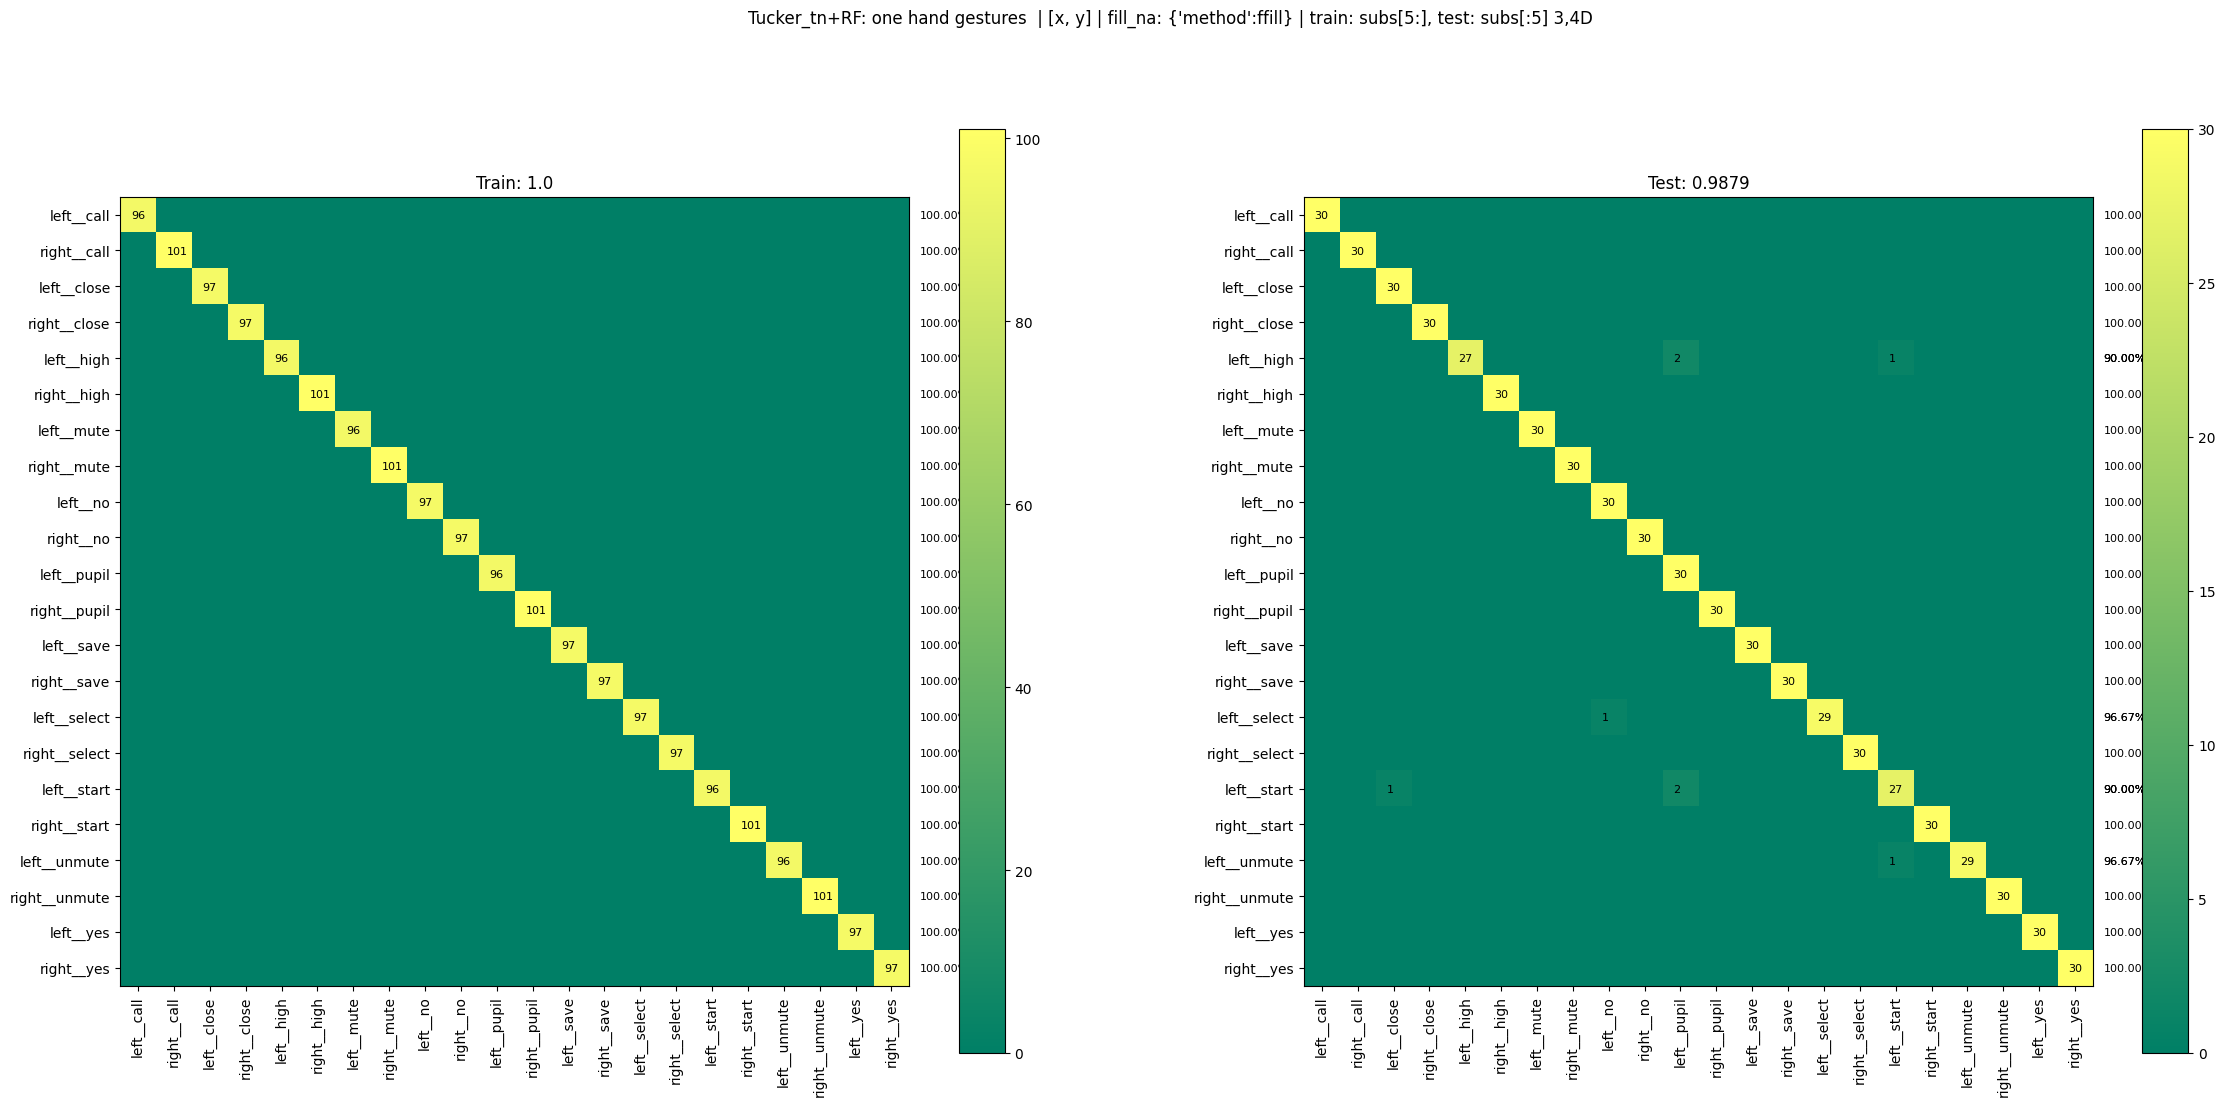

In [81]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

In [82]:
test_accuracy((model, model_name), tensor, tensor_test, labels_list, labels_list_test, False, n_trials=5)

For model: Tucker_tn+RF


100%|██████████| 5/5 [03:23<00:00, 40.77s/it]

Acc of Tucker_tn+RF: 98.52(0.18) %


array([0.98787879, 0.98636364, 0.98333333, 0.98333333, 0.98484848])

### other

#### XGBoost

In [52]:
model = xgb.XGBClassifier(n_estimators=200, max_depth=6)

model_name = 'Tucker + XGB'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

2
2



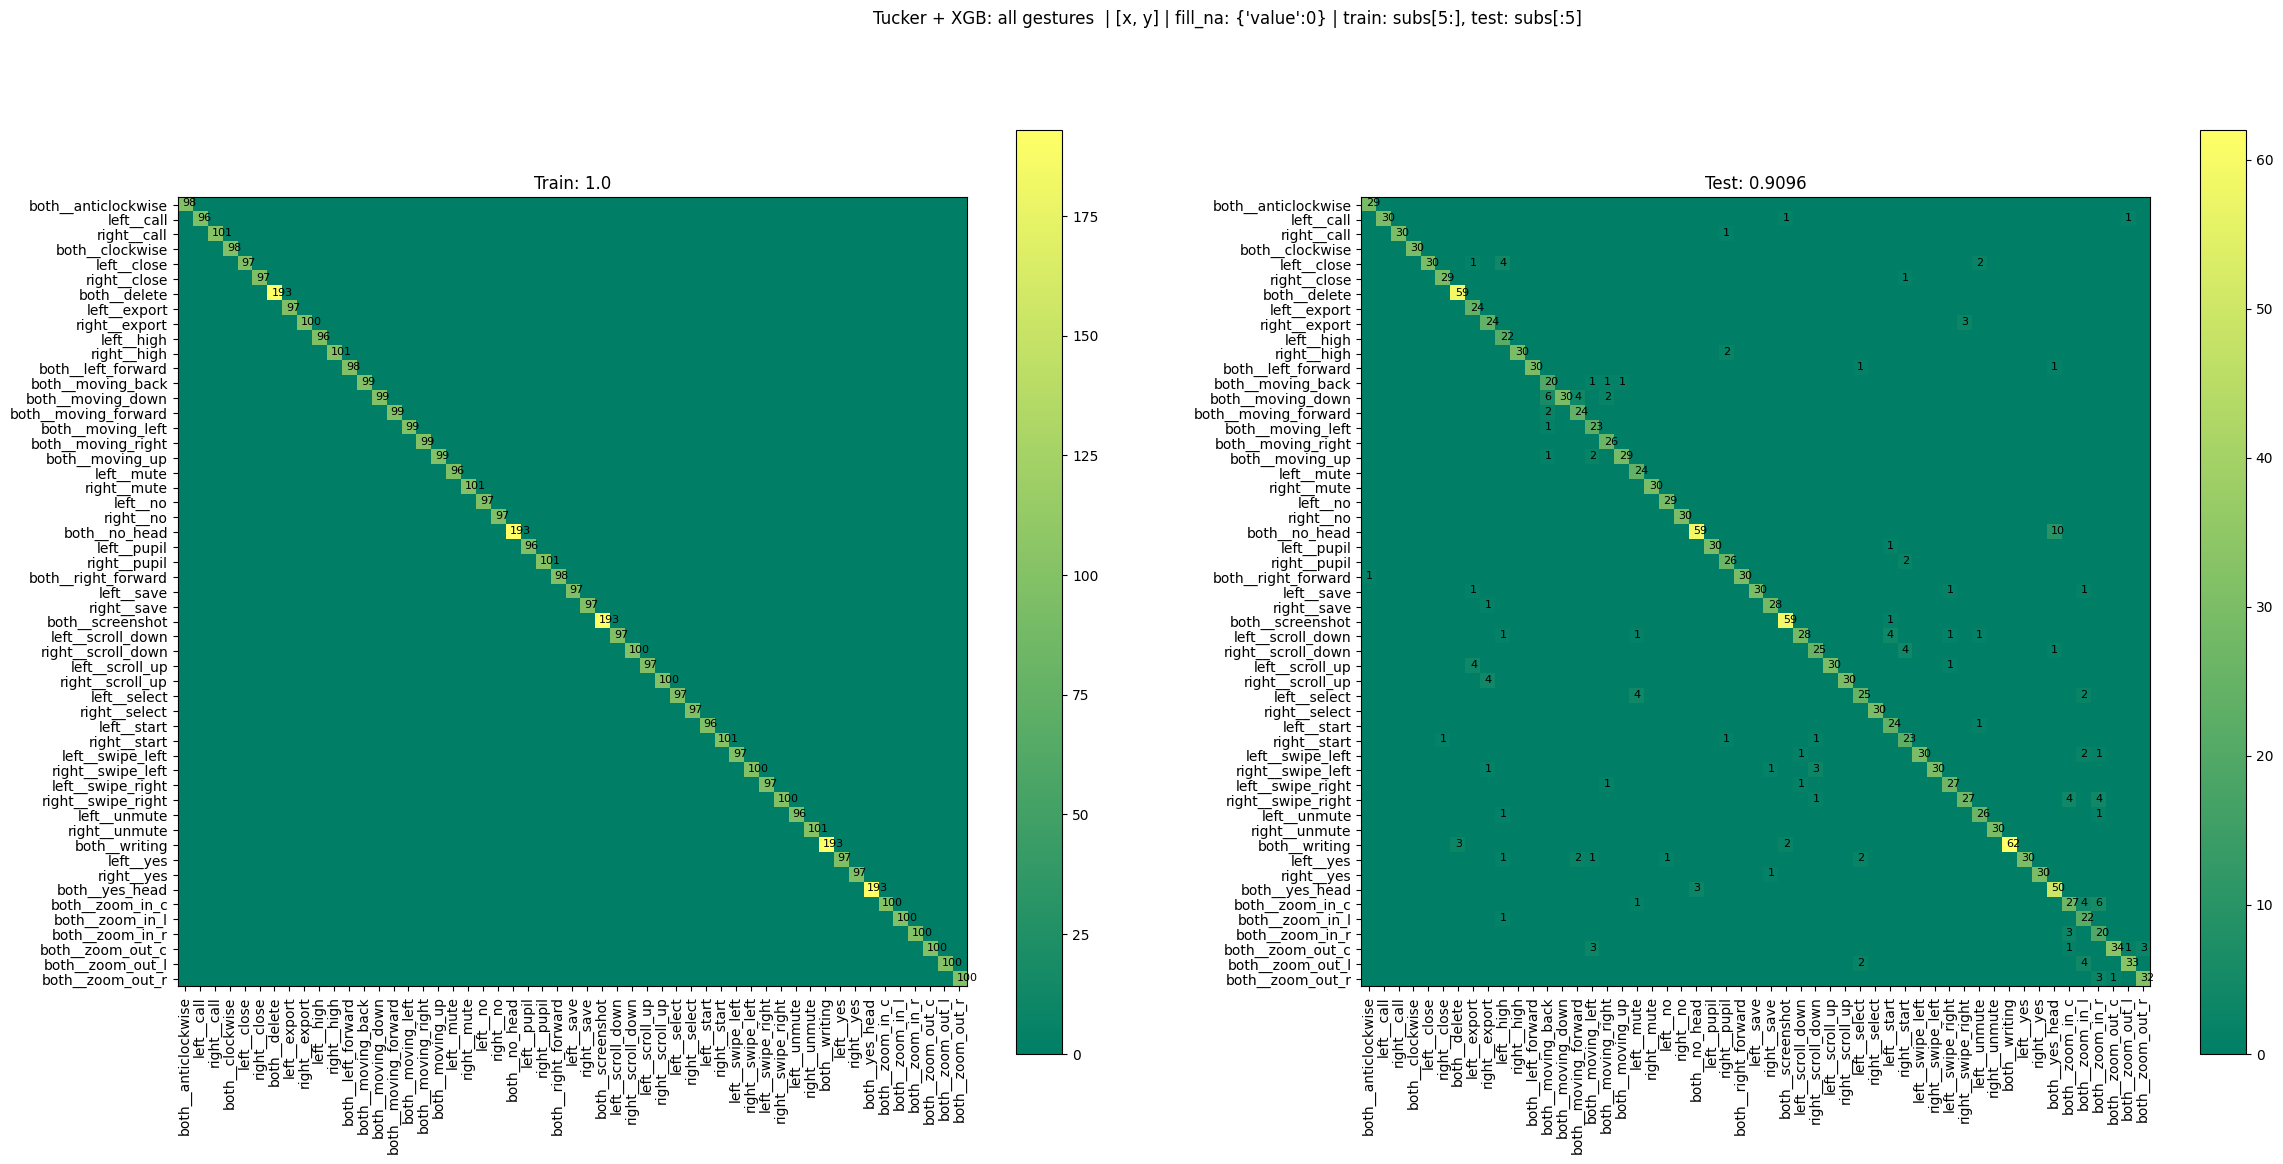

In [53]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### SVM

In [62]:
model = SVC(C=1, kernel='linear')
model_name = 'Tucker + SVC'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

SVC(C=1, kernel='linear')

2
2



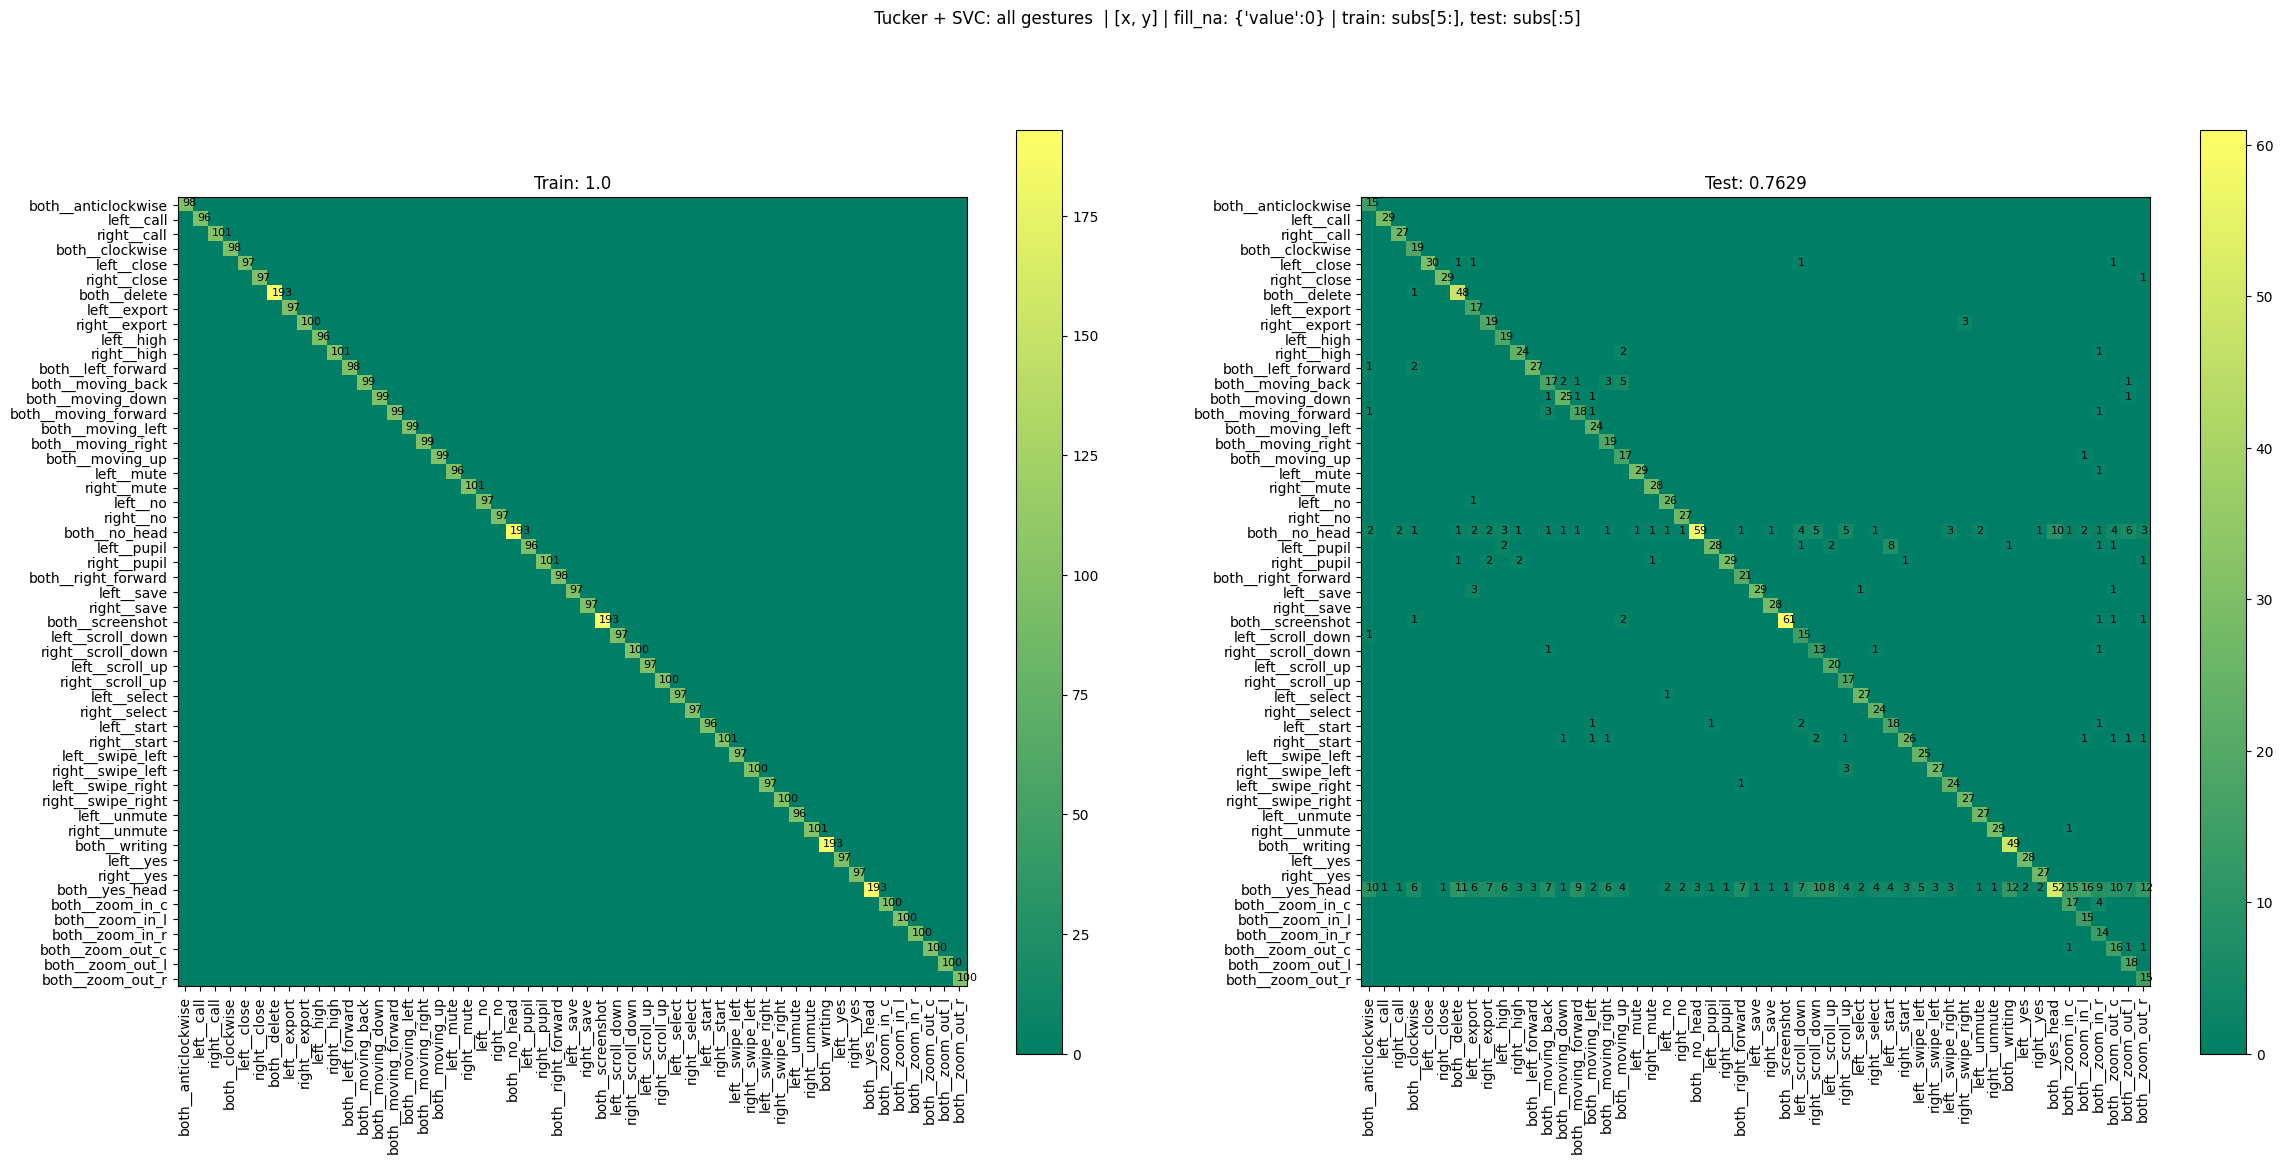

In [63]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### STM

In [ ]:
model = pystmm.classifier.STMM(maxIter=2, tolSTM=1e-2, tol=1e-2)
model_name = 'Tucker + STMM'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = tensor_tucker
X_test = tensor_test

model.fit(X_train, y_train)


2
2



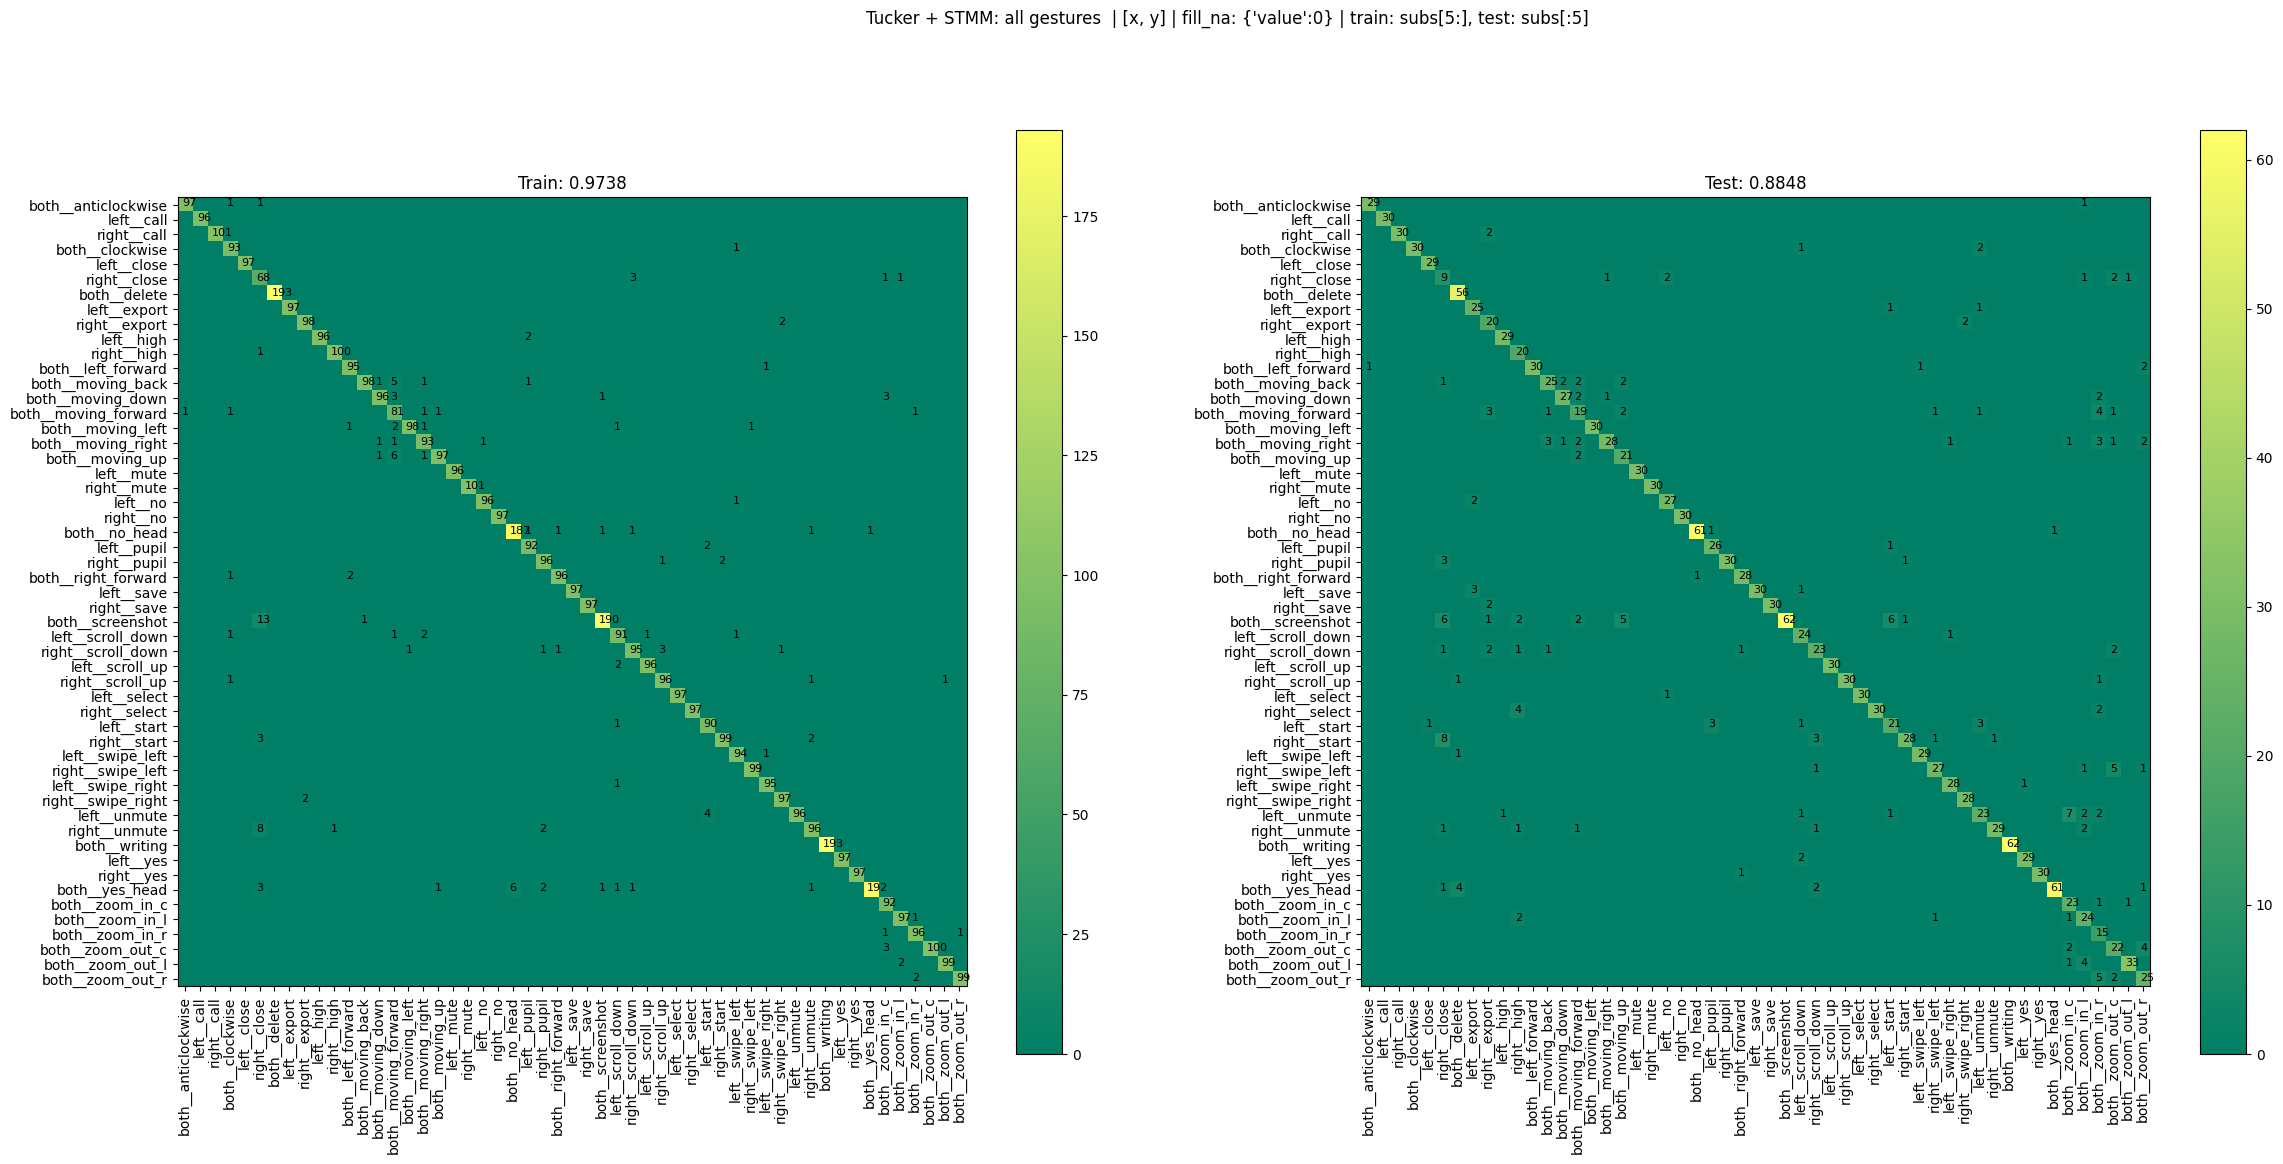

In [69]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name + ": "+ exp_cofig)
print()

#### KNN

In [60]:
model = KNeighborsClassifier(n_neighbors=30)
model_name = 'Tucker+ KNN'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

2
2



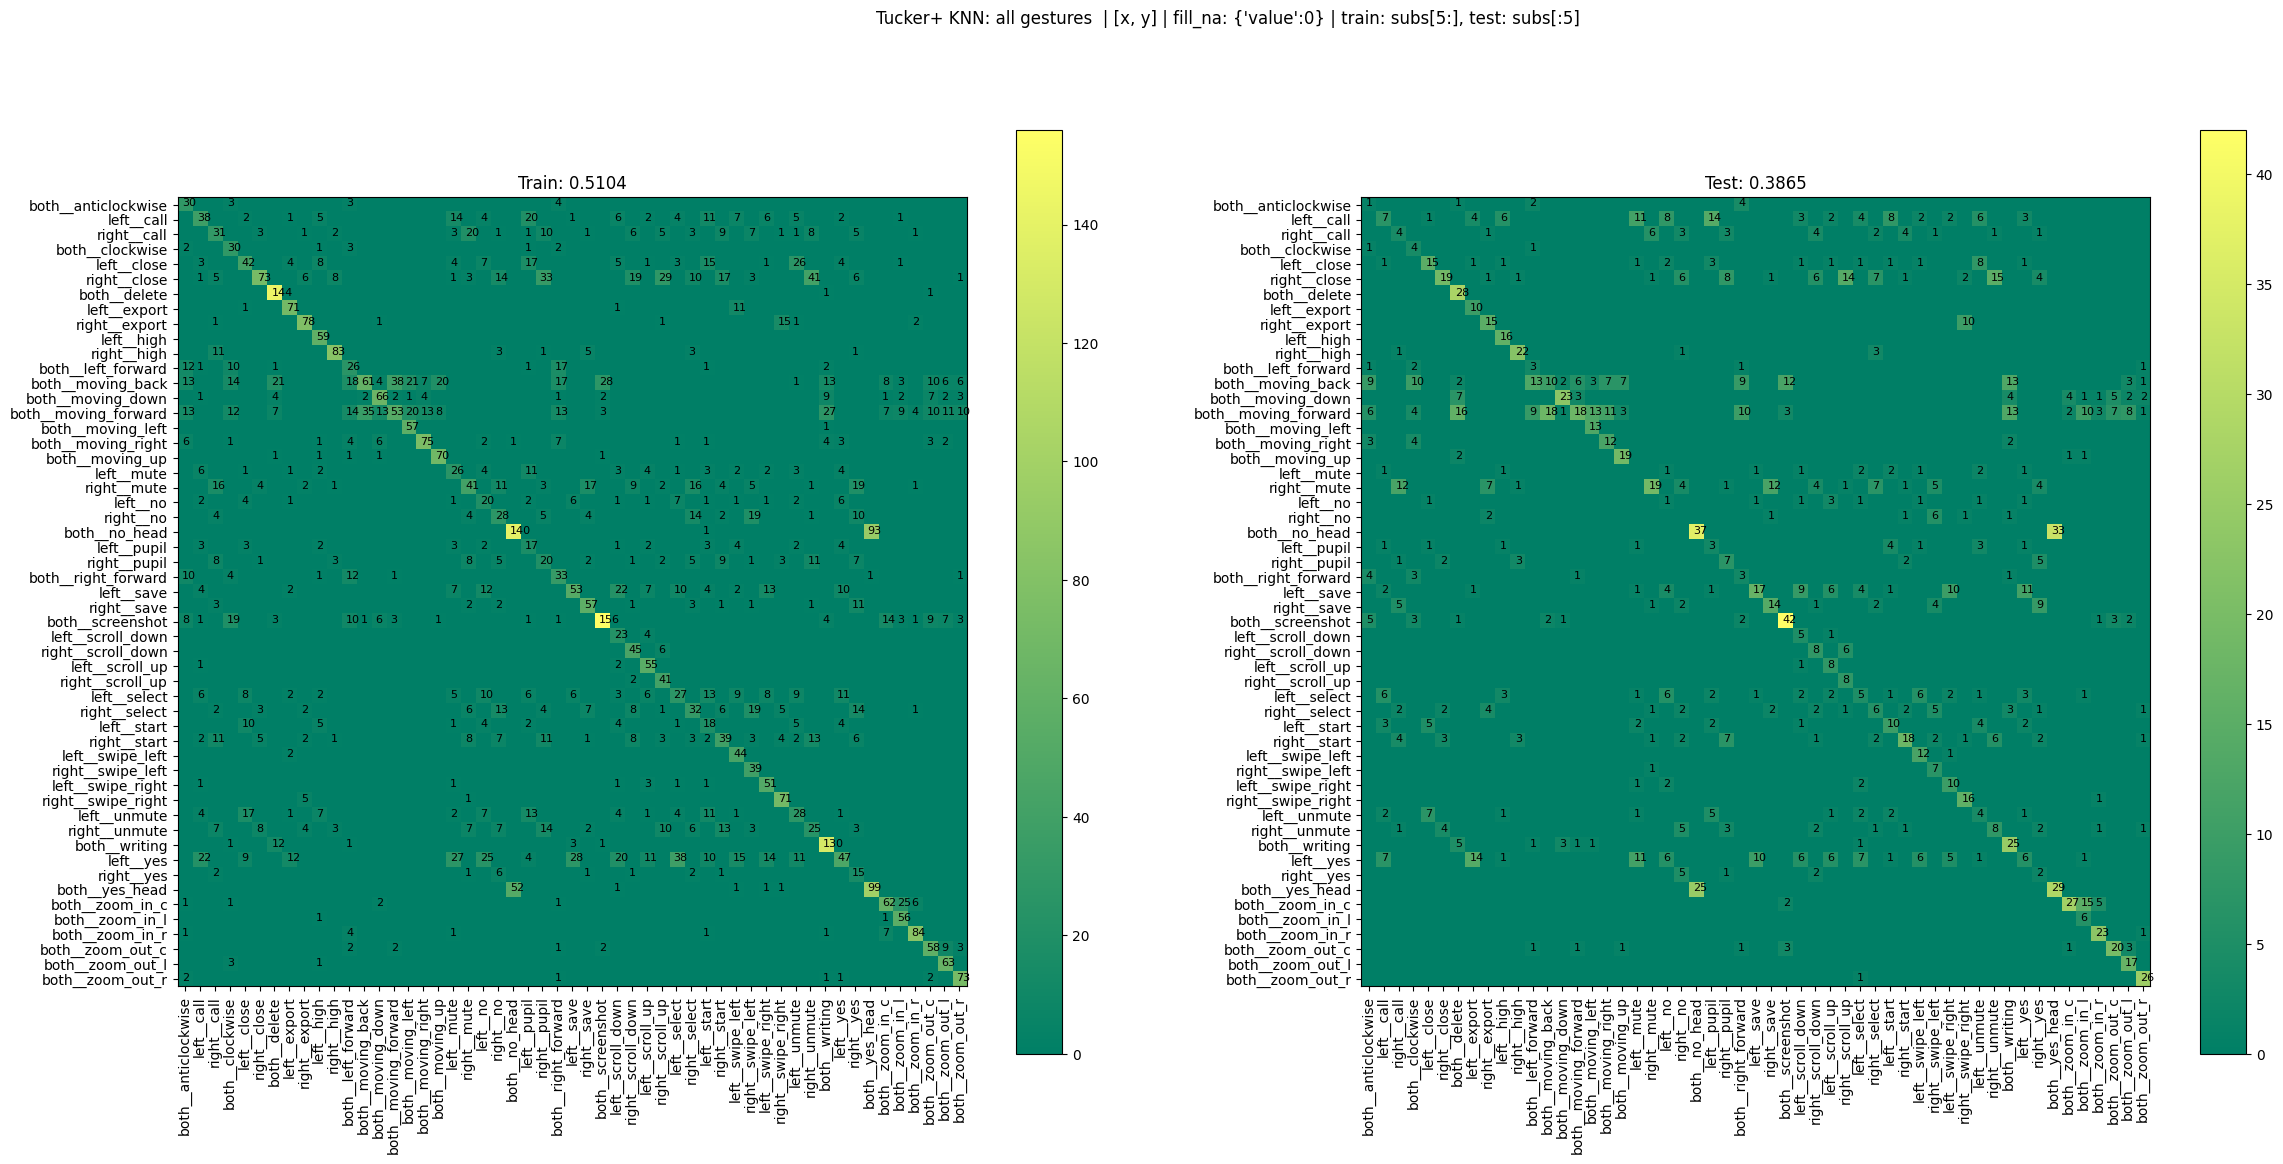

In [61]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

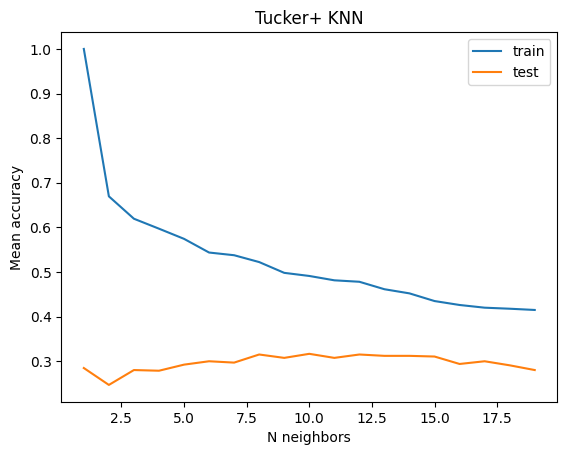

In [33]:
check_KNN(X_train, y_train, X_test, y_test, model_name)  

## After Tucker tntorch

In [29]:
tensor = tensor_tucker_tn
tensor_test = tensor_tucker_test_tn
pref = 'Tucker_tn+'

#### LogReg

In [30]:
model = LogisticRegression(max_iter=200)
model_name = pref + 'LogReg'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

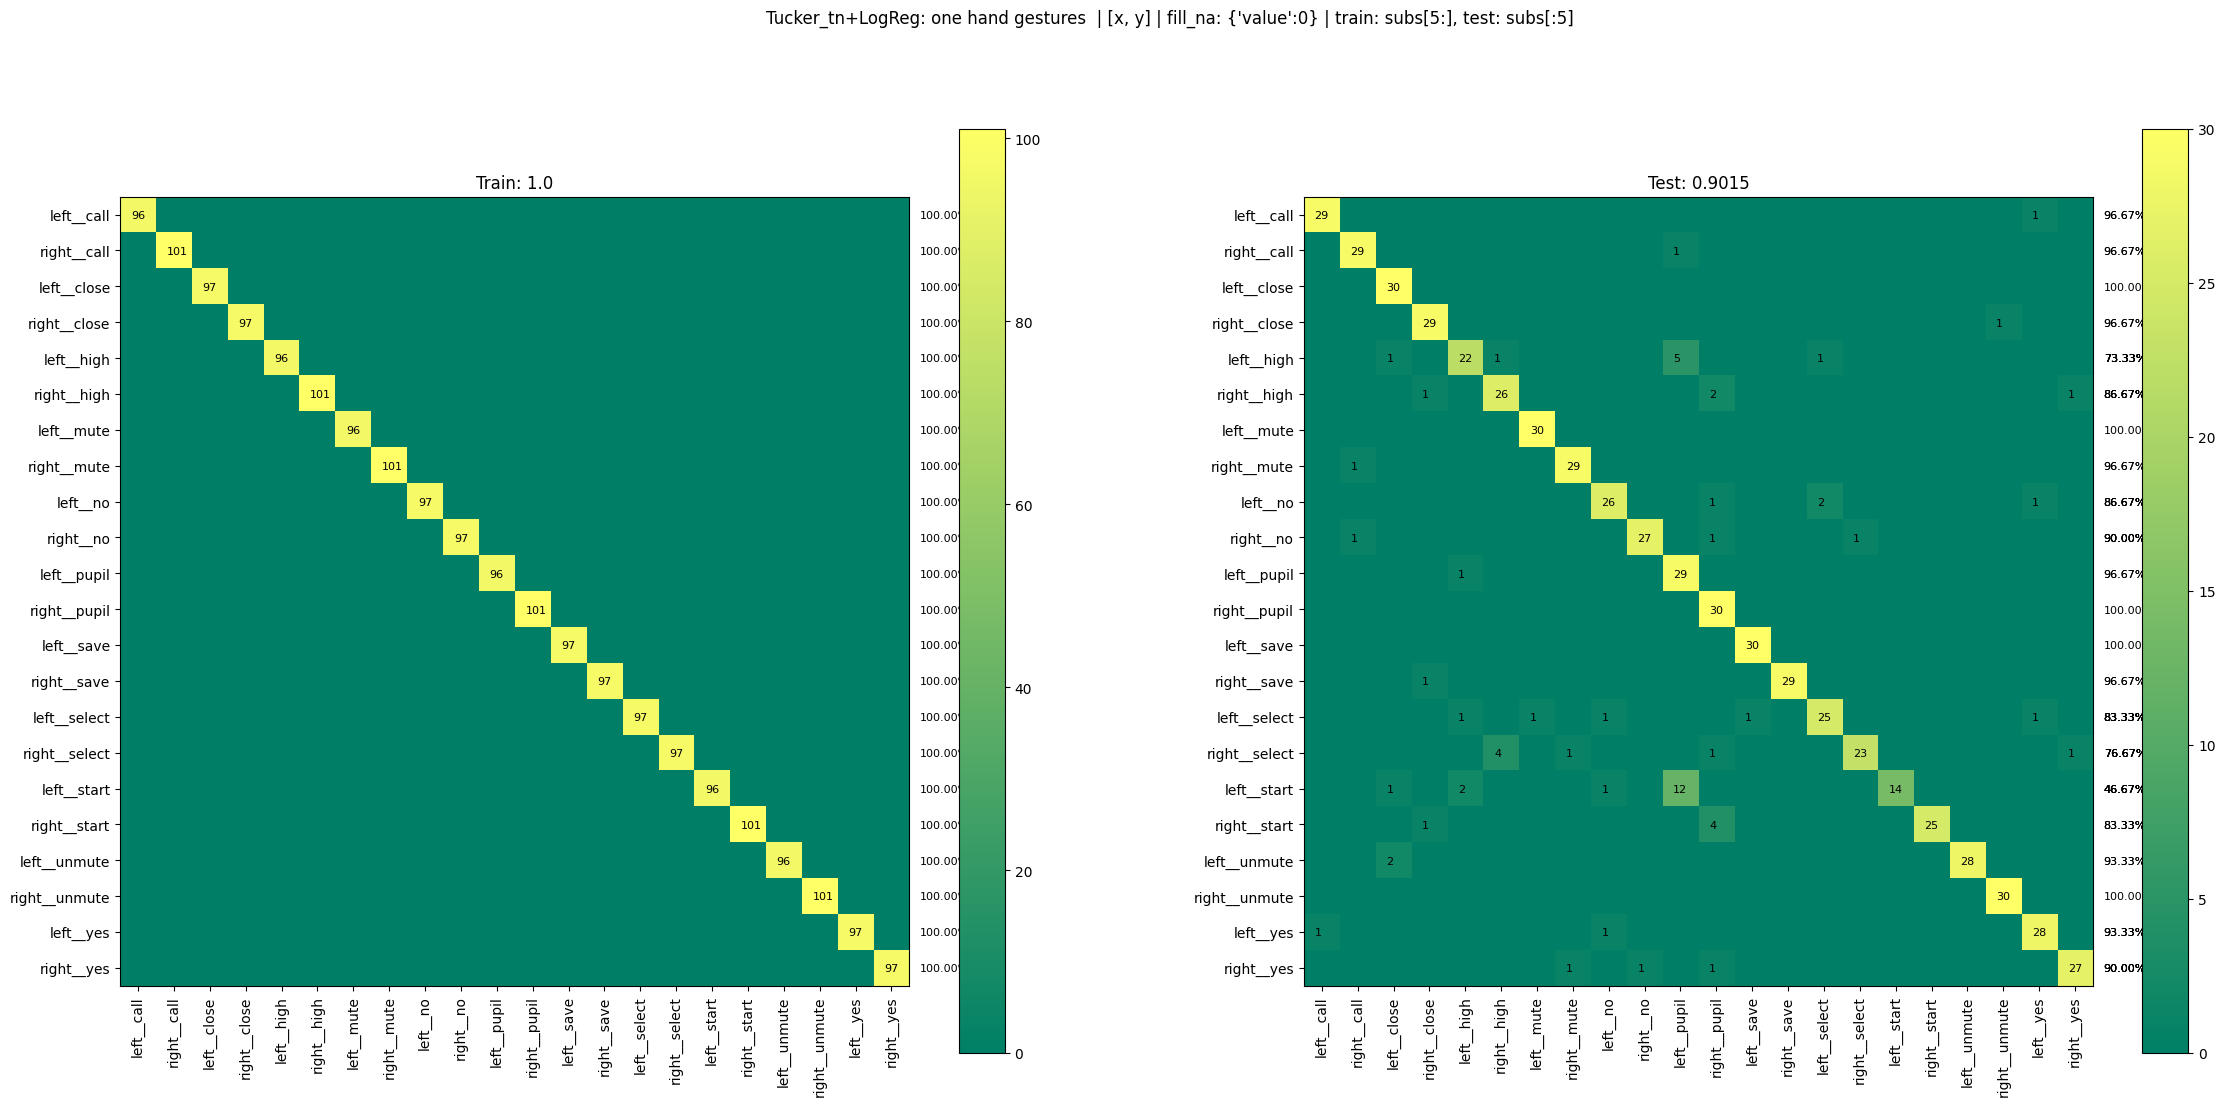

In [31]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

#### Random Forest

In [32]:
model = RandomForestClassifier(n_estimators=200)
model_name = pref + 'RF'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

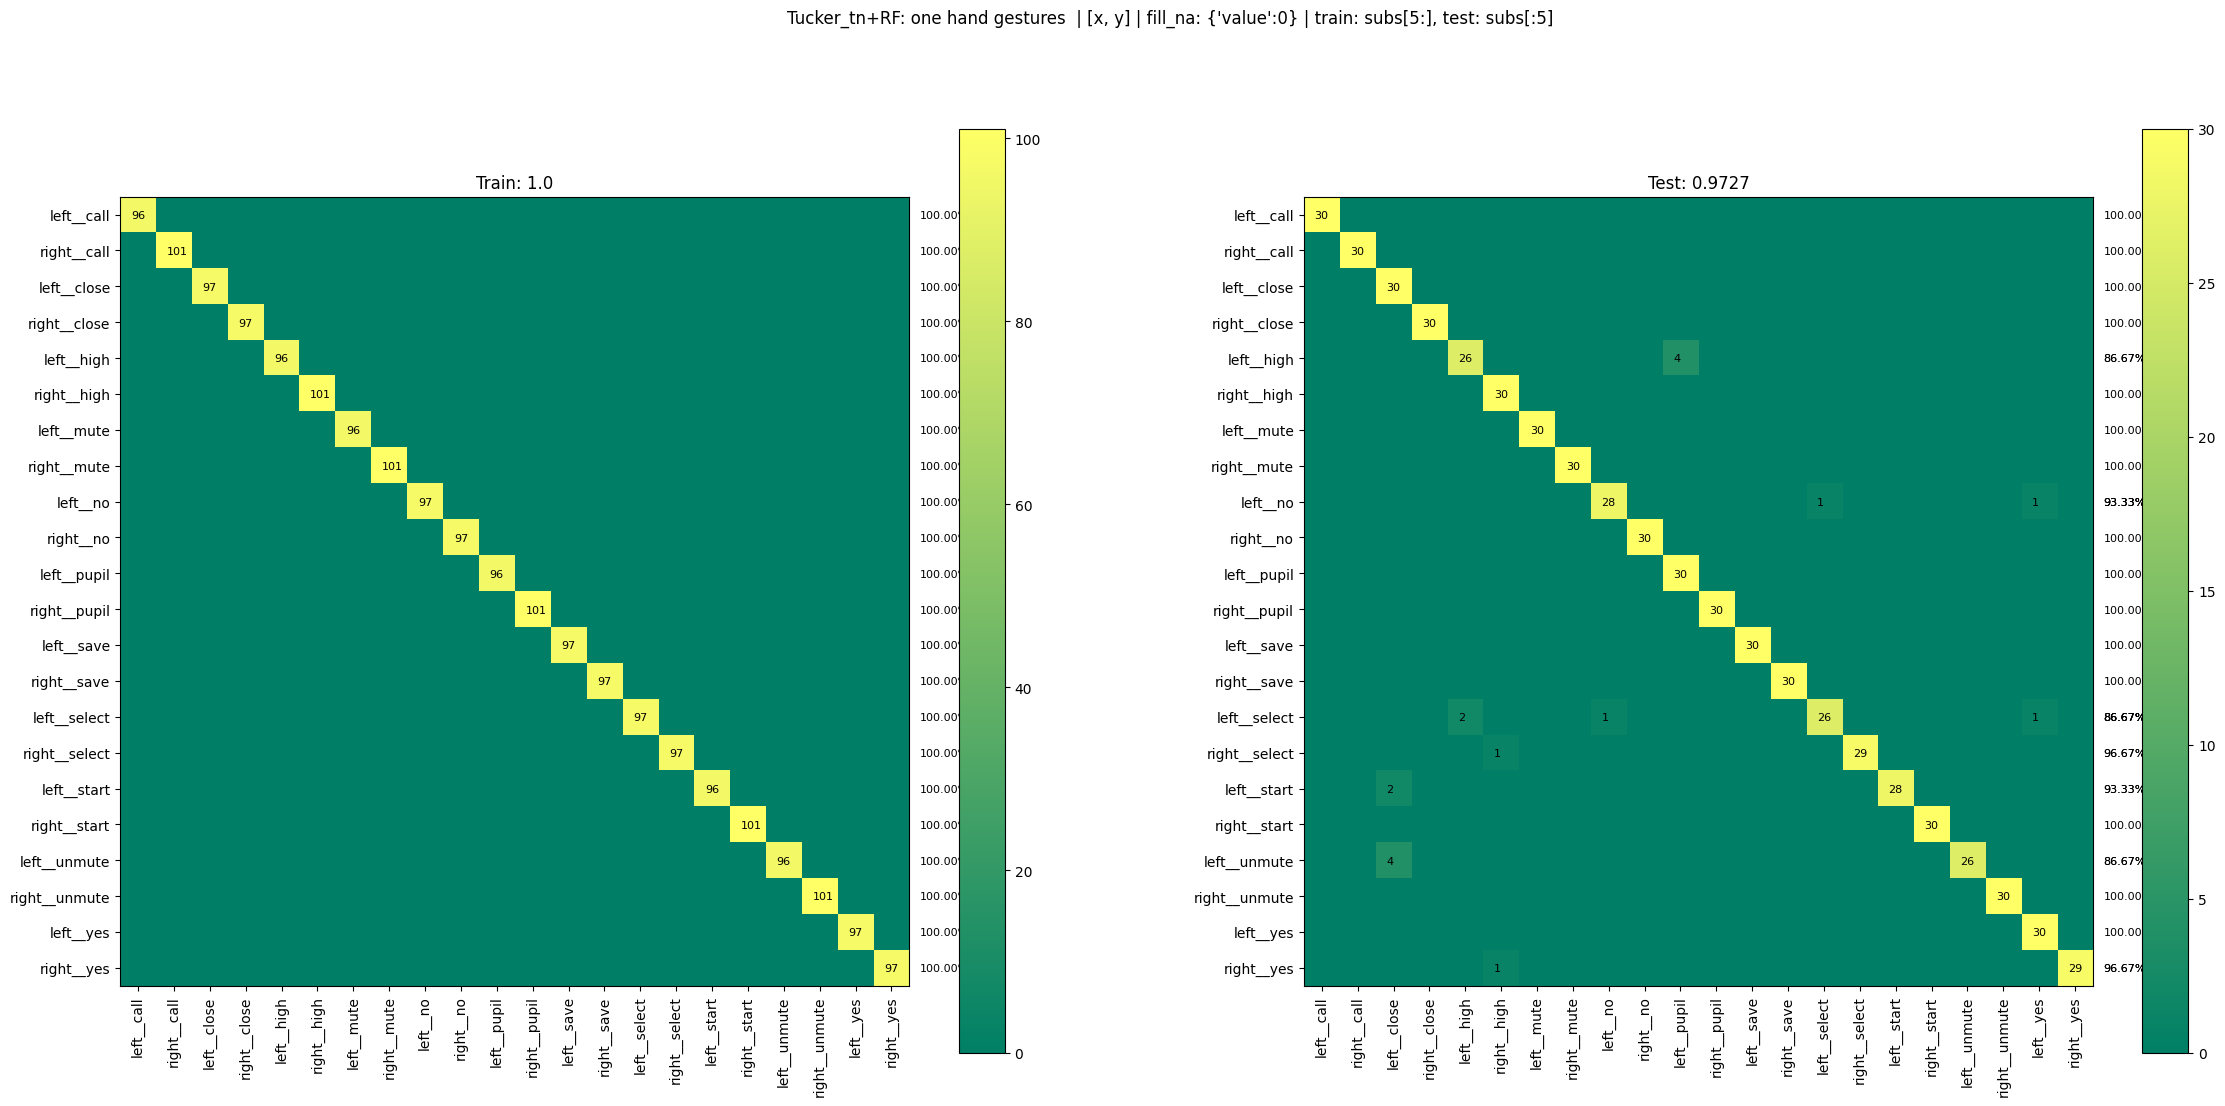

In [33]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

### Other

#### XGBoost

In [ ]:
model = xgb.XGBClassifier(n_estimators=200, max_depth=6)

model_name = 'Tucker + XGB'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

2
2



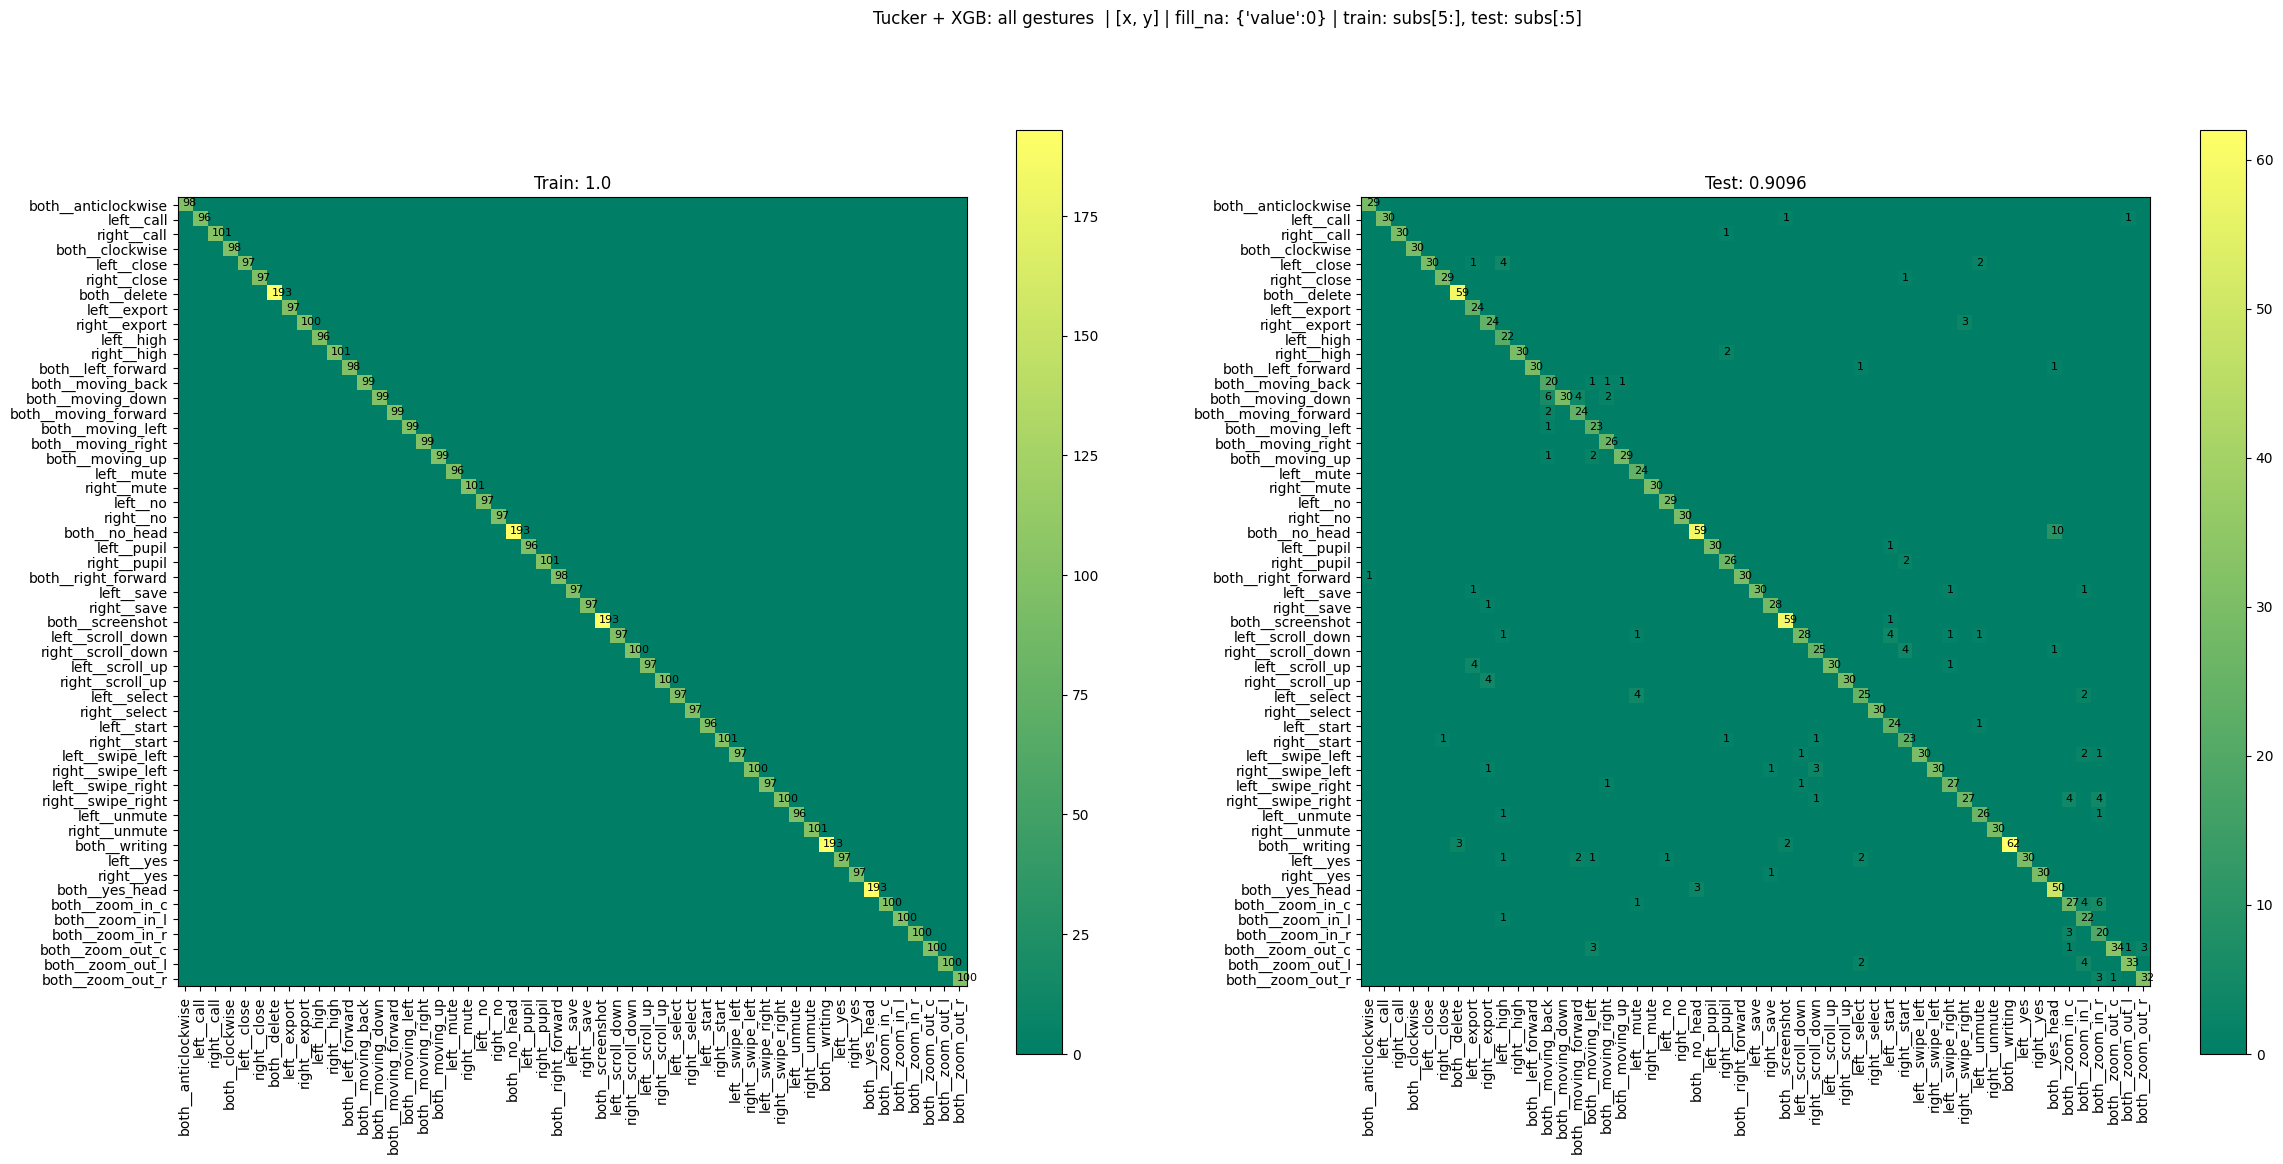

In [ ]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### SVM

In [ ]:
model = SVC(C=1, kernel='linear')
model_name = 'Tucker + SVC'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

SVC(C=1, kernel='linear')

2
2



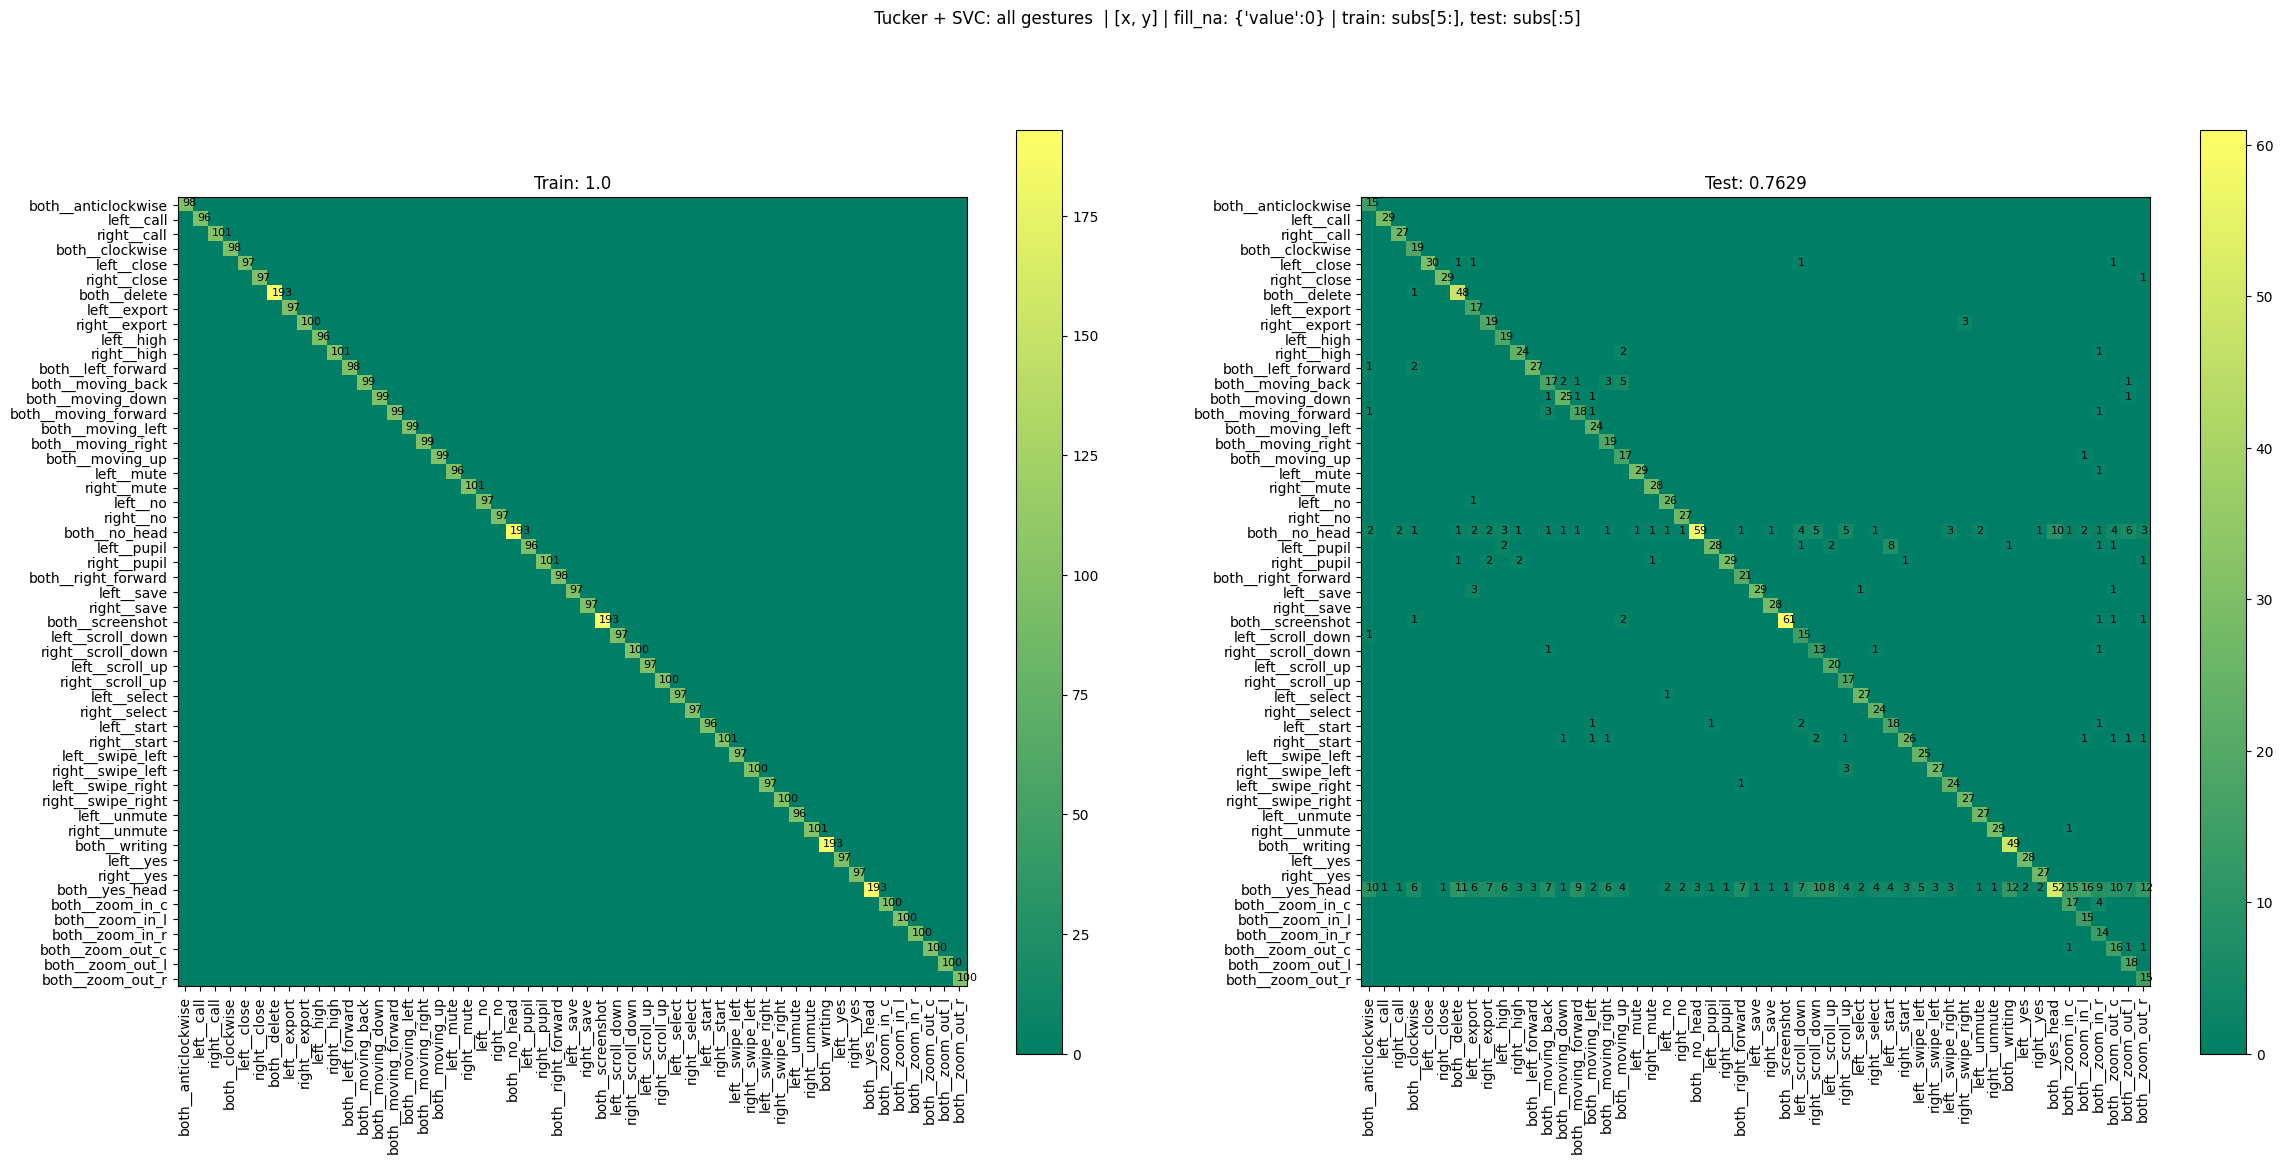

In [ ]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### STM

In [ ]:
model = pystmm.classifier.STMM(maxIter=2, tolSTM=1e-2, tol=1e-2)
model_name = 'Tucker + STMM'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = tensor_tucker
X_test = tensor_test

model.fit(X_train, y_train)


2
2



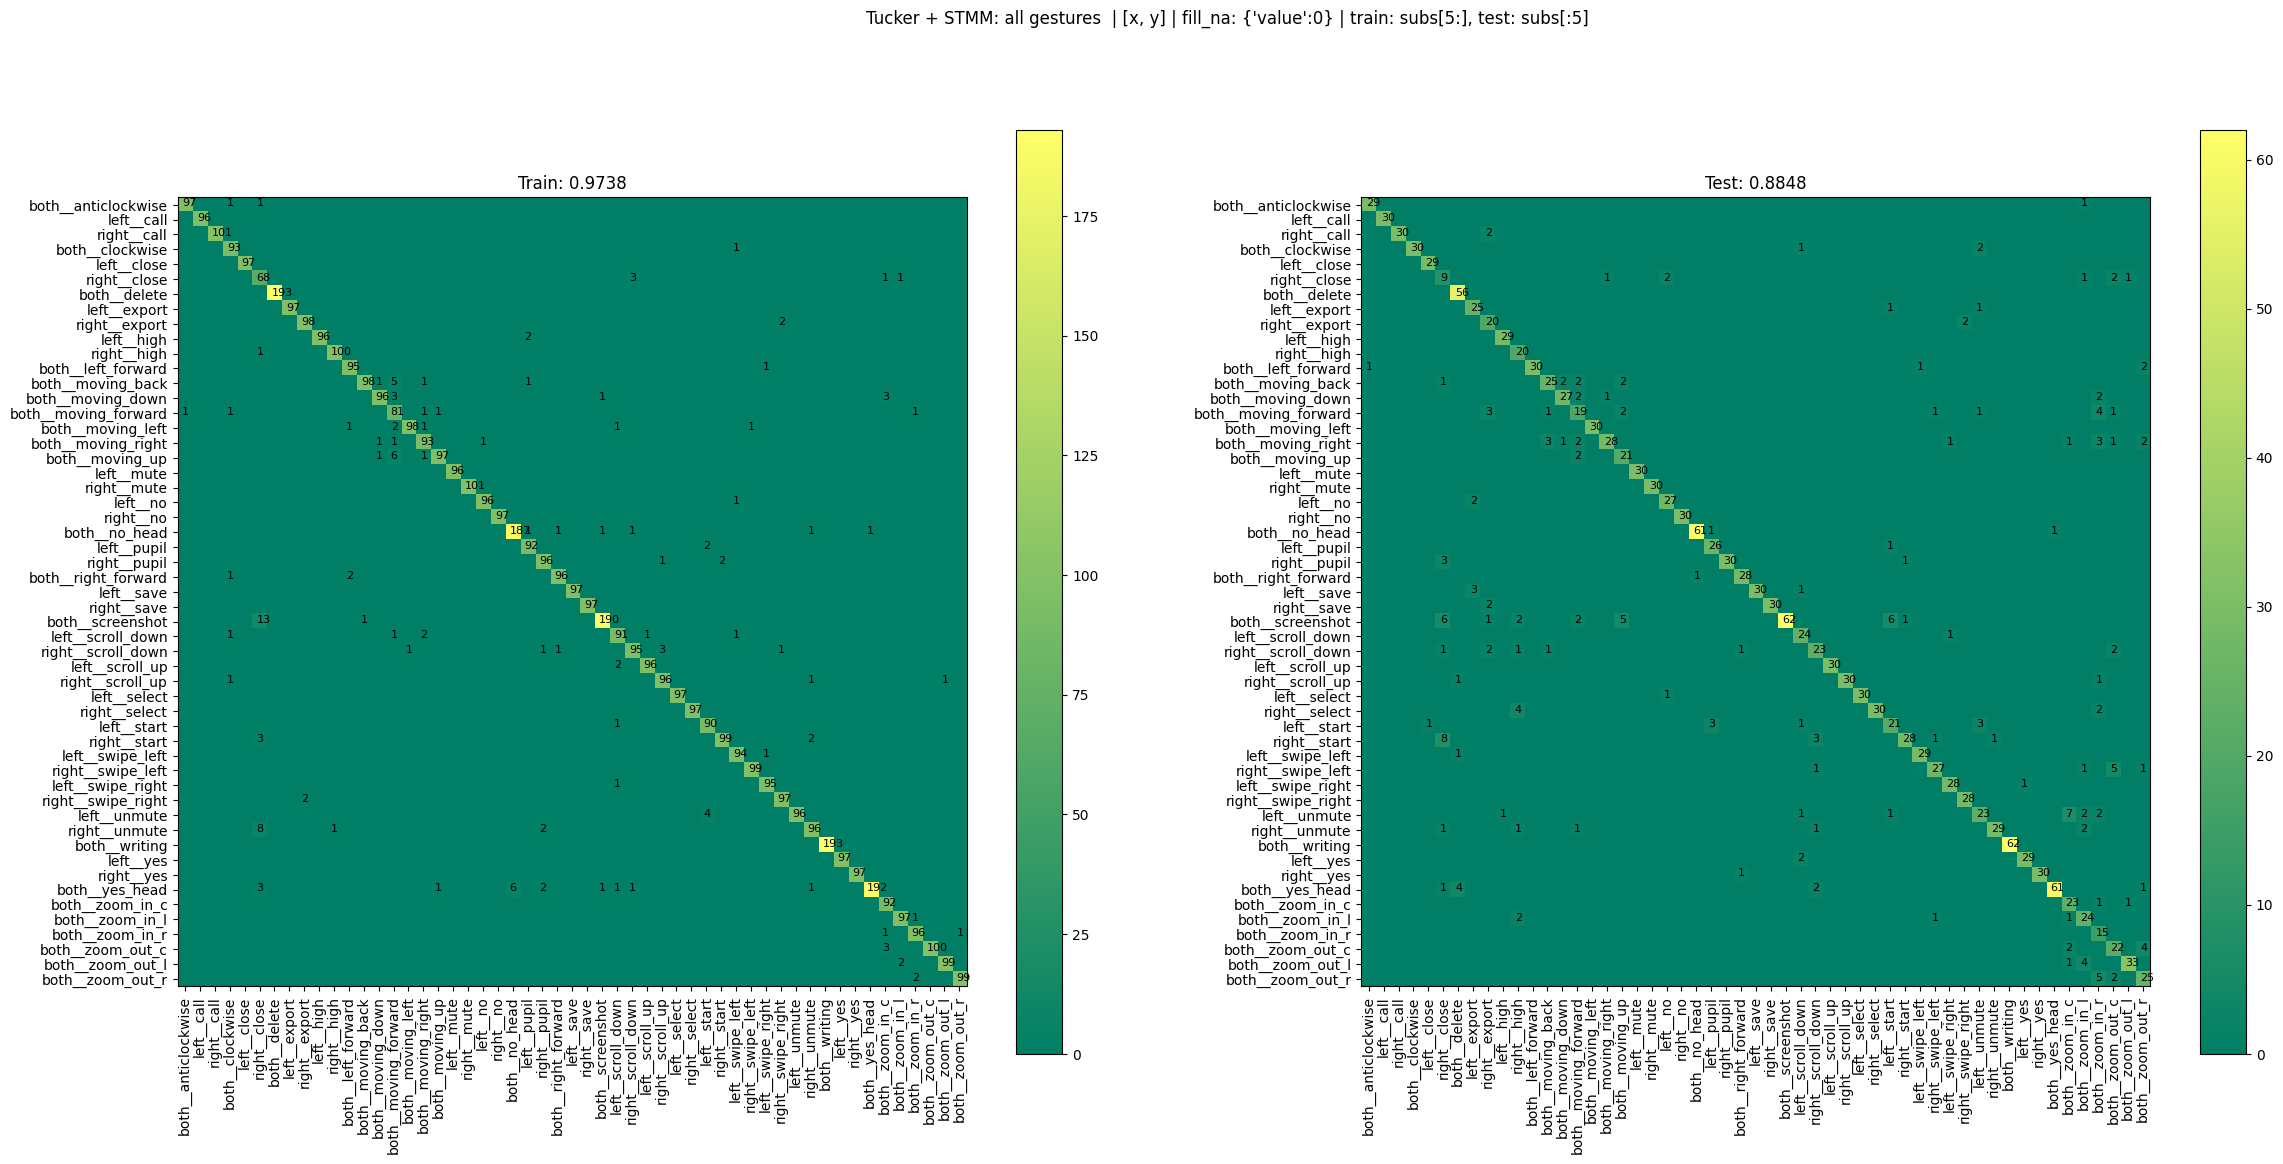

In [ ]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name + ": "+ exp_cofig)
print()

#### KNN

In [ ]:
model = KNeighborsClassifier(n_neighbors=30)
model_name = 'Tucker+ KNN'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

2
2



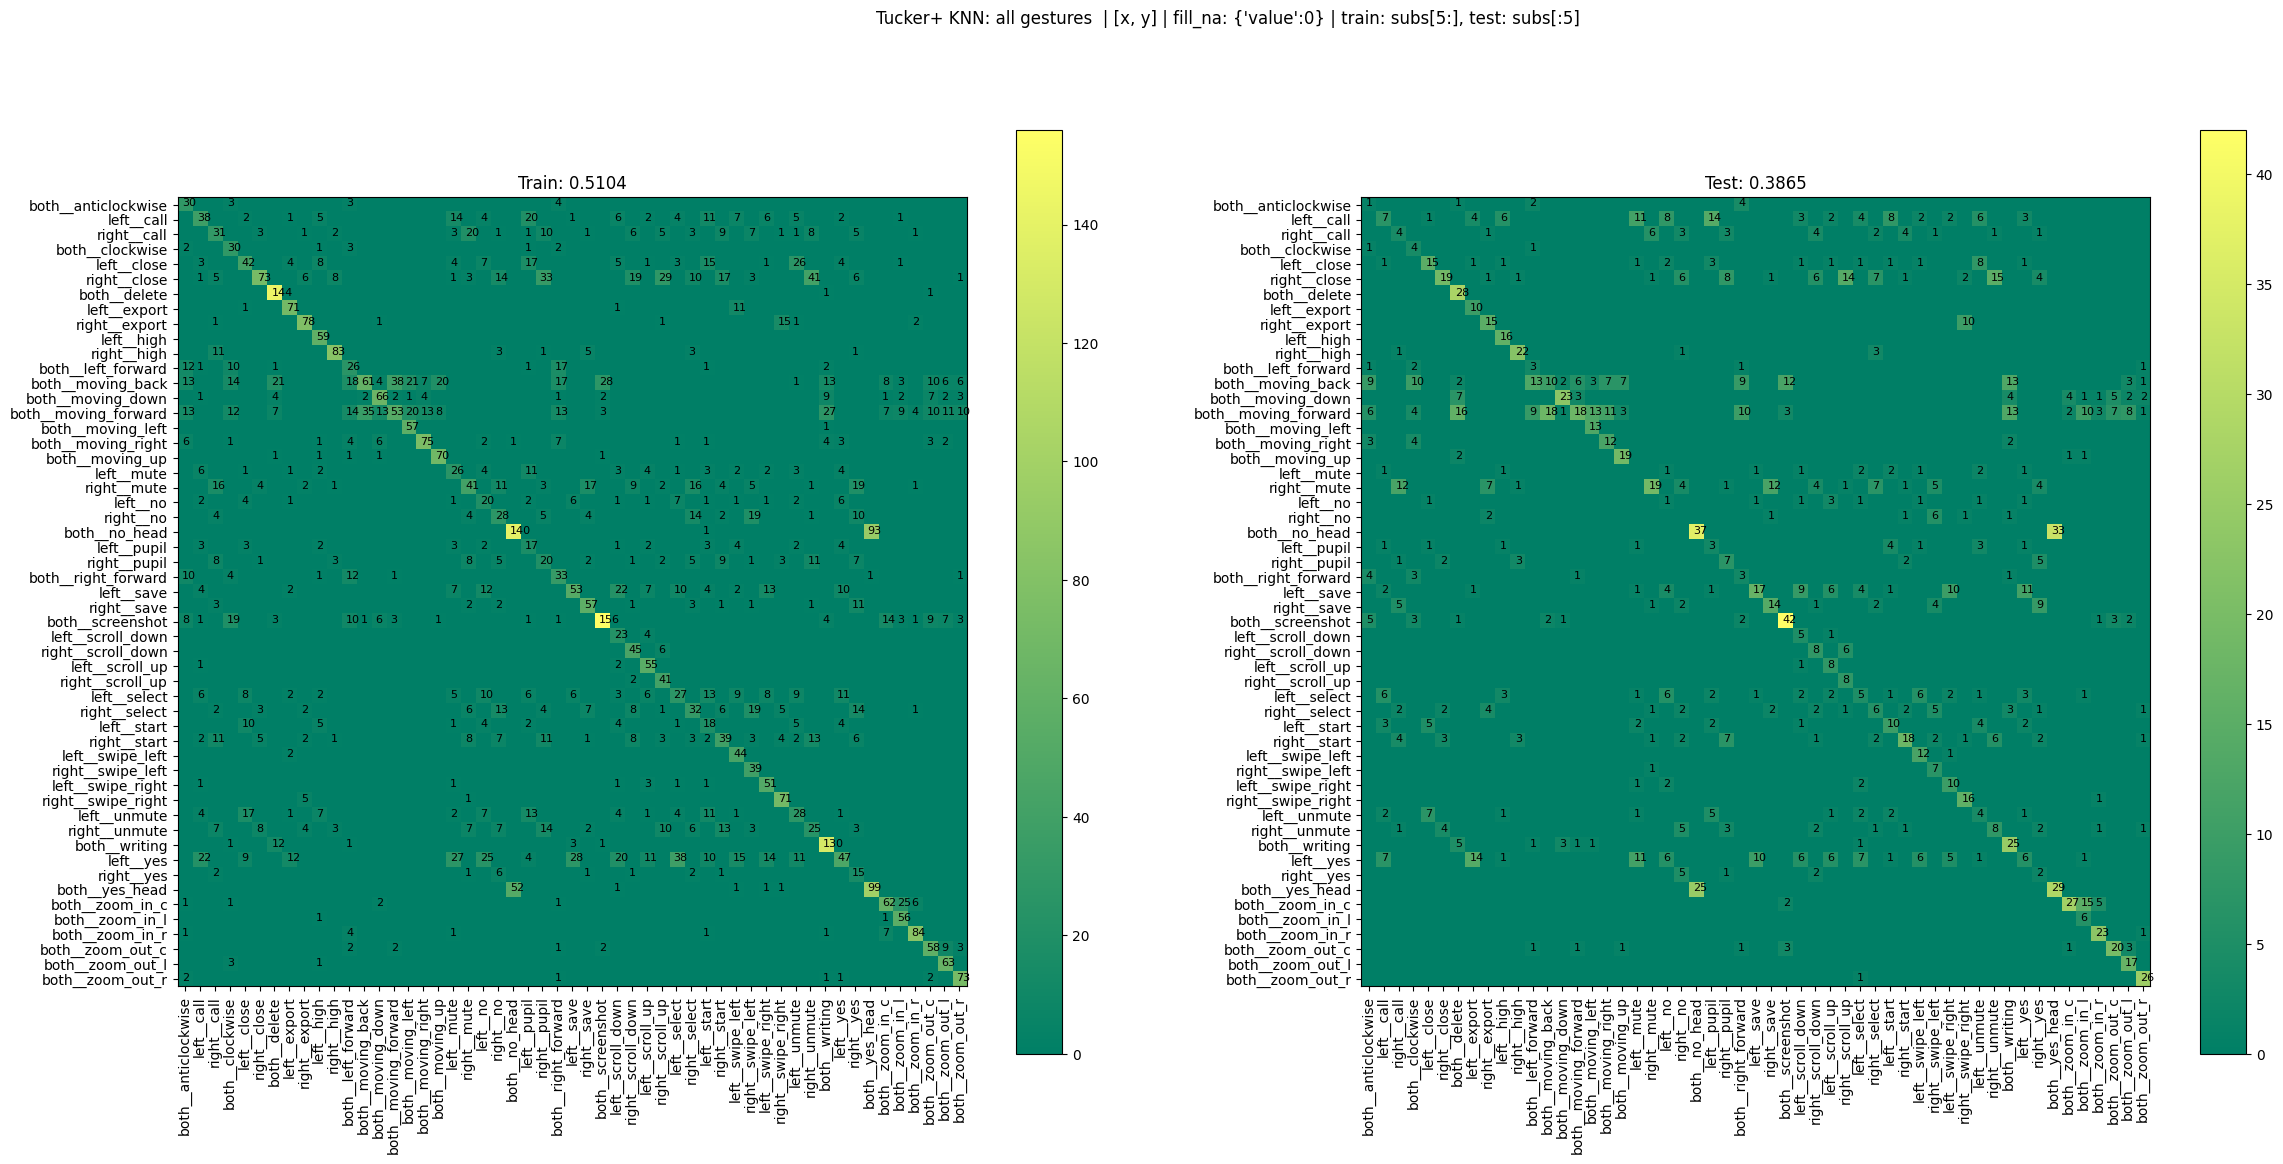

In [ ]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

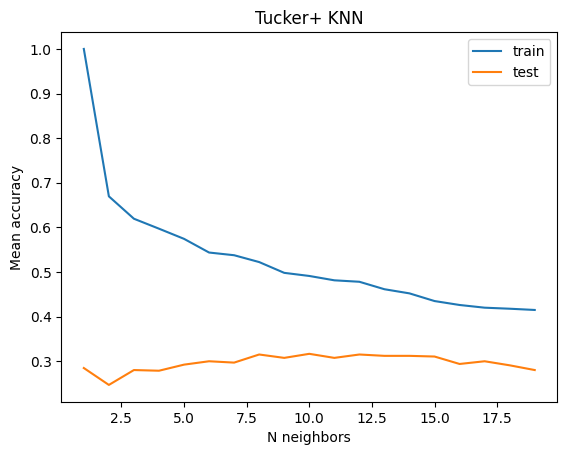

In [ ]:
check_KNN(X_train, y_train, X_test, y_test, model_name)  